#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96 #  (submerged) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # 32219000   # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.7602395 ,  0.50380347, -0.41014383],
       [-0.63436944,  0.43961653, -0.63585589],
       [-0.1400404 ,  0.74358548,  0.65381138]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.008181


In [29]:
Ret.shape

(50, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000355


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[ -6257.33327678,   7787.22723775, -13895.12341563],
       [ -4928.92157495, -10114.45134888,  -7655.06892392],
       [ -4820.12162431,    526.15254999,  -4251.60384742],
       [  9025.4975234 ,   4417.21052123,  -3959.94925095],
       [-34011.93177673,  15789.08636727, -26829.93823771],
       [-21671.34525261,   9466.81408063,   1927.98129626],
       [  4848.56945457,   9175.35571397,   1418.28341944],
       [  3506.71225521,   4348.23555503,   8649.35884137],
       [  2380.36960037,   2772.93604514,   4348.48219263],
       [  -563.37321144,   -589.78647118,   -338.82850578],
       [-49576.62471926, -42104.80761384,  44174.35837896],
       [  7420.60932349,  -5766.99691477,  25421.7938346 ],
       [ 17887.34355854, -17213.93621934,  -1717.49465917],
       [  4210.26013289,  -5772.76546465,  -4660.80715459],
       [ -2327.54062864,  -4007.9155824 ,   -257.12368603],
       [ 19116.568382  ,   2402.00175498, -10383.33616205],
       [  5465.89614392,   9278.63319656

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001278


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000364


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000135


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[ -24.30726714,  -78.94577907,  193.10310723],
       [ 136.33492107,  -34.06953269,   37.03880075],
       [-163.57860572,  -37.8888563 ,   89.37770374],
       [  23.8788059 ,   -3.45935645,  -39.02639222],
       [  19.19332896,   -4.61765519,  -16.55156668],
       [   8.52515343,  -73.76242725,   66.82363752],
       [  78.02441917,  -71.97194084,  -10.46338773],
       [ 173.07406556, -107.29774852,   -9.5956888 ],
       [  50.56886186,  -70.59068052,  -20.29261142],
       [-157.16758959,   15.2528622 , -153.14007578],
       [ -41.30784258,   32.63365198, -143.54970775],
       [ 125.43890169,  -38.06588974,  -61.83476119],
       [ -64.90512197, -218.55921898, -108.39166492],
       [-145.72914648,   88.63256633,  -28.42960878],
       [ -47.23734643, -180.77813679,   36.24614187],
       [ 199.93034105,    6.56325952, -113.0837583 ],
       [ -65.96888421,   -9.35186717,   49.1612304 ],
       [-169.26054288,  -28.76674877, -141.39939797],
       [  89.5769274 , -170.

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.001086


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002103


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.008813


In [57]:
ωe(φ,θ,ψ,None,None)

array([[ 0.87567911, -0.01458235, -0.06622337],
       [ 0.79924437,  0.16434966, -0.00719   ],
       [-0.65398363,  0.218672  ,  1.12397728],
       [ 0.2875481 ,  1.95372758,  0.72724608],
       [-0.68438824,  0.59696119, -0.60910637],
       [ 0.27355233, -2.09085806,  0.4523501 ],
       [ 0.29056699, -0.11176485, -0.98517151],
       [-0.02700312, -1.22450681, -2.40242477],
       [ 0.67813613, -0.34879813,  1.26948828],
       [-0.34784621, -0.49162857,  0.43746199],
       [ 0.7204161 ,  0.65076948, -0.37687183],
       [-1.13021375,  0.59116816,  0.63726534],
       [-0.21674137, -0.78097087, -0.64155185],
       [-0.43206236,  1.76419855,  1.19891122],
       [ 1.6061575 , -1.14013055,  0.46918514],
       [ 0.54382748,  0.1209919 , -0.02375533],
       [-0.70486223, -1.79707892, -1.14853936],
       [-0.78662207, -0.14897314, -1.81788042],
       [ 0.28800556, -1.0324146 , -0.02019625],
       [ 0.27891461,  1.39680136,  1.19178237],
       [-0.99331574,  0.33475559, -0.057

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  -8.04395305,    5.84235429,   62.13061244,  -73.73113859,
         -12.69328636, -106.35230187,  -69.73526525, -246.02477354,
          96.69206963,   68.61548979,  -81.11906875,  -12.2966695 ,
         -55.56634027, -156.4180561 ,   43.49307991,  -13.52630584,
         -99.08760058,  -31.22979681,   30.33708926,  156.31014965,
           3.31146812,  -58.82579698,   21.94907085,  -44.45274705,
         -82.54026253, -187.80468822,  331.25682909,   43.96160018,
         -75.2971697 ,    0.56939539,  -99.36200904,   32.8881749 ,
         558.91614629, -143.90866499, -245.5585191 , -112.3560776 ,
         159.62170724,  107.49792064,  -16.99182317,  -61.34180047,
         -30.30819378,  -21.35745215,   38.41732267,   91.98912973,
         212.15116763,  -33.97952082,  223.26578202,   65.65071253,
          96.05589548,  -22.28844408],
       [-167.48664532,  -30.58329934, -125.40709222,   28.58773294,
         -23.01847671,  -14.42340814,  -73.82712258, -416.05653726,
         

In [60]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.005704


In [61]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [62]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [63]:
ne_(dx,dy,dz,DT,Ret)

array([[  6257.33327678,   4928.92157495,   4820.12162431,
         -9025.4975234 ,  34011.93177673,  21671.34525261,
         -4848.56945457,  -3506.71225521,  -2380.36960037,
           563.37321144,  49576.62471926,  -7420.60932349,
        -17887.34355854,  -4210.26013289,   2327.54062864,
        -19116.568382  ,  -5465.89614392,   4067.36038052,
        -20769.00659765, -11968.72845771,   -880.73589868,
         -6745.18310457,   2840.89138565,  -6774.60981999,
          2676.94955216,  -8990.62768947,   1425.55168536,
         17985.61738333,   -555.2642249 ,   3811.93175567,
          -779.93487719,    -76.09364308,    291.94361424,
         -3328.4792933 , -13991.13288835,  -9367.16777177,
            50.13263747,   7138.19219115,   1546.23915659,
        -13523.79636258,  -3368.60671108,  -5542.47196099,
         -7454.06605964,  -2427.84883161,    154.28134146,
          5888.45089884,   6978.37783233,  30048.50058112,
         -4534.78760288,   2226.2458164 ],
       [ -778

In [64]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004472


In [65]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-5.08850718e+09, -3.22463220e+10, -2.96431097e+10],
       [ 3.15364988e+09, -8.91182657e+09, -2.24063851e+10],
       [ 3.18277801e+09, -2.31865233e+09,  5.01565406e+10],
       [-1.13814746e+10,  1.38872200e+10, -3.67898986e+09],
       [-2.81948373e+09, -6.51967466e+09, -4.53940739e+09],
       [-2.78193949e+10, -8.40808912e+09, -9.61565700e+08],
       [-1.80303612e+10, -1.82532640e+10, -1.16414060e+10],
       [-1.73447494e+11, -2.29438748e+11,  1.74031775e+11],
       [ 4.97120009e+08,  1.39901775e+07, -2.49927892e+10],
       [ 3.63137897e+10, -8.37803937e+10, -6.10996834e+10],
       [-1.83592820e+10,  1.75020613e+10,  8.72838281e+09],
       [-1.38392646e+08,  3.72433193e+08, -1.30677316e+10],
       [-3.19268251e+10,  1.42932060e+10, -2.22524768e+09],
       [-1.34007605e+09, -4.46635286e+10,  4.86769221e+10],
       [ 1.81414018e+10, -2.22530539e+09, -3.10161223e+09],
       [-1.40753287e+10,  4.08155945e+10, -1.47088843e+10],
       [-1.35198552e+10,  5.98764134e+10

In [66]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000428


In [67]:
Re_b(Ret).shape

(50, 3, 3)

In [68]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [69]:
Irho_e(Ret).shape

(50, 3, 3)

In [70]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000508


In [71]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [72]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [73]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [74]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006170


In [75]:
d_me_

array([[ 1.76187222e+00,  8.41541563e+00,  1.31323447e+01],
       [-9.30305072e-01,  6.78878756e+00,  1.70451405e+02],
       [ 4.26359843e+01, -2.73241478e+01,  6.36615625e+02],
       [ 4.24512603e+02, -4.86945949e+02,  1.31021942e+02],
       [ 3.16195762e+02, -9.46387309e+01, -1.11969226e+03],
       [-1.25946745e+03, -1.23337696e+02,  6.38574624e+02],
       [-1.90747227e+01,  1.84403993e+02, -1.00540722e+02],
       [-3.83360664e+03, -7.77529979e+01,  1.07529444e+02],
       [-1.53392644e+01, -1.09354114e+00, -5.04072631e+01],
       [ 6.80411653e+02, -3.31443545e+02,  3.43471537e+02],
       [-6.02851714e+01, -1.60920220e+02, -4.11736463e+02],
       [-1.63250732e+01, -3.94050931e+01, -7.20957532e+02],
       [ 1.45110336e+02, -1.50348375e+02,  8.38320557e+01],
       [-3.59187817e+01, -2.42818695e+02, -2.61687760e+00],
       [-8.66078282e+02,  2.29394343e+01,  8.10017031e+01],
       [-5.78818249e+00,  5.09230519e+01,  1.59887281e+02],
       [ 6.54969174e+02, -2.12518483e+03

In [76]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[  6257.33327678,   4928.92157495,   4820.12162431,
         -9025.4975234 ,  34011.93177673,  21671.34525261,
         -4848.56945457,  -3506.71225521,  -2380.36960037,
           563.37321144,  49576.62471926,  -7420.60932349,
        -17887.34355854,  -4210.26013289,   2327.54062864,
        -19116.568382  ,  -5465.89614392,   4067.36038052,
        -20769.00659765, -11968.72845771,   -880.73589868,
         -6745.18310457,   2840.89138565,  -6774.60981999,
          2676.94955216,  -8990.62768947,   1425.55168536,
         17985.61738333,   -555.2642249 ,   3811.93175567,
          -779.93487719,    -76.09364308,    291.94361424,
         -3328.4792933 , -13991.13288835,  -9367.16777177,
            50.13263747,   7138.19219115,   1546.23915659,
        -13523.79636258,  -3368.60671108,  -5542.47196099,
         -7454.06605964,  -2427.84883161,    154.28134146,
          5888.45089884,   6978.37783233,  30048.50058112,
         -4534.78760288,   2226.2458164 ],
       [ -778

### Vessel

In [78]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [79]:
V=VesselSemisub()

In [80]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [81]:
tau_force = V.tau(η,dη, ddη)

In [82]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [83]:
wave_coef=1

In [84]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [85]:
Hs = 2.5 # significant wave height in m

In [86]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [87]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [88]:

def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    ans=np.concatenate( [F,[0,0,0]], axis=0)
    return ans

In [89]:
tau(η, dη, wave_coef, kp, kd,3)

array([9750.        ,    0.        , 7283.67179881,    0.        ,
          0.        ,    0.        ])

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [99]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

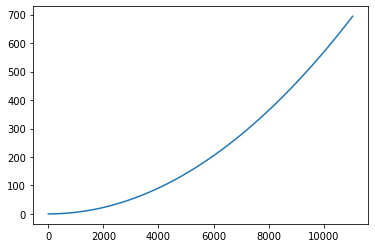

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)


    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
############################################################    

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
    return ans 

In [104]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([ 6.20781514e-01,  2.25660496e+02,  4.51487595e+02,  6.78101204e+02,
        9.02880012e+02,  1.12844501e+03,  1.35401001e+03,  1.57957500e+03,
        1.80514000e+03,  2.03070500e+03,  2.25626999e+03,  2.48183499e+03,
        2.70739999e+03,  2.93296498e+03,  3.15852998e+03,  3.38409498e+03,
        3.60965997e+03,  3.83522497e+03,  4.06078997e+03,  4.28635496e+03,
        4.51191996e+03,  4.73748496e+03,  4.96304996e+03,  5.18861495e+03,
        5.41417995e+03,  5.63974495e+03,  5.86530994e+03,  6.09087494e+03,
        6.31643994e+03,  6.54200493e+03,  6.76756993e+03,  6.99313493e+03,
        7.21869992e+03,  7.44426492e+03,  7.66982992e+03,  7.89539491e+03,
        8.12095991e+03,  8.34652491e+03,  8.57208990e+03,  8.79765490e+03,
        9.02321990e+03,  9.24878490e+03,  9.47434989e+03,  9.69991489e+03,
        9.92547989e+03,  1.01510449e+04,  1.03766099e+04,  1.06021749e+04,
        1.08277399e+04,  1.10533049e+04, -1.37673236e-16, -1.37673236e-16,
       -1.37673236e-16, -

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [109]:
x0_

array([6.20781514e-01, 2.25660496e+02, 4.51487595e+02, 6.78101204e+02,
       9.02880012e+02, 1.12844501e+03, 1.35401001e+03, 1.57957500e+03,
       1.80514000e+03, 2.03070500e+03, 2.25626999e+03, 2.48183499e+03,
       2.70739999e+03, 2.93296498e+03, 3.15852998e+03, 3.38409498e+03,
       3.60965997e+03, 3.83522497e+03, 4.06078997e+03, 4.28635496e+03,
       4.51191996e+03, 4.73748496e+03, 4.96304996e+03, 5.18861495e+03,
       5.41417995e+03, 5.63974495e+03, 5.86530994e+03, 6.09087494e+03,
       6.31643994e+03, 6.54200493e+03, 6.76756993e+03, 6.99313493e+03,
       7.21869992e+03, 7.44426492e+03, 7.66982992e+03, 7.89539491e+03,
       8.12095991e+03, 8.34652491e+03, 8.57208990e+03, 8.79765490e+03,
       9.02321990e+03, 9.24878490e+03, 9.47434989e+03, 9.69991489e+03,
       9.92547989e+03, 1.01510449e+04, 1.03766099e+04, 1.06021749e+04,
       1.08277399e+04, 1.10533049e+04])

In [110]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [111]:
z0_

array([6.83794572e-05, 2.88911204e-01, 1.15544150e+00, 2.59966484e+00,
       4.62159056e+00, 7.22123174e+00, 1.03986052e+01, 1.41537314e+01,
       1.84866348e+01, 2.33973434e+01, 2.88858895e+01, 3.49523093e+01,
       4.15966432e+01, 4.88189355e+01, 5.66192342e+01, 6.49975912e+01,
       7.39540615e+01, 8.34887040e+01, 9.36015812e+01, 1.04292759e+02,
       1.15562308e+02, 1.27410301e+02, 1.39836817e+02, 1.52841935e+02,
       1.66425743e+02, 1.80588328e+02, 1.95329783e+02, 2.10650206e+02,
       2.26549696e+02, 2.43028357e+02, 2.60086299e+02, 2.77723632e+02,
       2.95940472e+02, 3.14736939e+02, 3.34113156e+02, 3.54069250e+02,
       3.74605353e+02, 3.95721598e+02, 4.17418124e+02, 4.39695074e+02,
       4.62552593e+02, 4.85990832e+02, 5.10009944e+02, 5.34610087e+02,
       5.59791423e+02, 5.85554115e+02, 6.11898334e+02, 6.38824252e+02,
       6.66332046e+02, 6.94421896e+02])

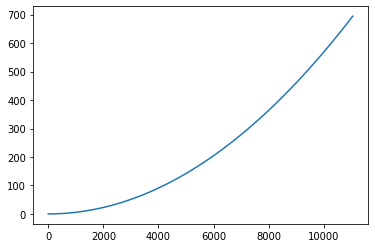

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[j*node_N-1]=0.13  

In [114]:
q0

array([6.20781514e-01, 2.25660496e+02, 4.51487595e+02, 6.78101204e+02,
       9.02880012e+02, 1.12844501e+03, 1.35401001e+03, 1.57957500e+03,
       1.80514000e+03, 2.03070500e+03, 2.25626999e+03, 2.48183499e+03,
       2.70739999e+03, 2.93296498e+03, 3.15852998e+03, 3.38409498e+03,
       3.60965997e+03, 3.83522497e+03, 4.06078997e+03, 4.28635496e+03,
       4.51191996e+03, 4.73748496e+03, 4.96304996e+03, 5.18861495e+03,
       5.41417995e+03, 5.63974495e+03, 5.86530994e+03, 6.09087494e+03,
       6.31643994e+03, 6.54200493e+03, 6.76756993e+03, 6.99313493e+03,
       7.21869992e+03, 7.44426492e+03, 7.66982992e+03, 7.89539491e+03,
       8.12095991e+03, 8.34652491e+03, 8.57208990e+03, 8.79765490e+03,
       9.02321990e+03, 9.24878490e+03, 9.47434989e+03, 9.69991489e+03,
       9.92547989e+03, 1.01510449e+04, 1.03766099e+04, 1.06021749e+04,
       1.08277399e+04, 1.10533049e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Dynamics

In [115]:
def grayscott1d(t, Q):
    print(t)
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 5 sec
    if t<5:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
    force_schedule = t/15 if t<15 else 1
#     force_schedule =1
    tau_force = force_schedule*V.tau(η,dη,ddη).astype(np.float32) # /1e3
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)


    Z0=np.dot(Re_b(Ret),tau_force[:3].reshape(3,1))

#     Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 =d_s(ne, x, y, z, Ret, test).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0.squeeze())

############################################################    
    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),Z).T
############################################################    

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           test))

    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 

#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))

    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [116]:
tspan = (0., 10)

In [117]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
print(datetime.now() - startTime1)

0.0
0.00010444055243823689
0.002088811048764738
0.003133216573147107
0.008355244195058951
0.009283604661176613
0.01044405524382369
0.01044405524382369
0.03133216573147107
0.04177622097529476
0.09399649719441322
0.10328010185558982
0.11488460768206059
0.11488460768206059
0.1912283250515462
0.22940018373628895
0.42025947716000295
0.45419001821310756
0.4966031945294885
0.4966031945294885
0.588489252253926
0.6344322811161447
0.8641474254272384
0.9049856733047661
0.9560334831516759
0.9560334831516759
0.5717194138978487
0.6092775235820288
0.7970680720029294
0.8304530583888672
0.8721842913712896
0.8721842913712896
0.9473005107396498
0.98485862042383
1.1726491688447305
1.2060341552306684
1.2477653882130908
1.2477653882130908
0.9285301026426399
0.9567030082783151
1.0975675364566908
1.1226101192439577
1.1539133477280412
1.1539133477280412
1.2102591589993916
1.2384320646350666
1.3792965928134424
1.4043391756007093
1.4356424040847928
1.4356424040847928
1.4967985219427329
1.527376580871703
1.680266

3.7952337875707833
3.795434756288651
3.795434756288651
3.796140194642252
3.7964929138190526
3.798256509703055
3.798570037860211
3.798961948056656
3.798961948056656
3.799752431654268
3.800147673453074
3.8021238824471038
3.802475208490487
3.8029143660447158
3.8029143660447158
3.7993176241296807
3.799495462166193
3.800384652348755
3.8005427306034325
3.80074032842178
3.80074032842178
3.8010960044948043
3.801273842531317
3.802163032713879
3.802321110968556
3.8025187087869035
3.8025187087869035
3.803145432078685
3.803458793724576
3.8050256019540303
3.8053041456392664
3.805652325245812
3.805652325245812
3.8063343864311276
3.8066754170237855
3.808380569987075
3.80868370829166
3.8090626311723907
3.8090626311723907
3.805951560898375
3.806101178724657
3.8068492678560646
3.806982261479426
3.807148503508628
3.807148503508628
3.807447739161191
3.807597356987473
3.8083454461188806
3.808478439742242
3.808644681771444
3.808644681771444
3.8092756696300167
3.809591163559303
3.811168633205735
3.8114490722

3.880420847293329
3.878741072916851
3.8788241587038743
3.879239587638992
3.8793134416719015
3.879405759213039
3.879405759213039
3.879571930787086
3.8796550165741093
3.8800704455092268
3.8801442995421365
3.880236617083274
3.880236617083274
3.8805182311344377
3.88065903816002
3.8813630732879303
3.8814882350884474
3.881644687339094
3.881644687339094
3.881945676835654
3.8820961715839344
3.882848645325334
3.882982418434916
3.883149634821894
3.883149634821894
3.881779070702268
3.8818462623838546
3.882182220791789
3.8822419467309772
3.882316604154963
3.882316604154963
3.8824509875181366
3.8825181791997236
3.8828541376076577
3.882913863546846
3.8829885209708315
3.8829885209708315
3.883282748502551
3.8834298622684105
3.884165431097709
3.8842961988895843
3.8844596586294284
3.8844596586294284
3.8848074814167997
3.8849813928104857
3.885850949778914
3.8860055376844125
3.8861987725662854
3.8861987725662854
3.884616219167039
3.8846944994358448
3.8850859007798717
3.8851554832410318
3.8852424613174823


3.9238143412491535
3.9238951932573434
3.9239962582675805
3.9239962582675805
3.9241922363284356
3.924290225358863
3.9247801705110015
3.9248672718713813
3.9249761485718566
3.9249761485718566
3.9240854298354657
3.9241300156194083
3.9243529445391214
3.9243925763470706
3.9244421161070067
3.9244421161070067
3.924531287674892
3.9245758734588345
3.9247988023785476
3.924838434186497
3.924887973946433
3.924887973946433
3.925079224372684
3.92517484958581
3.9256529756514382
3.9257379758408835
3.9258442260776896
3.9258442260776896
3.926070259717903
3.92618327653801
3.926748360638544
3.926848820034194
3.926974394278757
3.926974394278757
3.9259459383583306
3.9259967944986514
3.9262510752002546
3.9262962806583173
3.9263527874808957
3.9263527874808957
3.9264544997615367
3.9265053559018575
3.9267596366034607
3.9268048420615234
3.9268613488841018
3.9268613488841018
3.927039207638366
3.9271281370154982
3.9275727839011587
3.927651832236387
3.9277506426554227
3.9277506426554227
3.9279438896708063
3.92804051

3.953971482061663
3.954004861075796
3.9541717561464584
3.9542014263812426
3.9542385141747234
3.9542385141747234
3.9543812290610316
3.9544525865041855
3.954809373719956
3.9548728025583153
3.954952088606264
3.954952088606264
3.9551204091674683
3.9552045694480706
3.955625370851082
3.9557001799893947
3.955793691412286
3.955793691412286
3.955027874298874
3.9550657671451788
3.9552552313767038
3.9552889139067524
3.9553310170693137
3.9553310170693137
3.9554068027619236
3.9554446956082288
3.9556341598397533
3.955667842369802
3.955709945532363
3.955709945532363
3.955842300915878
3.9559084786076357
3.9562393670664235
3.956298191681319
3.9563717224499384
3.9563717224499384
3.9565161487279936
3.9565883618670212
3.956949427562159
3.957013617019072
3.957093853840214
3.957093853840214
3.95643604303194
3.9564682033229404
3.9566290047779438
3.956657591703278
3.9566933253599452
3.9566933253599452
3.9567576459419467
3.956789806232947
3.9569506076879506
3.9569791946132846
3.957014928269952
3.95701492826995

3.9776120004072686
3.9779525163491236
3.9780130525165642
3.9780887227258654
3.9780887227258654
3.977468991849684
3.9774996423534486
3.977652894872269
3.977680139764504
3.9777141958797975
3.9777141958797975
3.977775496887326
3.9778061473910897
3.9779593999099108
3.9779866448021455
3.978020700917439
3.978020700917439
3.9781245676055197
3.97817650094956
3.978436167669761
3.978482330642241
3.9785400343578416
3.9785400343578416
3.978652511200067
3.9787087496211795
3.9789899417267423
3.9790399314343983
3.9791024185689676
3.9791024185689676
3.9785922936226523
3.978618423255057
3.9787490714170834
3.9787722977569993
3.978801330681894
3.978801330681894
3.978853589946705
3.9788797195791097
3.979010367741136
3.9790335940810517
3.9790626270059466
3.9790626270059466
3.979172370378582
3.9792272420649004
3.97950160049649
3.979550375328772
3.9796113438691254
3.9796113438691254
3.9797410056688634
3.9798058365687328
3.980129991068078
3.9801876185346283
3.980259652867816
3.980259652867816
3.97966936433968

3.9959698234547156
3.996020938293916
3.996046495713516
3.9961742828115163
3.9961970005178276
3.9962253976507167
3.9962253976507167
3.9963112702784302
3.996354206592287
3.9965688881615713
3.9966070537738885
3.996654760789285
3.996654760789285
3.9967477901956596
3.996794304898847
3.997026878414784
3.997068224817617
3.997119907821159
3.997119907821159
3.9966987235045317
3.996720704862155
3.9968306116502728
3.996850150634827
3.9968745743655196
3.9968745743655196
3.9969185370807665
3.99694051843839
3.9970504252265076
3.997069964211062
3.9970943879417544
3.9970943879417544
3.9971852954169047
3.9972307491544803
3.9974580178423564
3.997498421164645
3.9975489253175067
3.9975489253175067
3.997656186731206
3.997709817438056
3.997977970972304
3.9980256427117262
3.9980852323860034
3.9980852323860034
3.9975966022845304
3.997620440768042
3.9977396331856014
3.997760822948723
3.997787310152625
3.997787310152625
3.997834987119649
3.997858825603161
3.99797801802072
3.9979992077838413
3.9980256949877435
3

4.0121596115153215
4.012176598243141
4.012197831652917
4.012197831652917
4.012236051790512
4.01225516185931
4.012350712203299
4.0123676989311186
4.012388932340894
4.012388932340894
4.012468076242762
4.012507648193695
4.012705507948366
4.0127406830158625
4.012784651850233
4.012784651850233
4.012877176587385
4.012923438955961
4.013154750798841
4.013195872904242
4.013247275535993
4.013247275535993
4.01282625241513
4.012847052697578
4.012951054109819
4.012969543249773
4.012992654674716
4.012992654674716
4.013034255239613
4.01305505552206
4.013159056934302
4.013177546074256
4.0132006574991985
4.0132006574991985
4.013275615389076
4.0133130943340145
4.013500489058709
4.013533803676432
4.013575446948586
4.013575446948586
4.013658686056208
4.013700305610019
4.013908403379075
4.013945398538017
4.013991642486697
4.013991642486697
4.01361189889965
4.013630124875181
4.01372125475284
4.013737455619979
4.013757706703903
4.013757706703903
4.013794158654967
4.013812384630499
4.013903514508157
4.0139197

4.026149204981126
4.026149204981126
4.02618191588944
4.026198271343596
4.026280048614382
4.026294586795855
4.026312759522696
4.026312759522696
4.026381577331178
4.026415986235419
4.026588030756623
4.026618616449282
4.026656848565105
4.026656848565105
4.026737930416291
4.026778471341884
4.026981175969849
4.027017212348154
4.027062257821035
4.027062257821035
4.026693273847547
4.026711486488768
4.026802549694873
4.0268187387092915
4.026838974977315
4.026838974977315
4.026875400259756
4.026893612900977
4.026984676107082
4.027000865121501
4.027021101389524
4.027021101389524
4.027086409734611
4.027119063907155
4.027282334769873
4.027311360701023
4.02734764311496
4.02734764311496
4.027419829181099
4.027455922214168
4.0276363873795145
4.027668470075576
4.027708573445653
4.027708573445653
4.027379208853028
4.027394991722062
4.027473906067231
4.0274879352841495
4.0275054718052985
4.0275054718052985
4.027537037543366
4.0275528204124
4.027631734757569
4.027645763974488
4.027663300495637
4.02766330

4.038451154963605
4.0385337968521675
4.0385484887434675
4.038566853607593
4.038566853607593
4.03862289556676
4.038650916546343
4.0387910214442595
4.038815928981667
4.038847063403426
4.038847063403426
4.038908506675787
4.038939228311967
4.039092836492867
4.039120144613917
4.039154279765228
4.039154279765228
4.03887637330609
4.038891028257423
4.038964303014082
4.038977329637489
4.038993612916746
4.038993612916746
4.03902292281941
4.039037577770742
4.039110852527402
4.039123879150809
4.0391401624300665
4.0391401624300665
4.039199674824467
4.039229431021668
4.039378212007669
4.039404661960736
4.03943772440207
4.03943772440207
4.0395075265321445
4.039542427597182
4.039716932922366
4.039747956091288
4.039786735052441
4.039786735052441
4.039468638865935
4.039484096097867
4.039561382257528
4.0395751220192455
4.039592296721392
4.039592296721392
4.039623211185257
4.039638668417188
4.03971595457685
4.039729694338567
4.039746869040714
4.039746869040714
4.039806599721149
4.039836465061366
4.0399857

4.049423653840676
4.0494393773049495
4.0494393773049495
4.049493448375637
4.049520483910982
4.0496556615877015
4.0496796931746735
4.049709732658389
4.049709732658389
4.049770447658865
4.049800805159103
4.049952592660294
4.04997957710495
4.0500133076607705
4.0500133076607705
4.049736914359161
4.049750505209547
4.049818459461476
4.049830540217375
4.049845641162248
4.049845641162248
4.04987282286302
4.049886413713406
4.049954367965335
4.049966448721234
4.049981549666107
4.049981549666107
4.050034424461037
4.050060861858502
4.050193048845828
4.050216548754686
4.050245923640758
4.050245923640758
4.050306966554198
4.050337488010919
4.050490095294521
4.050517225478272
4.050551138207961
4.050551138207961
4.0502725816161265
4.050285910603811
4.050352555542233
4.050364403531286
4.050379213517601
4.050379213517601
4.05040587149297
4.050419200480654
4.050485845419076
4.050497693408129
4.050512503394445
4.050512503394445
4.05056744020138
4.0505949086048485
4.050732250622189
4.050756666980827
4.0507

4.059233257875722
4.059243967666957
4.059257354905999
4.059257354905999
4.059306656393964
4.059331307137946
4.059454560857858
4.059476472630287
4.059503862345823
4.059503862345823
4.059561422869074
4.0595902031307
4.059734104438828
4.059759686893607
4.05979166496208
4.05979166496208
4.059529650890228
4.05954254516243
4.059607016523444
4.059618478098735
4.059632805067849
4.059632805067849
4.059658593612255
4.059671487884457
4.0597359592454705
4.059747420820762
4.059761747789876
4.059761747789876
4.0598093818280905
4.059833198847198
4.059952283942732
4.059973454626383
4.059999917980947
4.059999917980947
4.060053288832207
4.060079974257837
4.060213401385987
4.060237121764325
4.060266772237247
4.060266772237247
4.060022981847675
4.060034513781039
4.0600921734478606
4.060102424055295
4.060115237314589
4.060115237314589
4.0601383011813175
4.060149833114682
4.060207492781503
4.060217743388938
4.060230556648231
4.060230556648231
4.060280807827002
4.060305933416388
4.060431561363317
4.060453895

4.068229272836248
4.068229272836248
4.068271693335344
4.068292903584891
4.068398954832629
4.068417808387783
4.068441375331725
4.068441375331725
4.068487892978363
4.068511151801683
4.068627445918281
4.068648120427898
4.06867396356492
4.06867396356492
4.068462804591367
4.068473519221189
4.068527092370295
4.068536616485692
4.068548521629937
4.068548521629937
4.06856995088958
4.068580665519401
4.0686342386685075
4.068643762783904
4.06865566792815
4.06865566792815
4.068700633178143
4.068723115803139
4.068835528928122
4.068855513483674
4.0688804941781145
4.0688804941781145
4.06893358162017
4.0689601253411976
4.069092843946335
4.069116438365027
4.069145931388391
4.069145931388391
4.068904273987784
4.06891616389262
4.068975613416796
4.068986182221093
4.068999393226465
4.068999393226465
4.069023173036135
4.069035062940971
4.0690945124651465
4.069105081269444
4.069118292274816
4.069118292274816
4.069161605124386
4.069183261549172
4.069291543673098
4.069310793828462
4.069334856522668
4.0693348565

4.076640534981786
4.076640534981786
4.076686830602219
4.076709978412435
4.076825717463515
4.076846293294818
4.076872013083947
4.076872013083947
4.076661176338035
4.07667149701616
4.076723100406783
4.076732274342893
4.076743741763032
4.076743741763032
4.076764383119281
4.076774703797406
4.076826307188028
4.076835481124139
4.0768469485442775
4.0768469485442775
4.076887773894232
4.076908186569209
4.077010249944095
4.077028394544075
4.07705107529405
4.07705107529405
4.0770983896581345
4.077122046840177
4.07724033275039
4.0772613613566495
4.077287647114474
4.077287647114474
4.077071973953496
4.077082423283219
4.077134669931833
4.077143958224919
4.077155568591278
4.077155568591278
4.077176467250724
4.077186916580446
4.077239163229061
4.077248451522148
4.077260061888507
4.077260061888507
4.077301419590605
4.077322098441655
4.077425492696903
4.077443873897836
4.077466850399001
4.077466850399001
4.077514114578202
4.077537746667803
4.077655907115805
4.077676913417672
4.077703171295005
4.07770317

4.0844521046582685
4.0844521046582685
4.084245502213488
4.084255693920941
4.0843066524582055
4.084315711753718
4.084327035873111
4.084327035873111
4.084347419288016
4.084357610995469
4.084408569532734
4.0844176288282465
4.084428952947639
4.084428952947639
4.084465941807587
4.084484436237561
4.084576908387432
4.084593347880743
4.08461389724738
4.08461389724738
4.084655129845199
4.084675746144109
4.084778827638656
4.0847971532376866
4.084820060236475
4.084820060236475
4.084631907163056
4.084640912120894
4.084685936910082
4.084693941317049
4.0847039468257575
4.0847039468257575
4.084721956741433
4.084730961699271
4.084775986488459
4.084783990895426
4.084793996404135
4.084793996404135
4.084833298518175
4.084852949575196
4.084951204860298
4.084968672466538
4.084990506974338
4.084990506974338
4.085036925679499
4.08506013503208
4.085176181794982
4.085196812330609
4.085222600500143
4.085222600500143
4.085011381086793
4.085021818143021
4.085074003424158
4.0850832808074715
4.085094877536613
4.085

4.091472550357389
4.09149618370395
4.09149618370395
4.091302524720589
4.091312045288433
4.091359648127651
4.0913681108546225
4.091378689263338
4.091378689263338
4.0913977303990245
4.091407250966868
4.091454853806086
4.091463316533058
4.091473894941773
4.091473894941773
4.09150867553519
4.091526065831899
4.091613017315442
4.091628475356961
4.091647797908859
4.091647797908859
4.091686468179739
4.091705803315179
4.091802478992378
4.091819665779435
4.091841149263257
4.091841149263257
4.091664475108435
4.0916728137082226
4.091714506707162
4.091721918795862
4.091731183906738
4.091731183906738
4.091747861106314
4.091756199706102
4.091797892705041
4.091805304793741
4.091814569904617
4.091814569904617
4.091851307916404
4.091869676922298
4.091961521951765
4.091977849957003
4.091998259963551
4.091998259963551
4.092041755507814
4.092063503279945
4.092172242140601
4.092191573493606
4.092215737684863
4.092215737684863
4.092017804723837
4.09202757710398
4.092076439004693
4.09208512556482
4.0920959837

4.098073920851468
4.098073920851468
4.097892610122695
4.0979015035965105
4.097945970965587
4.097953876275645
4.0979637579132175
4.0979637579132175
4.097981544860848
4.097990438334663
4.09803490570374
4.098042811013798
4.09805269265137
4.09805269265137
4.098085472917547
4.098101863050636
4.098183813716079
4.098198382723269
4.098216593982256
4.098216593982256
4.098253099061419
4.098271351601001
4.09836261429891
4.0983788387785385
4.098399119378073
4.098399119378073
4.098232509401604
4.098240467111278
4.098280255659649
4.0982873291793585
4.098296171078997
4.098296171078997
4.098312086498344
4.098320044208019
4.0983598327563895
4.098366906276099
4.098375748175737
4.098375748175737
4.098409820201461
4.0984268562143225
4.09851203627863
4.098527179401174
4.098546108304354
4.098546108304354
4.098586278275768
4.098606363261475
4.098706788190011
4.098724641510639
4.098746958161425
4.098746958161425
4.098564188823918
4.0985732290837
4.09861843038261
4.098626466169082
4.098636510902174
4.098636510

4.104262763717657
4.104262763717657
4.104089993520057
4.104098538845601
4.1041412654733165
4.104148861318244
4.104158356124403
4.104158356124403
4.104175446775489
4.104183992101032
4.104226718728748
4.1042343145736755
4.104243809379835
4.104243809379835
4.104273554777238
4.10428842747594
4.104362790969451
4.1043760111460745
4.104392536366855
4.104392536366855
4.104425337181977
4.104441737589539
4.104523739627346
4.104538317767401
4.104556540442469
4.104556540442469
4.104407679270779
4.104415250722741
4.104453107982551
4.104459838162073
4.104468250886476
4.104468250886476
4.1044833937904
4.104490965242362
4.104528822502172
4.1045355526816945
4.104543965406097
4.104543965406097
4.104575527720137
4.104591308877156
4.104670214662254
4.104684242357383
4.1047017769762935
4.1047017769762935
4.104738955246444
4.104757544381519
4.104850490056895
4.104867013732518
4.104887668327046
4.104887668327046
4.104718417041373
4.104726737073913
4.104768337236614
4.104775732821094
4.104784977301693
4.10478

4.109972043735436
4.109979105873119
4.109987933545224
4.109987933545224
4.110003823355012
4.1100117682599056
4.110051492784376
4.11005855492206
4.110067382594164
4.110067382594164
4.11009633257399
4.110110807563903
4.110183182513467
4.110196049171167
4.1102121324932925
4.1102121324932925
4.1102442960069725
4.110260377763812
4.110340786548011
4.11035508144298
4.110372950061691
4.110372950061691
4.110225956438772
4.110232868411512
4.110267428275213
4.110273572250982
4.110281252220693
4.110281252220693
4.110295076166173
4.110301988138913
4.110336548002613
4.110342691978382
4.110350371948093
4.110350371948093
4.110381087069323
4.110396444629937
4.11047323243301
4.110486883598002
4.11050394755424
4.11050394755424
4.110540368067602
4.110558578324282
4.1106496296076855
4.110665816502513
4.110686050121047
4.110686050121047
4.110520284046683
4.110528452292904
4.110569293524011
4.110576554187319
4.1105856300164545
4.1105856300164545
4.110601966508898
4.1106101347551185
4.110650975986226
4.110658

4.115459503100055
4.115493905059915
4.11550002096389
4.115507665843859
4.115507665843859
4.1155214266278035
4.115528307019775
4.115562708979635
4.11556882488361
4.115576469763579
4.115576469763579
4.1156048820353135
4.115619088171181
4.115690118850518
4.115702746526844
4.115718531122252
4.115718531122252
4.115751793414981
4.115768424561345
4.115851580293168
4.115866363534381
4.115884842585897
4.115884842585897
4.115733443173928
4.115740899199766
4.115778179328955
4.115784806907478
4.115793091380631
4.115793091380631
4.115808003432307
4.115815459458145
4.115852739587334
4.115859367165857
4.11586765163901
4.11586765163901
4.115894927134625
4.1159085648824325
4.115976753621469
4.115988876063965
4.116004029117084
4.116004029117084
4.116034520536002
4.11604976624546
4.116125994792754
4.116139546534495
4.116156486211672
4.116156486211672
4.116017242710647
4.116023849507429
4.116056883491337
4.116062756199588
4.116070097084901
4.116070097084901
4.116083310678464
4.116089917475246
4.1161229514

4.120692833431313
4.1206991076277095
4.120730478609692
4.120736055673156
4.120743027002486
4.120743027002486
4.120755575395279
4.120761849591675
4.120793220573658
4.120798797637121
4.120805768966451
4.120805768966451
4.120833352178506
4.120847143784533
4.12091610181467
4.120928361020027
4.120943685026725
4.120943685026725
4.120976379116403
4.120992726161242
4.121074461385437
4.12108899209196
4.121107155475115
4.121107155475115
4.120958369490933
4.120965711723038
4.121002422883559
4.121008949312096
4.121017107347767
4.121017107347767
4.121031791811975
4.12103913404408
4.121075845204602
4.121082371633139
4.12109052966881
4.12109052966881
4.121115627908965
4.121128177029043
4.121190922629431
4.121202077402834
4.1212160208695865
4.1212160208695865
4.121243415059911
4.121257112155074
4.121325597630885
4.1213377728265845
4.121352991821209
4.121352991821209
4.121228811833434
4.121235207315357
4.121267184724975
4.121272869597797
4.1212799756888225
4.1212799756888225
4.12129276665267
4.12129916

4.1257241626342465
4.125731933567252
4.125731933567252
4.125745921246661
4.125752915086366
4.12578788428489
4.1257941010312935
4.125801871964299
4.125801871964299
4.125825849932476
4.125837838916565
4.125897783837009
4.125908440711754
4.125921761805186
4.125921761805186
4.125948003694806
4.125961124639616
4.126026729363668
4.126038392425722
4.126052971253288
4.126052971253288
4.125934019509982
4.12594014836238
4.125970792624369
4.125976240493168
4.1259830503291655
4.1259830503291655
4.1259953080339615
4.12600143688636
4.126032081148349
4.126037529017148
4.126044338853145
4.126044338853145
4.126069770024404
4.126082485610032
4.1261460635381795
4.126157366280961
4.126171494709438
4.126171494709438
4.126201526311465
4.126216542112478
4.126291621117544
4.126304968496223
4.126321652719571
4.126321652719571
4.126184850478077
4.126191528362396
4.126224917783993
4.126230853681166
4.126238273552632
4.126238273552632
4.1262516293212705
4.12625830720559
4.126291696627187
4.12629763252436
4.126305

4.130503210307639
4.130534941361776
4.130540582438067
4.130547633783431
4.130547633783431
4.130571891517696
4.130584020384829
4.130644664720491
4.13065544593572
4.130668922454756
4.130668922454756
4.130696289078415
4.130709972390244
4.13077838894939
4.130790551893239
4.130805755573049
4.130805755573049
4.13068109480844
4.130687180985282
4.130717611869493
4.130723021804464
4.130729784223177
4.130729784223177
4.130741956576861
4.130748042753703
4.130778473637913
4.130783883572884
4.130790645991597
4.130790645991597
4.130814792693791
4.130826866044886
4.130887232800369
4.13089796466801
4.130911379502562
4.130911379502562
4.130939356758149
4.130953345385942
4.13102328852491
4.131035722860726
4.1310512657804965
4.1310512657804965
4.1309237594984065
4.130929949496328
4.130960899485938
4.1309664017063135
4.130973279481783
4.130973279481783
4.130985659477627
4.130991849475548
4.131022799465159
4.131028301685534
4.131035179461003
4.131035179461003
4.131059490855218
4.131071646552326
4.131132425

4.13505417972548
4.135086093695947
4.135091767290698
4.135098859284135
4.135098859284135
4.135120827673958
4.135131811868869
4.135186732843428
4.135196496572238
4.1352087012332515
4.1352087012332515
4.1352327672956735
4.135244800326884
4.1353049654829395
4.135315661510683
4.1353290315453615
4.1353290315453615
4.1352198892171135
4.135225483209045
4.135253453168701
4.135258425605973
4.135264641152563
4.135264641152563
4.135275829136425
4.135281423128357
4.135309393088013
4.135314365525285
4.135320581071875
4.135320581071875
4.1353438726535785
4.13535551844443
4.135413747398688
4.135424099212778
4.135437038980391
4.135437038980391
4.135464552655098
4.135478309492452
4.135547093679221
4.13555932197909
4.135574607353928
4.135574607353928
4.135449287144521
4.1354554112265856
4.135486031636909
4.135491475265412
4.135498279801039
4.135498279801039
4.135510527965169
4.135516652047234
4.135547272457558
4.13555271608606
4.135559520621688
4.135559520621688
4.135582428378782
4.135593882257329
4.135

4.139394893808904
4.139400258941159
4.139427084602437
4.139431853608886
4.139437814866947
4.139437814866947
4.139460635228053
4.139472045408606
4.139529096311372
4.139539238694085
4.1395519166724775
4.1395519166724775
4.139578786042762
4.139592220727905
4.139659394153616
4.139671336095965
4.139686263523901
4.139686263523901
4.139563975647262
4.1395700051346545
4.139600152571617
4.139605512115966
4.139612211546402
4.139612211546402
4.139624270521187
4.13963030000858
4.139660447445542
4.139665806989891
4.139672506420327
4.139672506420327
4.139693790509513
4.1397044325541055
4.13975764277707
4.139767102372264
4.139778926866256
4.139778926866256
4.139802451216698
4.139814213391919
4.139873024268024
4.139883479534887
4.139896548618466
4.139896548618466
4.139789571695915
4.139794894110745
4.139821506184892
4.139826237220295
4.13983215101455
4.13983215101455
4.139842795844209
4.139848118259039
4.139874730333186
4.139879461368589
4.139885375162844
4.139885375162844
4.139907946622866
4.13991923

4.143563728547558
4.143563728547558
4.143574065025417
4.143579233264346
4.1436050744589945
4.143609668449154
4.143615410936854
4.143615410936854
4.143637113250952
4.143647964408
4.143702220193244
4.143711865666177
4.143723922507342
4.143723922507342
4.143749500363401
4.1437622892914305
4.143826233931578
4.143837601867604
4.143851811787637
4.143851811787637
4.143735366095975
4.143741087890291
4.143769696861873
4.143774782901265
4.143781140450506
4.143781140450506
4.143792584039139
4.143798305833455
4.143826914805037
4.143832000844429
4.14383835839367
4.14383835839367
4.143859154106565
4.143869551963013
4.143921541245249
4.143930783784314
4.143942336958144
4.143942336958144
4.143965481146419
4.143977053240556
4.144034913711243
4.1440452000171435
4.144058057899518
4.144058057899518
4.143952392016497
4.143957419545673
4.143982557191555
4.143987026106379
4.1439926122499084
4.1439926122499084
4.1440026673082615
4.144007694837438
4.14403283248332
4.144037301398144
4.144042887541673
4.14404288

4.14758336775863
4.14758336775863
4.14759455309625
4.147600145765061
4.147628109109112
4.147633080370277
4.147639294446733
4.147639294446733
4.147658998267818
4.147668850178361
4.147718109731074
4.14772686698489
4.147737813552159
4.147737813552159
4.14775957102318
4.147770449758689
4.147824843436239
4.147834513423359
4.147846600907259
4.147846600907259
4.147747680354952
4.1477526137563485
4.147777280763331
4.147781666009017
4.147787147566124
4.147787147566124
4.1477970143689165
4.147801947770313
4.147826614777296
4.147831000022982
4.1478364815800886
4.1478364815800886
4.147857365976406
4.1478678081745635
4.147920019165356
4.147929301119275
4.147940903561673
4.147940903561673
4.1479655730493175
4.14797790779314
4.148039581512253
4.148050545728984
4.148064250999898
4.148064250999898
4.147951935458523
4.147957451406948
4.147985031149073
4.14798993421434
4.147996063045923
4.147996063045923
4.148007094942773
4.1480126108911985
4.148040190633323
4.14804509369859
4.1480512225301736
4.14805122

4.151488544571511
4.151493837162351
4.151493837162351
4.151513960311092
4.151524021885463
4.1515743297573175
4.15158327337898
4.151594452906059
4.151594452906059
4.151618235076523
4.151630126161756
4.151689581587917
4.151700151441456
4.151713363758381
4.151713363758381
4.151605063235679
4.1516103684004895
4.1516368942245405
4.151641609926594
4.151647504554161
4.151647504554161
4.151658114883781
4.151663420048592
4.151689945872643
4.151694661574696
4.151700556202263
4.151700556202263
4.151719905697144
4.151729580444584
4.151777954181787
4.151786553957289
4.151797303676668
4.151797303676668
4.151818830242158
4.151829593524903
4.1518834099386295
4.1518929773010695
4.15190493650412
4.15190493650412
4.151806588338515
4.151811230669439
4.151834442324056
4.151838568840432
4.151843726985903
4.151843726985903
4.15185301164775
4.151857653978674
4.151880865633291
4.151884992149667
4.151890150295138
4.151890150295138
4.1519106735139015
4.151920935123283
4.151972243170193
4.151981364600754
4.151992

4.155246694882793
4.15525593733171
4.155302149576293
4.155310365086441
4.155320634474126
4.155320634474126
4.155341064462719
4.155351279457014
4.155402354428495
4.155411434423425
4.1554227844170875
4.1554227844170875
4.15532972461245
4.155334269681612
4.155356995027422
4.155361035088899
4.1553660851657455
4.1553660851657455
4.155375175304069
4.155379720373231
4.155402445719041
4.155406485780518
4.155411535857365
4.155411535857365
4.155431101538191
4.155440884378604
4.155489798580669
4.155498494438815
4.155509364261496
4.155509364261496
4.155532528279118
4.15554411028793
4.155602020331987
4.15561231545093
4.155625184349609
4.155625184349609
4.155519680373884
4.155524838430079
4.155550628711051
4.15555521364989
4.155560944823439
4.155560944823439
4.155571260935828
4.155576418992022
4.1556022092729945
4.155606794211834
4.155612525385383
4.155612525385383
4.1556309813213845
4.155640209289386
4.1556863491293905
4.155694551767613
4.155704805065392
4.155704805065392
4.1557252252224695
4.15573

4.15891215459412
4.1589347174126114
4.158945998821858
4.159002405868089
4.159012433787418
4.15902496868658
4.15902496868658
4.15892212570091
4.158927111254305
4.158952039021279
4.158956470624297
4.158962010128069
4.158962010128069
4.158971981234859
4.158976966788254
4.159001894555228
4.159006326158246
4.159011865662018
4.159011865662018
4.1590297708306565
4.159038723414976
4.159083486336573
4.1590914441893005
4.159101391505211
4.159101391505211
4.159121222533613
4.1591311380478135
4.159180715618817
4.159189529409217
4.159200546647218
4.159200546647218
4.159110148600732
4.159114527148493
4.159136419887294
4.159140311929748
4.159145176982815
4.159145176982815
4.1591539340783354
4.159158312626095
4.159180205364898
4.159184097407351
4.159188962460418
4.159188962460418
4.159207889641507
4.159217353232051
4.159264671184772
4.159273083265256
4.15928359836586
4.15928359836586
4.159306006550822
4.159317210643303
4.159373231105709
4.1593831902990255
4.159395639290671
4.159395639290671
4.15929350

4.162394180630633
4.162413818038613
4.162423636742603
4.162472730262553
4.162481457999433
4.1624923676705325
4.1624923676705325
4.162402596641422
4.162406804646817
4.162427844673789
4.162431585123028
4.1624362606845775
4.1624362606845775
4.162444676695366
4.162448884700761
4.162469924727733
4.1624736651769725
4.162478340738522
4.162478340738522
4.162496906783685
4.162506189806265
4.1625526049191715
4.1625608564948
4.162571170964334
4.162571170964334
4.162593159197129
4.162604153313525
4.162659123895512
4.162668896443421
4.162681112128307
4.162681112128307
4.16258065962711
4.162585403958499
4.16260912561544
4.162613342798895
4.162618614278216
4.162618614278216
4.162628102940992
4.162632847272381
4.162656568929322
4.162660786112777
4.162666057592098
4.162666057592098
4.162683653685324
4.162692451731937
4.162736441965003
4.1627442624508815
4.162754038058229
4.162754038058229
4.162773702654214
4.162783534952207
4.16283269644217
4.162841436262608
4.162852361038155
4.162852361038155
4.162762

4.165791518401019
4.165801775234622
4.165853059402638
4.165862176588062
4.1658735730698435
4.1658735730698435
4.1657797149895766
4.165784070117458
4.165805845756866
4.16580971698165
4.16581455601263
4.16581455601263
4.165823266268394
4.165827621396275
4.165849397035683
4.165853268260467
4.165858107291447
4.165858107291447
4.165875797950668
4.165884643280278
4.16592886992833
4.16593673244354
4.165946560587551
4.165946560587551
4.165966964530574
4.165977166502084
4.166028176359639
4.16603724477876
4.166048580302661
4.166048580302661
4.165955196916683
4.165959515081249
4.165981105904077
4.16598494427258
4.165989742233209
4.165989742233209
4.165998378562341
4.166002696726906
4.166024287549734
4.1660281259182375
4.166032923878866
4.166032923878866
4.166050607198362
4.16605944885811
4.16610365715685
4.166111516409959
4.166121340476346
4.166121340476346
4.16614181250806
4.166152048523916
4.166203228603198
4.16621232728396
4.166223700634911
4.166223700634911
4.166129975905819
4.166134293620555

4.169085440950688
4.169092241676823
4.169092241676823
4.169041736584969
4.1690470873066445
4.169073840915022
4.169078597112067
4.169084542358373
4.169084542358373
4.169095243801724
4.1691005945234
4.169127348131777
4.169132104328822
4.169138049575128
4.169138049575128
4.169149501603755
4.169155227618069
4.169183857689637
4.169188947480137
4.169195309718264
4.169195309718264
4.169206817820376
4.169212571871431
4.1692413421267105
4.169246456838761
4.169252850228823
4.169252850228823
4.16926335643971
4.169268609545154
4.169294875072372
4.169299544499433
4.169305381283259
4.169305381283259
4.169314920334491
4.169319689860107
4.169343537488187
4.169347777066513
4.169353076539419
4.169353076539419
4.169363012903064
4.1693679810848865
4.1693928219939975
4.169397238155618
4.169402758357642
4.169402758357642
4.169414400012216
4.169420220839503
4.169449324975936
4.169454499044636
4.16946096663051
4.16946096663051
4.169473640741387
4.1694799777968266
4.1695116630740205
4.169517296012188
4.1695243

4.172264532001275
4.172270429458505
4.172277801280043
4.172277801280043
4.172293482444119
4.172301323026156
4.172340525936344
4.1723474953426
4.17235620710042
4.17235620710042
4.172287804746576
4.172292806479842
4.1723178151461715
4.172322261131297
4.172327818612704
4.172327818612704
4.172337822079236
4.172342823812502
4.172367832478832
4.172372278463958
4.1723778359453645
4.1723778359453645
4.1723911313435345
4.17239777904262
4.172431017538045
4.172436926603899
4.172444312936215
4.172444312936215
4.172457611826974
4.172464261272354
4.172497508499251
4.1725034191173656
4.172510807390009
4.172510807390009
4.172452692317732
4.17245688200849
4.17247783046228
4.172481554631843
4.172486209843797
4.172486209843797
4.172494589225313
4.172498778916071
4.1725197273698615
4.1725234515394245
4.172528106751378
4.172528106751378
4.1725421809171115
4.172549217999978
4.1725844034143105
4.172590658599081
4.172598477580044
4.172598477580044
4.172615051918835
4.172623339088231
4.17266477493521
4.1726721

4.175328743740699
4.1753358513307495
4.175344735818313
4.175344735818313
4.1753630195592955
4.175372161429786
4.175417870782243
4.175425996889347
4.175436154523226
4.175436154523226
4.175352845743468
4.175356900706046
4.175377175518933
4.175380779930113
4.175385285444088
4.175385285444088
4.175393395369244
4.175397450331821
4.175417725144708
4.175421329555888
4.175425835069864
4.175425835069864
4.1754415052506255
4.175449340341006
4.175488515792909
4.175495480317693
4.175504185973671
4.175504185973671
4.175522159915447
4.1755311468863345
4.175576081740773
4.17558407015934
4.175594055682549
4.175594055682549
4.175511977928524
4.175515873905951
4.175535353793083
4.175538816884129
4.175543145747936
4.175543145747936
4.175550937702789
4.175554833680215
4.175574313567347
4.175577776658393
4.1755821055222
4.1755821055222
4.1755984044217795
4.17560655387157
4.175647301120519
4.175654545075887
4.175663600020099
4.175663600020099
4.175682557060569
4.175692035580805
4.175739428181981
4.175747853

4.178326613439585
4.178334858516168
4.178334858516168
4.178351270317874
4.178359476218727
4.178400505722991
4.178407799857083
4.1784169175246975
4.1784169175246975
4.178342212832542
4.178345889990729
4.178364275781664
4.178367544366719
4.178371630098038
4.178371630098038
4.178378984414412
4.178382661572599
4.1784010473635345
4.1784043159485895
4.178408401679908
4.178408401679908
4.178424094410486
4.178431940775775
4.178471172602221
4.178478147149145
4.178486865332799
4.178486865332799
4.178505421380111
4.178514699403766
4.178561089522045
4.178569336654184
4.178579645569357
4.178579645569357
4.178495148155947
4.1784992895675215
4.178519996625393
4.178523677880126
4.178528279448542
4.178528279448542
4.17853656227169
4.1785407036832645
4.178561410741136
4.178565091995869
4.178569693564285
4.178569693564285
4.1785845773357675
4.17859201922151
4.178629228650218
4.178635843659766
4.178644112421701
4.178644112421701
4.1786606131080415
4.178668863451212
4.178710115167063
4.178717448805437
4.17

4.181220857070419
4.181227583767381
4.181235992138583
4.181235992138583
4.181253688967195
4.181262537381501
4.181306779453033
4.181314644710194
4.181324476281645
4.181324476281645
4.181243874715676
4.181247816004222
4.181267522446954
4.181271025814551
4.1812754050240475
4.1812754050240475
4.181283287601141
4.181287228889687
4.181306935332419
4.181310438700016
4.181314817909512
4.181314817909512
4.1813295678677065
4.181336942846803
4.181373817742288
4.181380373279263
4.181388567700482
4.181388567700482
4.181405177883793
4.181413482975448
4.181455008433725
4.181462390737419
4.181471618617036
4.181471618617036
4.181395772818958
4.181399375378197
4.1814173881743875
4.181420590449266
4.1814245932928635
4.1814245932928635
4.18143179841134
4.181435400970578
4.181453413766769
4.181456616041647
4.181460618885245
4.181460618885245
4.181476041112487
4.181483752226107
4.1815223077942125
4.181529162117431
4.1815377300214545
4.1815377300214545
4.181555862240067
4.181564928349373
4.181610258895904
4.

4.184053261020163
4.184059634547323
4.184067601456271
4.184067601456271
4.184083729927263
4.184091794162759
4.184132115340239
4.184139283549568
4.18414824381123
4.18414824381123
4.184074562386805
4.1840780428520725
4.184095445178408
4.184098538925312
4.184102406108942
4.184102406108942
4.1841093670394764
4.1841128475047435
4.184130249831079
4.184133343577983
4.184137210761613
4.184137210761613
4.184152340134852
4.184159904821471
4.184197728254567
4.184204452420451
4.184212857627806
4.184212857627806
4.184230691692823
4.184239608725332
4.184284193887876
4.184292120138995
4.184302027952894
4.184302027952894
4.184220815662529
4.18422479467989
4.1842446897666985
4.18424822667102
4.184252647801422
4.184252647801422
4.184260605836146
4.184264584853507
4.184284479940315
4.184288016844636
4.184292437975039
4.184292437975039
4.184306245357869
4.184313149049284
4.184347667506361
4.184353804120953
4.184361474889192
4.184361474889192
4.184376669925352
4.184384267443432
4.184422255033833
4.18442900

4.186812073704703
4.186820239321611
4.186820239321611
4.186837649790103
4.1868463550243495
4.18688988119558
4.186897619181576
4.186907291664072
4.186907291664072
4.186828025982213
4.186831919312514
4.186851385964018
4.186854846702063
4.18685917262462
4.18685917262462
4.186866959285221
4.186870852615522
4.186890319267026
4.186893780005072
4.186898105927628
4.186898105927628
4.186911615555002
4.186918370368689
4.186952144437124
4.1869581487159575
4.186965654064498
4.186965654064498
4.1869804814585825
4.186987895155625
4.1870249636408365
4.187031553593763
4.187039791034921
4.187039791034921
4.18697248175075
4.186975895593877
4.186992964809507
4.18699599933673
4.186999792495759
4.186999792495759
4.187006620182011
4.187010034025137
4.1870271032407675
4.187030137767991
4.1870339309270195
4.1870339309270195
4.187048242957288
4.187055398972421
4.187091179048092
4.187097539950433
4.18710549107836
4.18710549107836
4.187122416559381
4.187130879299891
4.187173193002445
4.187180715438454
4.18719011

4.189508092085704
4.189508092085704
4.189523994631017
4.189531945903673
4.189571702266955
4.1895787700648714
4.189587604812267
4.189587604812267
4.189515158235353
4.189518691310178
4.1895363566843
4.189539497195255
4.189543422833949
4.189543422833949
4.189550488983597
4.189554022058422
4.189571687432545
4.189574827943499
4.189578753582193
4.189578753582193
4.189592566928797
4.189599473602098
4.189634006968608
4.1896401462337645
4.189647820315211
4.189647820315211
4.1896636969224685
4.189671635226097
4.1897113267442405
4.1897183830141325
4.189727203351498
4.189727203351498
4.189654828361189
4.1896583323841785
4.189675852499125
4.189678967186226
4.189682860545103
4.189682860545103
4.189689868591081
4.18969337261407
4.189710892729017
4.189714007416118
4.189717900774995
4.189717900774995
4.189731873603013
4.189738860017021
4.189773792087066
4.189780002232852
4.189787764915084
4.189787764915084
4.189803850425
4.189811893179957
4.1898521069547465
4.189859256070265
4.189868192464663
4.1898681

4.192152715301914
4.192188546386458
4.192194916357043
4.192202878820275
4.192202878820275
4.192137712327141
4.192140960165117
4.192157199355
4.19216008632209
4.1921636950309535
4.1921636950309535
4.192170190706907
4.1921734385448834
4.192189677734766
4.192192564701856
4.19219617341072
4.19219617341072
4.19220992698283
4.192216803768886
4.1922511876991635
4.192257300397879
4.192264941271274
4.192264941271274
4.192281187846202
4.192289311133667
4.192329927570988
4.192337148270956
4.192346174145916
4.192346174145916
4.192272210402506
4.1922758449681226
4.192294017796203
4.192297248521195
4.192301286927435
4.192301286927435
4.192308556058667
4.192312190624284
4.192330363452364
4.192333594177356
4.192337632583596
4.192337632583596
4.192350750359129
4.192357309246895
4.192390103685727
4.192395933808186
4.19240322146126
4.19240322146126
4.192417788287027
4.19242507169991
4.192461488764327
4.192467962909112
4.1924760555900935
4.1924760555900935
4.192409607042528
4.192412799833162
4.19242876378

4.194757513927052
4.194766356123175
4.194766356123175
4.1946939077189
4.194697473399315
4.194715301801388
4.194718471295089
4.194722433162217
4.194722433162217
4.194729564523046
4.194733130203461
4.194750958605534
4.194754128099235
4.194758089966363
4.194758089966363
4.194770806457475
4.194777164703032
4.194808955930815
4.194814607704642
4.194821672421927
4.194821672421927
4.194835781140413
4.1948428354996565
4.194878107295873
4.194884377837422
4.194892216014359
4.194892216014359
4.1948279932305725
4.194831153634895
4.194846955656507
4.194849764904794
4.194853276465152
4.194853276465152
4.194859597273798
4.19486275767812
4.194878559699732
4.194881368948019
4.194884880508377
4.194884880508377
4.194898372920329
4.194905119126305
4.194938850156184
4.194944846783718
4.194952342568135
4.194952342568135
4.194968277859001
4.194976245504434
4.195016083731599
4.195023166083095
4.195032019022465
4.195032019022465
4.194959481227202
4.194963050556735
4.194980897204402
4.194984069941764
4.194988035

4.197213587975368
4.19721702937888
4.19721702937888
4.197223223905203
4.197226321168364
4.19724180748417
4.197244560606981
4.197248002010493
4.197248002010493
4.197261065609605
4.1972675974091604
4.19730025640694
4.19730606245099
4.197313320006052
4.197313320006052
4.197328776039184
4.197336504055749
4.197375144138577
4.197382013486635
4.197390600171708
4.197390600171708
4.197320219303413
4.197323668952093
4.197340917195494
4.197343983549877
4.197347816492855
4.197347816492855
4.197354715790216
4.197358165438896
4.197375413682297
4.19737848003668
4.197382312979658
4.197382312979658
4.1973949463072495
4.197401262971045
4.197432846290022
4.197438461102285
4.197445479617613
4.197445479617613
4.197459547651195
4.197466581667985
4.197501751751938
4.197508004211308
4.19751581978552
4.19751581978552
4.1974515295055275
4.197454554449485
4.197469679169271
4.197472368008344
4.197475729057185
4.197475729057185
4.197481778945099
4.197484803889057
4.197499928608843
4.197502617447916
4.1975059784967

4.199696305418685
4.199696305418685
4.199708326169615
4.19971433654508
4.199744388422404
4.199749730978374
4.199756409173334
4.199756409173334
4.199769634379267
4.199776246982235
4.199809309997068
4.199815187866371
4.199822535203001
4.199822535203001
4.199762480839164
4.1997655166720795
4.199780695836655
4.199783394354801
4.199786767502484
4.199786767502484
4.199792839168314
4.19979587500123
4.199811054165805
4.199813752683951
4.199817125831634
4.199817125831634
4.199829867244814
4.199836237951403
4.199868091484351
4.199873754334654
4.199880832897531
4.199880832897531
4.1998958920330045
4.199903421600741
4.199941069439424
4.199947762388524
4.199956128574898
4.199956128574898
4.199887549342811
4.199890907565451
4.199907698678652
4.199910683765443
4.199914415123932
4.199914415123932
4.199921131569212
4.199924489791853
4.199941280905054
4.199944265991845
4.199947997350334
4.199947997350334
4.19996037192612
4.199966559214014
4.19999749565348
4.20000299546494
4.200009870229266
4.20000987022

4.2020763007227355
4.2020891224902455
4.202095533374001
4.202127587792777
4.202133286356115
4.202140409560287
4.202140409560287
4.202155595963718
4.202163189165432
4.202201155174008
4.202207904686644
4.202216341577439
4.202216341577439
4.20214718677602
4.202150575383886
4.202167518423217
4.202170530519098
4.202174295638949
4.202174295638949
4.202181072854682
4.202184461462548
4.202201404501879
4.20220441659776
4.202208181717611
4.202208181717611
4.202219869614742
4.202225713563307
4.202254933306134
4.202260127927081
4.202266621203265
4.202266621203265
4.202279432839753
4.202285838657998
4.202317867749219
4.20232356180988
4.202330679385708
4.202330679385708
4.202272568011048
4.20227554141494
4.202290408434397
4.202293051460078
4.20229635524218
4.20229635524218
4.202302302049963
4.202305275453854
4.2023201424733125
4.2023227854989935
4.202326089281096
4.202326089281096
4.202338478072312
4.202344672467919
4.202375644445958
4.202381150575388
4.202388033237174
4.202388033237174
4.2024026761

4.204419047679391
4.204431065648136
4.2044370746325095
4.204467119554375
4.204472460873816
4.20447913752312
4.20447913752312
4.204492618862294
4.20449935953188
4.204533062879814
4.204539054586114
4.204546544218988
4.204546544218988
4.204485080713435
4.204488052308592
4.204502910284378
4.2045055517022965
4.204508853474693
4.204508853474693
4.204514796665008
4.204517768260165
4.2045326262359515
4.20453526765387
4.2045385694262665
4.2045385694262665
4.204550770299342
4.204556870735879
4.204587372918567
4.204592795528823
4.204599573791643
4.204599573791643
4.204613849622607
4.204620987538089
4.2046566771155
4.204663021929262
4.204670952946464
4.204670952946464
4.204605942758173
4.204609127241437
4.2046250496577615
4.204627880309553
4.204631418624292
4.204631418624292
4.204637787590822
4.2046409720740865
4.204656894490411
4.204659725142202
4.204663263456941
4.204663263456941
4.204675125140326
4.204681055982018
4.204710710190479
4.204715982049762
4.204722571873864
4.204722571873864
4.2047359

4.206752592164798
4.20675802491254
4.206764815847218
4.206764815847218
4.206779294710965
4.206786534142838
4.206822731302204
4.206829166352759
4.2068372101659515
4.2068372101659515
4.20677128861677
4.2067745250015465
4.206790706925427
4.206793583711895
4.20679717969498
4.20679717969498
4.206803652464532
4.206806888849308
4.206823070773189
4.206825947559657
4.206829543542741
4.206829543542741
4.20684080922346
4.206846442063819
4.2068746062656155
4.2068796132348245
4.2068858719463345
4.2068858719463345
4.206898249443632
4.206904438192281
4.2069353819355255
4.206940883045435
4.206947759432823
4.206947759432823
4.206891550999932
4.20689439052673
4.206908588160722
4.206911112184543
4.206914267214319
4.206914267214319
4.2069199462679165
4.206922785794715
4.206936983428707
4.206939507452528
4.206942662482304
4.206942662482304
4.206954600526622
4.206960569548781
4.206990414659575
4.20699572045705
4.207002352703893
4.207002352703893
4.207016470676681
4.207023529663076
4.207058824595046
4.207065

4.209006454388008
4.209006454388008
4.20901917525133
4.209025535682992
4.2090573378412985
4.209062991558331
4.209070058704621
4.209070058704621
4.209011956819175
4.209014708034759
4.209028464112677
4.209030909637641
4.209033966543845
4.209033966543845
4.209039468975012
4.209042220190596
4.209055976268514
4.209058421793478
4.209061478699682
4.209061478699682
4.2090734550064575
4.209079443159845
4.2091093839267835
4.209114706729795
4.209121360233559
4.209121360233559
4.209135525153477
4.209142607613435
4.209178019913229
4.209184315433193
4.209192184833147
4.209192184833147
4.209127688560514
4.209130852723992
4.2091466735413805
4.209149486131138
4.209153001868335
4.209153001868335
4.20915933019529
4.209162494358768
4.209178315176157
4.209181127765914
4.209184643503112
4.209184643503112
4.209195668535377
4.209201181051509
4.2092287436321705
4.2092336436465105
4.209239768664435
4.209239768664435
4.209251894692031
4.209257957705829
4.209288272774819
4.209293662120416
4.209300398802414
4.2093

4.211201184532388
4.211201184532388
4.2112146757886695
4.211221421416811
4.211255149557516
4.211261145671419
4.211268640813798
4.211268640813798
4.211207208523097
4.211210220518453
4.211225280495229
4.211227957824433
4.211231304485938
4.211231304485938
4.211237328476648
4.211240340472004
4.211255400448779
4.211258077777984
4.211261424439489
4.211261424439489
4.211272546028639
4.211278106823214
4.211305910796089
4.2113108537246
4.211317032385239
4.211317032385239
4.211329510540547
4.2113357496182005
4.211366945006471
4.211372490853275
4.211379423161779
4.211379423161779
4.211322401116808
4.211325085482593
4.211338507311516
4.211340893414436
4.2113438760430855
4.2113438760430855
4.211349244774655
4.21135192914044
4.211365350969363
4.211367737072282
4.211370719700932
4.211370719700932
4.21138254839902
4.211388462748064
4.211418034493285
4.211423291692435
4.2114298631913725
4.2114298631913725
4.211443845630245
4.211450836849681
4.211485792946862
4.211492007364138
4.211499775385734
4.211499

4.213414699672242
4.213414699672242
4.213362096259668
4.213364781955807
4.213378210436503
4.213380597721961
4.213383581828782
4.213383581828782
4.21338895322106
4.2133916389172
4.213405067397896
4.213407454683353
4.2134104387901745
4.2134104387901745
4.213421647275105
4.213427251517571
4.213455272729898
4.213460254278756
4.213466481214828
4.213466481214828
4.213479734152444
4.2134863606212525
4.213519492965292
4.213525383159788
4.213532745902908
4.213532745902908
4.213472365896952
4.213475308238014
4.213490019943324
4.213492635357601
4.213495904625447
4.213495904625447
4.213501789307571
4.213504731648634
4.213519443353943
4.21352205876822
4.2135253280360665
4.2135253280360665
4.2135363829278445
4.213541910373733
4.2135695476031785
4.213574460888413
4.2135806024949565
4.2135806024949565
4.213592996583901
4.213599193628373
4.2136301788507335
4.213635687334709
4.213642572939678
4.213642572939678
4.213586055425864
4.2135887818913185
4.213602414218589
4.2136048377434365
4.213607867149497
4.

4.215532911123119
4.215473585612577
4.2154764802658535
4.215490953532233
4.215493526557367
4.215496742838784
4.215496742838784
4.215502532145336
4.215505426798612
4.215519900064991
4.215522473090125
4.2155256893715425
4.2155256893715425
4.215536510997926
4.215541921811118
4.215568975877077
4.215573785488803
4.215579797503461
4.215579797503461
4.215591923386101
4.215597986327421
4.215628301034022
4.215633690315196
4.2156404269166625
4.2156404269166625
4.215585105231637
4.215587759095724
4.215601028416164
4.215603387406465
4.21560633614434
4.21560633614434
4.215611643872516
4.215614297736604
4.215627567057044
4.215629926047344
4.21563287478522
4.21563287478522
4.215644013175131
4.215649582370087
4.215677428344866
4.215682378740382
4.215688566734777
4.215688566734777
4.215701648157667
4.215708188869112
4.215740892426337
4.215746706392065
4.2157539738492265
4.2157539738492265
4.215694415022921
4.215697339166993
4.2157119598873525
4.2157145591265275
4.215717808175496
4.215717808175496
4.215

4.217547304588311
4.217549841764317
4.217562527644349
4.217564782911911
4.217567601996362
4.217567601996362
4.217572676348375
4.217575213524381
4.217587899404413
4.217590154671975
4.217592973756426
4.217592973756426
4.217604036987346
4.217609568602805
4.217637226680104
4.217642143671624
4.217648289911024
4.217648289911024
4.21766140016599
4.217667955293473
4.217700730930888
4.217706557710873
4.217713841185854
4.217713841185854
4.21765414207987
4.217657068164293
4.217671698586409
4.217674299550341
4.217677550755256
4.217677550755256
4.217683402924102
4.217686329008526
4.217700959430641
4.217703560394573
4.217706811599488
4.217706811599488
4.217717060560581
4.217722185041127
4.217747807443859
4.217752362537678
4.217758056404952
4.217758056404952
4.217769333974389
4.217774972759108
4.217803166682702
4.217808178935785
4.21781444425214
4.21781444425214
4.217763190744568
4.217765757914377
4.217778593763419
4.217780875692137
4.2177837281030355
4.2177837281030355
4.217788862442652
4.2177914296

4.219600387787831
4.219603567965808
4.219603567965808
4.219609292286167
4.219612154446346
4.219626465247242
4.2196290093896245
4.219632189567601
4.219632189567601
4.2196422824112485
4.219647328833072
4.219672560942191
4.219677046650478
4.219682653785838
4.219682653785838
4.219693802835374
4.219699377360142
4.219727249983983
4.21973220511711
4.219738399033519
4.219738399033519
4.219687710713392
4.219690239177169
4.219702881496054
4.219705129019411
4.219707938423608
4.219707938423608
4.219712995351162
4.219715523814939
4.219728166133824
4.219730413657182
4.219733223061378
4.219733223061378
4.219743919187476
4.219749267250524
4.219776007565769
4.21978076139959
4.219786703691867
4.219786703691867
4.21979934186511
4.219805660951732
4.2198372563848405
4.219842873350726
4.219849894558084
4.219849894558084
4.219792343300576
4.219795163104931
4.219809262126705
4.219811768619465
4.219814901735415
4.219814901735415
4.2198205413441245
4.219823361148479
4.219837460170253
4.219839966663013
4.2198430

4.221598721213138
4.221598721213138
4.221603599322452
4.22160603837711
4.221618233650395
4.221620401698979
4.221623111759709
4.221623111759709
4.221633836376007
4.221639198684157
4.221666010224902
4.221670776721035
4.2216767348412
4.2216767348412
4.22168944212823
4.221695795771745
4.22172756398932
4.2217332116724435
4.221740271276349
4.221740271276349
4.221682389571031
4.221685216935946
4.221699353760522
4.221701866973781
4.221705008490353
4.221705008490353
4.221710663220184
4.221713490585099
4.221727627409676
4.221730140622935
4.221733282139507
4.221733282139507
4.221743141585499
4.221748071308495
4.221772719923474
4.2217771018994705
4.221782579369466
4.221782579369466
4.221793418062649
4.22179883740924
4.221825934142198
4.221830751339168
4.221836772835381
4.221836772835381
4.221787545833192
4.221790029065056
4.2218024452243705
4.221804652541581
4.221807411688096
4.221807411688096
4.221812378151822
4.2218148613836854
4.221827277543
4.221829484860211
4.221832244006726
4.221832244006726

4.223567495447122
4.223570200212163
4.223583724037366
4.223586128272957
4.2235891335674465
4.2235891335674465
4.223599165001033
4.223604180717826
4.223629259301793
4.223633717716721
4.22363929073538
4.22363929073538
4.223650501152191
4.223656106360597
4.223684132402625
4.223689114810097
4.223695342819436
4.223695342819436
4.223644163286565
4.223646599562157
4.223658780940119
4.223660946518423
4.223663653491304
4.223663653491304
4.223668526042489
4.2236709623180815
4.223683143696043
4.223685309274347
4.223688016247228
4.223688016247228
4.22369845875247
4.223703680005092
4.223729786268198
4.223734427381639
4.2237402287734405
4.2237402287734405
4.223752546615049
4.223758705535854
4.223789500139876
4.223794974736147
4.223801817981485
4.223801817981485
4.223745724966518
4.223748473063058
4.223762213545752
4.223764656298231
4.22376770973883
4.22376770973883
4.2237732059319075
4.223775954028447
4.223789694511142
4.2237921372636205
4.2237951907042195
4.2237951907042195
4.223804951809272
4.2238

4.22552426572783
4.225529314937922
4.225554560988383
4.225559049175131
4.225564659408567
4.225564659408567
4.225576602141841
4.225582573508477
4.225612430341661
4.225617738223116
4.225624373074934
4.225624373074934
4.225569968330178
4.225572622790984
4.225585895095011
4.225588254615727
4.225591204016622
4.225591204016622
4.225596512938233
4.2255991673990385
4.225612439703066
4.225614799223782
4.225617748624677
4.225617748624677
4.22562760770165
4.225632537240136
4.225657184932569
4.225661566744558
4.225667044009542
4.225667044009542
4.225678066031
4.225683577041728
4.225711132095372
4.225716030771576
4.22572215411683
4.22572215411683
4.225671838988949
4.225674236478652
4.22568622392717
4.225688355029128
4.225691018906576
4.225691018906576
4.225695813885983
4.225698211375686
4.225710198824204
4.225712329926162
4.22571499380361
4.22571499380361
4.225725238616925
4.225730361023583
4.225755973056872
4.2257605263072335
4.225766217870187
4.225766217870187
4.22577829703205
4.225784336612982
4

4.227471760982332
4.2274769248594755
4.227502744245192
4.227507334358208
4.2275130719994785
4.2275130719994785
4.227466153724621
4.22746851397291
4.22748031521435
4.227482413212828
4.2274850357109255
4.2274850357109255
4.227489756207501
4.22749211645579
4.22750391769723
4.227506015695708
4.227508638193806
4.227508638193806
4.22751857682207
4.227523546136203
4.227548392706864
4.2275528098749815
4.227558331335128
4.227558331335128
4.227570084736839
4.227575961437695
4.227605344941972
4.227610568676066
4.227617098343683
4.227617098343683
4.227563559153494
4.2275661730626775
4.227579242608592
4.227581566083422
4.227584470426958
4.227584470426958
4.227589698245324
4.227592312154507
4.227605381700422
4.227607705175251
4.227610609518788
4.227610609518788
4.227620268325129
4.227625097728301
4.227649244744155
4.227653537546973
4.227658903550497
4.227658903550497
4.2276696892562775
4.227675082109169
4.227702046373622
4.227706840020636
4.227712832079403
4.227712832079403
4.227663569401535
4.22766

4.229335365038175
4.229341265264559
4.229370766396479
4.229376011042154
4.229382566849248
4.229382566849248
4.229328813707726
4.229331438268885
4.229344561074685
4.229346894017938
4.229349810197005
4.229349810197005
4.2293550593193245
4.229357683880484
4.229370806686283
4.229373139629537
4.229376055808603
4.229376055808603
4.229385323134728
4.22938995679779
4.229413125113101
4.229417243924712
4.229422392439226
4.229422392439226
4.229432628025946
4.229437745819306
4.2294633347861055
4.229467883935759
4.229473570372826
4.229473570372826
4.229427024533626
4.229429340580826
4.229440920816827
4.229442979525449
4.229445552911227
4.229445552911227
4.229450185005628
4.229452501052828
4.229464081288828
4.2294661399974505
4.229468713383229
4.229468713383229
4.229478528757264
4.229483436444282
4.229507974879371
4.229512337267831
4.229517790253406
4.229517790253406
4.229529392653037
4.229535193852852
4.2295641998519296
4.229569356473987
4.22957580225156
4.22957580225156
4.229522958508678
4.2295255

4.231168932325928
4.231174141780713
4.231200189054635
4.2312048196811105
4.231210607964204
4.231210607964204
4.231162993675221
4.231165233804652
4.231176434451807
4.231178425677967
4.231180914710668
4.231180914710668
4.23118539496953
4.231187635098961
4.231198835746116
4.231200826972277
4.231203316004978
4.231203316004978
4.23121318785398
4.231218123778482
4.231242803400988
4.231247190889434
4.231252675249991
4.231252675249991
4.231264369031353
4.231270215922035
4.231299450375443
4.231304647611604
4.231311144156805
4.231311144156805
4.231257855818356
4.231260446102538
4.23127339752345
4.23127569999828
4.231278578091816
4.231278578091816
4.231283758660181
4.231286348944363
4.231299300365276
4.231301602840105
4.231304480933641
4.231304480933641
4.231313565982576
4.231318108507042
4.231340821129377
4.231344858928904
4.231349906178312
4.231349906178312
4.231359911952433
4.231364914839493
4.231389929274795
4.2313943762855155
4.231399935048916
4.231399935048916
4.23135446376976
4.23135674256

4.23297243810981
4.23297805943639
4.233006166069288
4.233011162804025
4.233017408722446
4.233017408722446
4.232966195940412
4.232968696182291
4.232981197391691
4.232983419828918
4.2329861978754515
4.2329861978754515
4.232991198359212
4.232993698601091
4.233006199810491
4.2330084222477184
4.233011200294252
4.233011200294252
4.2330203781121405
4.233024967021086
4.233047911565809
4.233051990595981
4.233057089383697
4.233057089383697
4.233067319963214
4.233072435252973
4.233098011701766
4.233102558625996
4.233108242281283
4.233108242281283
4.233061478668406
4.2330636733107605
4.233074646522533
4.233076597315737
4.233079035807242
4.233079035807242
4.233083425091951
4.233085619734305
4.233096592946077
4.233098543739281
4.233100982230786
4.233100982230786
4.233110708515615
4.233115571658029
4.233139887370101
4.233144210163359
4.2331496136549305
4.2331496136549305
4.233161144902662
4.233166910526528
4.233195738645856
4.233200863644848
4.233207269893588
4.233207269893588
4.233154711156337
4.233

4.234778070277619
4.234782392199783
4.234787794602489
4.234787794602489
4.234743592419967
4.234745802140884
4.234756850745467
4.234758814941837
4.2347612701873
4.2347612701873
4.234765689629133
4.234767899350049
4.2347789479546325
4.2347809121510025
4.234783367396465
4.234783367396465
4.234792710136702
4.234797381506821
4.2348207383574135
4.234824890686407
4.23483008109765
4.23483008109765
4.23484113343468
4.234846659603195
4.23487429044577
4.234879202595561
4.2348853427828
4.2348853427828
4.234834993561884
4.234837449794001
4.234849730954586
4.234851914272023
4.23485464341882
4.23485464341882
4.2348595558830535
4.234862012115171
4.234874293275756
4.234876476593193
4.23487920573999
4.23487920573999
4.234888249171773
4.234892770887664
4.234915379467123
4.2349193987701375
4.234924422898906
4.234924422898906
4.234934511829932
4.234939556295446
4.234964778623012
4.234969262592357
4.234974867554039
4.234974867554039
4.234928764499868
4.2349309353003495
4.234941789302756
4.2349437189031836
4

4.23653623059071
4.2365424395419735
4.2365424395419735
4.236491497876399
4.236493967324297
4.236506314563794
4.236508509628594
4.236511253459593
4.236511253459593
4.236516192355392
4.236518661803291
4.236531009042787
4.236533204107587
4.236535947938586
4.236535947938586
4.236544648414464
4.2365489986524025
4.236570749842096
4.236574616720264
4.236579450317974
4.236579450317974
4.236589044308362
4.236593841303557
4.236617826279527
4.236622090275255
4.236627420269915
4.236627420269915
4.236583796901155
4.236585970192746
4.236596836650701
4.2365987684654485
4.236601183233883
4.236601183233883
4.236605529817064
4.236607703108655
4.23661856956661
4.236620501381357
4.236622916149791
4.236622916149791
4.236632123077888
4.236636726541936
4.236659743862178
4.23666383583022
4.236668950790274
4.236668950790274
4.236679841941292
4.236685287516801
4.236712515394347
4.236717355905911
4.236723406545365
4.236723406545365
4.236673791494962
4.236676211847306
4.236688313609026
4.236690465033331
4.2366931

4.238216922280683
4.238227406148843
4.2382292699476265
4.238231599696107
4.238231599696107
4.238235793243371
4.238237890017003
4.238248373885162
4.238250237683946
4.2382525674324265
4.2382525674324265
4.238261869408467
4.238266520396487
4.238289775336588
4.238293909548161
4.238299077312628
4.238299077312628
4.238310109297686
4.238315625290215
4.238343205252861
4.238348108357331
4.238354237237919
4.238354237237919
4.238303940682763
4.2383063723678305
4.238318530793167
4.238320692291005
4.238323394163302
4.238323394163302
4.238328257533437
4.238330689218505
4.238342847643842
4.238345009141679
4.238347711013977
4.238347711013977
4.2383562794382685
4.238360563650414
4.238381984711142
4.238385792899717
4.238390553135434
4.238390553135434
4.23839999742541
4.238404719570397
4.238428330295336
4.238432527757547
4.238437774585312
4.238437774585312
4.238394827529379
4.23839696472635
4.238407650711211
4.238409550441853
4.238411925105155
4.238411925105155
4.2384161994991
4.238418336696071
4.2384290

4.239936767271191
4.239948544373821
4.2399506380809555
4.239953255214873
4.239953255214873
4.239961883977029
4.239966198358106
4.239987770263495
4.239991605268897
4.23999639902565
4.23999639902565
4.2400060134809054
4.240010820708534
4.240034856846672
4.240039129937896
4.240044471301927
4.240044471301927
4.24000053463861
4.240002602445089
4.240012941477487
4.240014779527692
4.240017077090447
4.240017077090447
4.2400212127034065
4.240023280509885
4.240033619542284
4.240035457592488
4.240037755155243
4.240037755155243
4.240046899614284
4.240051471843805
4.240074332991408
4.2400783971954255
4.240083477450448
4.240083477450448
4.240094319833146
4.240099741024495
4.24012684698124
4.240131665817994
4.240137689363937
4.240137689363937
4.240088259310043
4.24009065023984
4.2401026048888255
4.240104730159756
4.24010738674842
4.24010738674842
4.2401121686080145
4.240114559537812
4.240126514186797
4.240128639457728
4.240131296046392
4.240131296046392
4.240139745476296
4.240143970191248
4.240165093

4.241619600283232
4.241621905957876
4.241621905957876
4.241630749596861
4.241635171416354
4.241657280513816
4.241661211020031
4.2416661241528
4.2416661241528
4.241676589102378
4.241681821577167
4.241707983951112
4.241712635039813
4.24171844890069
4.24171844890069
4.241670770860437
4.241673094214255
4.241684710983346
4.24168677618674
4.241689357690983
4.241689357690983
4.241694004398619
4.241696327752438
4.241707944521528
4.2417100097249225
4.241712591229165
4.241712591229165
4.241721073003223
4.241725313890253
4.2417465183253995
4.241750288002758
4.241755000099458
4.241755000099458
4.241764442811808
4.241769164167983
4.241792770948859
4.241796967709904
4.2418022136612095
4.2418022136612095
4.241759083454932
4.24176112513267
4.241771333521356
4.241773148346011
4.2417754168768305
4.2417754168768305
4.241779500232305
4.241781541910043
4.241791750298729
4.241793565123384
4.241795833654203
4.241795833654203
4.241804818992039
4.2418093116609565
4.241831775005546
4.241835768489029
4.241840760

4.2432740492474395
4.243282301837287
4.243286428132211
4.243307059606829
4.243310727424539
4.243315312196677
4.243315312196677
4.243324434393932
4.2433289954925595
4.243351800985697
4.2433558552955875
4.243360923182951
4.243360923182951
4.2433193948169325
4.24332143612706
4.243331642677698
4.24333345717559
4.243335725297953
4.243335725297953
4.2433398079182085
4.243341849228337
4.243352055778974
4.243353870276866
4.243356138399229
4.243356138399229
4.243364867598175
4.243369232197648
4.243391055195012
4.243394934838988
4.243399784393958
4.243399784393958
4.243410116542744
4.243415282617137
4.243441112989103
4.2434457050552306
4.2434514451378895
4.2434514451378895
4.24340436954224
4.243406662116381
4.243418124987086
4.243420162830767
4.243422710135368
4.243422710135368
4.2434272952836505
4.243429587857791
4.243441050728496
4.243443088572177
4.243445635876778
4.243445635876778
4.243453976419387
4.243458146690691
4.243478998047213
4.243482704955039
4.243487338589822
4.243487338589822
4.24

4.24490785602557
4.24492963207209
4.244933503369249
4.2449383424906975
4.2449383424906975
4.244948661977781
4.244953821721322
4.24497962043903
4.244984206877734
4.244989939926113
4.244989939926113
4.244942903883083
4.244945184579277
4.244956588060242
4.244958615345746
4.244961149452627
4.244961149452627
4.244965710845013
4.244967991541206
4.244979395022171
4.244981422307676
4.244983956414557
4.244983956414557
4.24499210881427
4.244996185014127
4.24501656601341
4.2450201893021715
4.245024718413124
4.245024718413124
4.24503374209649
4.245038253938174
4.245060813146591
4.245064823672531
4.245069836829957
4.245069836829957
4.2450287340501145
4.245030741868611
4.245040780961089
4.245042565688641
4.24504479659808
4.24504479659808
4.245048812235071
4.245050820053567
4.2450608591460455
4.245062643873597
4.245064874783036
4.245064874783036
4.245073496960251
4.245077808048858
4.245099363491896
4.245103195570658
4.245107985669111
4.245107985669111
4.24511819306766
4.245123296766936
4.245148815263

4.246542021044979
4.246542021044979
4.246551012031679
4.246555507525028
4.246577984991777
4.246581980985867
4.246586975978477
4.246586975978477
4.246545963319331
4.246547934456507
4.246557790142388
4.246559542264323
4.24656173241674
4.24656173241674
4.246565674691093
4.246567645828269
4.24657750151415
4.246579253636084
4.246581443788502
4.246581443788502
4.2465900116120014
4.246594295523751
4.2466157150825
4.246619523004055
4.246624282906
4.246624282906
4.246634431379158
4.246639505615738
4.246664876798634
4.246669387231149
4.246675025271792
4.246675025271792
4.24662876964285
4.246631013011275
4.246642229853401
4.2466442239586675
4.246646716590251
4.246646716590251
4.246651203327102
4.246653446695527
4.246664663537652
4.246666657642919
4.246669150274503
4.246669150274503
4.246677204295303
4.246681231305703
4.246701366357704
4.246704945922504
4.2467094203785045
4.2467094203785045
4.2467183471018135
4.246722810463468
4.2467451272717405
4.246749094704322
4.2467540539950495
4.2467540539950

4.248171089135236
4.248171089135236
4.248125558740096
4.248127767877487
4.248138813564444
4.248140777242126
4.248143231839228
4.248143231839228
4.248147650114011
4.248149859251402
4.248160904938359
4.248162868616041
4.248165323213143
4.248165323213143
4.248173298597643
4.248177286289894
4.248197224751146
4.24820076936648
4.248205200135646
4.248205200135646
4.2482140520686595
4.248218478035167
4.248240607867699
4.248244542060149
4.248249459800713
4.248249459800713
4.248209091033397
4.248211036482273
4.24822076372665
4.248222493014539
4.2482246546244005
4.2482246546244005
4.248228545522151
4.248230490971027
4.248240218215404
4.248241947503293
4.248244109113155
4.248244109113155
4.24825254536765
4.248256763494897
4.248277854131134
4.248281603577576
4.248286290385629
4.248286290385629
4.248296280816787
4.2483012760323655
4.248326252110259
4.248330692301885
4.248336242541417
4.248336242541417
4.248290705981399
4.2482929137792835
4.248303952768709
4.248305915255718
4.248308368364479
4.248308

4.249701403007791
4.249701403007791
4.2497052476975785
4.2497071700424724
4.249716781766942
4.249718490517959
4.24972062645673
4.24972062645673
4.2497289545586066
4.249733118609544
4.249753938864236
4.249757640242848
4.249762266966113
4.249762266966113
4.24977212665071
4.249777056493008
4.249801705704501
4.249806087786544
4.2498115653890975
4.2498115653890975
4.249766621875149
4.249768799329667
4.249779686602257
4.249781622117384
4.249784041511293
4.249784041511293
4.249788396420329
4.249790573874847
4.249801461147437
4.249803396662564
4.249805816056473
4.249805816056473
4.249813682293865
4.249817615412559
4.2498372810060365
4.249840777111544
4.249845147243428
4.249845147243428
4.24985388131707
4.24985824835389
4.249880083537994
4.249883965348502
4.2498888176116365
4.2498888176116365
4.249848985627912
4.249850904820154
4.249860500781366
4.249862206730025
4.24986433916585
4.24986433916585
4.249868177550334
4.249870096742576
4.249879692703788
4.249881398652447
4.249883531088272
4.2498835

4.251241470079344
4.251241470079344
4.2512457699719866
4.251247919918308
4.251258669649916
4.251260580713312
4.251262969542559
4.251262969542559
4.251270742808963
4.251274629442165
4.251294062608175
4.251297517393244
4.251301835874579
4.251301835874579
4.251310468416662
4.251314784687704
4.251336366042911
4.251340202728281
4.251344998584994
4.251344998584994
4.251305625951862
4.251307520990504
4.251316996183712
4.2513186806625045
4.251320786260995
4.251320786260995
4.251324576338278
4.251326471376919
4.251335946570127
4.25133763104892
4.25133973664741
4.25133973664741
4.251347956737449
4.251352066782468
4.251372617007564
4.251376270380915
4.251380837097603
4.251380837097603
4.251390569948468
4.2513954363739
4.251419768501063
4.251424094212559
4.251429501351928
4.251429501351928
4.251385130476426
4.251387277165837
4.251398010612895
4.25139991878126
4.251402303991718
4.251402303991718
4.251406597370541
4.251408744059952
4.251419477507009
4.251421385675375
4.2514237708858325
4.25142377088

4.252759523493383
4.252759523493383
4.252763265794039
4.252765136944367
4.252774492696007
4.252776155940743
4.252778234996663
4.252778234996663
4.252786359287035
4.252790421432222
4.252810732158153
4.252814342953874
4.252818856448525
4.252818856448525
4.2528284772198575
4.252833287605524
4.252857339533857
4.252861615432226
4.252866960305189
4.252866960305189
4.252823095568599
4.252825215128636
4.252835812928821
4.252837696982187
4.252840052048895
4.252840052048895
4.252844291168969
4.252846410729006
4.252857008529191
4.252858892582557
4.252861247649265
4.252861247649265
4.252868921669458
4.252872758679555
4.252891943730038
4.25289535440568
4.252899617750232
4.252899617750232
4.25290814355953
4.252912406464179
4.252933720987425
4.252937510236002
4.2529422467967235
4.2529422467967235
4.252903355721841
4.252905224707646
4.252914569636672
4.2529162309573865
4.252918307608281
4.252918307608281
4.252922045579891
4.252923914565696
4.252933259494721
4.252934920815436
4.252936997466331
4.252936

4.254258252834601
4.254260577982179
4.254260577982179
4.254264763247819
4.254266855880639
4.254277319044739
4.254279179162801
4.254281504310379
4.254281504310379
4.254289093234613
4.254292887696731
4.254311860007316
4.254315232862531
4.25431944893155
4.25431944893155
4.2543278833099505
4.25433210049915
4.25435318644515
4.254356935057772
4.25436162082355
4.25436162082355
4.254323140059538
4.254324985623532
4.254334213443499
4.254335853944827
4.254337904571487
4.254337904571487
4.254341595699474
4.254343441263467
4.254352669083436
4.254354309584763
4.254356360211423
4.254356360211423
4.25436438205351
4.254368392974555
4.254388447579774
4.254392012842923
4.254396469421861
4.254396469421861
4.254405969327934
4.25441071928097
4.25443446904615
4.2544386912266265
4.254443968952223
4.254443968952223
4.2544006493890505
4.254402739372645
4.2544131892906165
4.254415047053812
4.254417369257806
4.254417369257806
4.254421549224995
4.254423639208589
4.254434089126561
4.254435946889757
4.2544382690937

4.2557407702847
4.25574441758543
4.255746241235796
4.255755359487622
4.255756980510168
4.2557590067883515
4.2557590067883515
4.255766939925334
4.255770906493826
4.255790739336282
4.255794265174941
4.255798672473265
4.255798672473265
4.255808066111539
4.255812762930677
4.255836247026363
4.255840421976707
4.255845640664638
4.255845640664638
4.255802799811352
4.255804863480396
4.255815181825614
4.2558170161980975
4.2558193091637015
4.2558193091637015
4.255823436501789
4.2558255001708325
4.255835818516051
4.255837652888534
4.255839945854138
4.255839945854138
4.2558474418478065
4.25585118984464
4.25586992982881
4.255873261381552
4.2558774258224785
4.2558774258224785
4.255885762517958
4.255889930865698
4.255910772604398
4.255914477802389
4.255919109299878
4.255919109299878
4.255881068363981
4.255882889634731
4.2558919959884856
4.25589361489582
4.255895638529988
4.255895638529988
4.25589928107149
4.25590110234224
4.255910208695995
4.255911827603329
4.255913851237497
4.255913851237497
4.255921

4.2572049971932575
4.2572049971932575
4.257209073563931
4.257211111749268
4.257221302675953
4.257223114396252
4.257225379046627
4.257225379046627
4.257232795846349
4.25723650424621
4.257255046245515
4.257258342600947
4.257262463045237
4.257262463045237
4.257270714417385
4.2572748401034595
4.25729546853383
4.25729913581034
4.257303719905978
4.257303719905978
4.257266060310712
4.25726785894345
4.2572768521071405
4.257278450891796
4.257280449372616
4.257280449372616
4.257284046638092
4.25728584527083
4.25729483843452
4.257296437219176
4.257298435699996
4.257298435699996
4.257306273565459
4.25731019249819
4.257329787161849
4.25733327065761
4.257337625027312
4.257337625027312
4.257346907374318
4.25735154854782
4.257374754415335
4.257378879902893
4.257384036762341
4.257384036762341
4.257341696400004
4.2573437320863485
4.257353910518076
4.25735572001705
4.257357981890768
4.257357981890768
4.257362053263459
4.257364088949804
4.257374267381532
4.257376076880505
4.257378338754223
4.2573783387542

4.258649432805696
4.258649432805696
4.258652987788223
4.258654765279487
4.258663652735804
4.258665232728038
4.258667207718331
4.258667207718331
4.25867496117811
4.258678837907999
4.258698221557444
4.258701667539568
4.2587059750172225
4.2587059750172225
4.258715156796852
4.258719747686667
4.258742702135742
4.258746782926689
4.258751883915372
4.258751883915372
4.258709995999849
4.258712006491163
4.258722058947731
4.2587238460511205
4.258726079930358
4.258726079930358
4.2587301009129845
4.258732111404298
4.258742163860866
4.258743950964256
4.258746184843493
4.258746184843493
4.258753514898217
4.2587571799255795
4.258775505062389
4.258778762864488
4.258782835117113
4.258782835117113
4.258790994804814
4.258795074648664
4.258815473867915
4.258819100395782
4.2588236335556156
4.2588236335556156
4.258786385261077
4.258788160333059
4.258797035692969
4.25879861353473
4.258800585836933
4.258800585836933
4.258804135980896
4.258805911052878
4.258814786412788
4.25881636425455
4.258818336556752
4.2588

4.260098645170825
4.260098645170825
4.260105900983729
4.260109528890181
4.260127668422441
4.260130893228175
4.260134924235344
4.260134924235344
4.260143005930912
4.260147046778696
4.260167251017617
4.260170842882314
4.260175332713185
4.260175332713185
4.260138431976221
4.26014018584666
4.2601489551988525
4.260150514194798
4.26015246293973
4.26015246293973
4.260155970680607
4.260157724551045
4.260166493903238
4.260168052899184
4.2601700016441155
4.2601700016441155
4.260177666765918
4.260181499326818
4.260200662131322
4.260204068852124
4.260208327253125
4.260208327253125
4.260217404580668
4.26022194324444
4.260244636563299
4.260248670931096
4.260253713890843
4.260253713890843
4.2602122939268385
4.260214277263696
4.260224193947981
4.260225956914076
4.260228160621695
4.260228160621695
4.260232127295409
4.2602341106322665
4.260244027316552
4.260245790282647
4.260247993990266
4.260247993990266
4.260255241078267
4.260258864622267
4.260276982342269
4.26028020327027
4.26028422943027
4.260284229

4.261506723250889
4.261506723250889
4.261514309654719
4.261518102856634
4.261537068866208
4.261540440601244
4.261544655270038
4.261544655270038
4.261553640884444
4.261558133691647
4.261580597727663
4.261584591334066
4.26158958334207
4.26158958334207
4.26154857435573
4.261550533898577
4.261560331612808
4.261562073428671
4.2615642506985
4.2615642506985
4.2615681697841925
4.261570129327039
4.26157992704127
4.261581668857133
4.261583846126962
4.261583846126962
4.261591021734856
4.261594609538802
4.261612548558535
4.261615737717599
4.261619724166429
4.261619724166429
4.261627720486917
4.261631718647162
4.261651709448383
4.2616552633686
4.261659705768872
4.261659705768872
4.261623185504052
4.261624916172864
4.261633569516924
4.261635107889201
4.261637030854548
4.261637030854548
4.261640492192171
4.261642222860983
4.261650876205043
4.26165241457732
4.261654337542667
4.261654337542667
4.261661916267104
4.261665705629323
4.261684652440417
4.2616880207623895
4.261692231164854
4.261692231164854
4

4.2629367148018575
4.262940662964521
4.262940662964521
4.262948587007835
4.2629525490294915
4.262972359137775
4.262975880934803
4.262980283181089
4.262980283181089
4.262944083058149
4.262945793104962
4.262954343339032
4.262955863380644
4.262957763432659
4.262957763432659
4.262961183526287
4.262962893573101
4.26297144380717
4.2629729638487825
4.262974863900798
4.262974863900798
4.262982368449388
4.262986120723684
4.263004882095161
4.26300821745009
4.2630123866437515
4.2630123866437515
4.263021275844783
4.263025720445299
4.263047943447878
4.263051894203892
4.2630568326489096
4.2630568326489096
4.263016253208857
4.263018186491409
4.263027852904171
4.263029571377552
4.263031719469277
4.263031719469277
4.263035586034382
4.263037519316934
4.263047185729697
4.263048904203077
4.263051052294802
4.263051052294802
4.2630581511729515
4.263061700612026
4.263079447807398
4.263082602864353
4.263086546685547
4.263086546685547
4.263094463787368
4.263098422338278
4.263118215092831
4.263121733804752
4.26

4.264331605196292
4.2643536201238295
4.264357533888726
4.264362426094845
4.264362426094845
4.264322216036142
4.264324125934328
4.26433367542526
4.264335373112537
4.264337495221634
4.264337495221634
4.264341315018007
4.264343224916193
4.264352774407126
4.264354472094403
4.264356594203499
4.264356594203499
4.264363627673654
4.264367144408731
4.264384728084118
4.264387854070853
4.264391761554273
4.264391761554273
4.264399612180114
4.264403537493035
4.264423164057638
4.264426653224679
4.264431014683479
4.264431014683479
4.264395137580255
4.264396825593247
4.264405265658202
4.2644067661141944
4.264408641684184
4.264408641684184
4.264412017710167
4.2644137057231575
4.264422145788114
4.264423646244106
4.264425521814096
4.264425521814096
4.264432947867134
4.2644366608936535
4.26445522602625
4.264458526494267
4.264462652079288
4.264462652079288
4.264471448656244
4.2644758469447215
4.2644978383871095
4.264501747976868
4.264506634964065
4.264506634964065
4.264466466565399
4.264468373808454
4.2644

4.26572212694534
4.26572212694534
4.265686526747233
4.265688193915443
4.26569652975649
4.265698011683788
4.265699864092909
4.265699864092909
4.265703198429327
4.265704865597537
4.265713201438585
4.265714683365882
4.265716535775003
4.265716535775003
4.265723894976522
4.265727574577282
4.265745972581079
4.265749243337309
4.265753331782597
4.265753331782597
4.265762052632151
4.265766413056928
4.265788215180813
4.265792091113948
4.265796936030367
4.265796936030367
4.2657571009850646
4.265758985586299
4.265768408592468
4.265770083793565
4.265772177794935
4.265772177794935
4.265775946997403
4.265777831598637
4.265787254604806
4.265788929805903
4.265791023807274
4.265791023807274
4.265797988805192
4.265801471304151
4.265818883798946
4.265821979353577
4.265825848796864
4.265825848796864
4.265833629132478
4.265837519300286
4.265856970139322
4.2658604280662615
4.265864750474936
4.265864750474936
4.265829178793431
4.265830843791714
4.265839168783129
4.265840648781603
4.265842498779696
4.265842498

4.267036195251814
4.267045500242302
4.2670471544628334
4.267049222238497
4.267049222238497
4.267052944234692
4.26705480523279
4.267064110223278
4.267065764443809
4.267067832219473
4.267067832219473
4.267074737432483
4.267078190038989
4.267095453071516
4.2670985220550754
4.267102358284526
4.267102358284526
4.267110081189101
4.267113942641389
4.2671332499028285
4.267136682304862
4.267140972807404
4.267140972807404
4.2671056564757075
4.267107305571299
4.267115551049254
4.2671170169120005
4.267118849240435
4.267118849240435
4.267122147431617
4.267123796527208
4.267132042005163
4.26713350786791
4.2671353401963446
4.2671353401963446
4.267142619258523
4.267146258789613
4.2671644564450615
4.267167691583808
4.26717173550724
4.26717173550724
4.2671803574283835
4.267184668388956
4.267206223191815
4.2672100551567675
4.267214845112958
4.267214845112958
4.267175452401847
4.267177310849149
4.2671866030856656
4.267188255038824
4.267190319980272
4.267190319980272
4.267194036874878
4.267195895322182
4.2

4.268380658984365
4.268382481476962
4.268382481476962
4.2683857619636365
4.268387402206974
4.268395603423659
4.268397061417737
4.268398883910334
4.268398883910334
4.268406075044963
4.268409670612277
4.26842764844885
4.268430844508686
4.268434839583479
4.268434839583479
4.268443345961182
4.268447599150033
4.268468865094289
4.268472645706601
4.268477371471992
4.268477371471992
4.268438509320999
4.2684403441897585
4.268449518533558
4.268451149528011
4.268453188271078
4.268453188271078
4.268456858008598
4.268458692877357
4.2684678672211565
4.26846949821561
4.2684715369586765
4.2684715369586765
4.268478374209044
4.268481792834227
4.268498885960145
4.268501924738087
4.268505723210513
4.268505723210513
4.268513383643712
4.268517213860311
4.268536364943307
4.2685397695802845
4.268544025376506
4.268544025376506
4.268509000052198
4.268510638473041
4.2685188305772535
4.268520286951336
4.268522107418939
4.268522107418939
4.268525384260624
4.268527022681466
4.268535214785679
4.268536671159762
4.268

4.269690940399364
4.2696999973931025
4.269701607525323
4.269703620190598
4.269703620190598
4.269707242988094
4.2697090543868415
4.2697181113805796
4.2697197215128
4.269721734178075
4.269721734178075
4.2697285128154885
4.269731902134195
4.269748848727727
4.269751861455466
4.26975562736514
4.26975562736514
4.269763234754626
4.269767038449368
4.26978605692308
4.269789437985074
4.269793664312566
4.269793664312566
4.269758886468638
4.269760516020388
4.269768663779135
4.269770112269578
4.269771922882633
4.269771922882633
4.269775181986131
4.269776811537881
4.2697849592966275
4.269786407787071
4.269788218400126
4.269788218400126
4.269795317782466
4.269798867473637
4.269816615929489
4.269819771210529
4.26982371531183
4.26982371531183
4.269832099633689
4.2698362917946175
4.269857252599264
4.269860978964535
4.269865636921123
4.269865636921123
4.26982733265429
4.26982914132552
4.269838184681669
4.26983979238943
4.269841802024129
4.269841802024129
4.26984541936659
4.269847228037819
4.2698562713939

4.27101443406359
4.271022536669575
4.271023977132861
4.271025777711969
4.271025777711969
4.27103279222822
4.2710362994863456
4.271053835776972
4.27105695333975
4.271060850293223
4.271060850293223
4.2710691240758845
4.271073260967215
4.27109394542387
4.2710976226606086
4.271102219206532
4.271102219206532
4.271064422292703
4.271066208292443
4.271075138291144
4.271076725846468
4.271078710290624
4.271078710290624
4.271082282290104
4.271084068289844
4.271092998288545
4.271094585843869
4.271096570288025
4.271096570288025
4.271103285787119
4.271106643536667
4.271123432284404
4.271126416950668
4.271130147783499
4.271130147783499
4.2711376983154254
4.271141473581388
4.271160349911204
4.271163705703172
4.271167900443131
4.271167900443131
4.271133387451464
4.271135007285446
4.2711431064553596
4.271144546307788
4.2711463461233246
4.2711463461233246
4.27114958579129
4.271151205625272
4.2711593047951855
4.271160744647614
4.2711625444631505
4.2711625444631505
4.271169549095917
4.271173051412299
4.271

4.2723178446046335
4.27231941137058
4.2723213698280125
4.2723213698280125
4.2723280310614165
4.272331361678118
4.272348014761627
4.272350975309807
4.272354675995031
4.272354675995031
4.2723621817504265
4.272365934628124
4.272384699016613
4.2723880349079
4.272392204772009
4.272392204772009
4.272357900641935
4.272359512965386
4.2723675745826455
4.272369007759048
4.27237079922955
4.27237079922955
4.272374023876454
4.2723756361999055
4.2723836978171645
4.272385130993567
4.272386922464069
4.272386922464069
4.2723938460966275
4.272397307912907
4.272414616994305
4.272417694164331
4.272421540626864
4.272421540626864
4.272429690567482
4.272433765537792
4.272454140389338
4.2724577625851685
4.2724622903299565
4.2724622903299565
4.272425060335999
4.2724268201905655
4.272435619463403
4.272437183778574
4.272439139172538
4.272439139172538
4.272442658881673
4.2724444187362405
4.272453218009077
4.272454782324248
4.272456737718212
4.272456737718212
4.272463392683517
4.272466720166169
4.27248335757943
4.

4.273588453507029
4.273596480142668
4.273597907100115
4.273599690796924
4.273599690796924
4.273606534005184
4.273609955609314
4.273627063629964
4.273630105055857
4.273633906838224
4.273633906838224
4.273641947316317
4.273645967555365
4.2736660687505985
4.273669642296418
4.273674109228692
4.273674109228692
4.273637380041366
4.273639116642936
4.2736477996507904
4.273649343296632
4.273651272853932
4.273651272853932
4.273654746057074
4.2736564826586445
4.273665165666499
4.27366670931234
4.2736686388696405
4.2736686388696405
4.273675241803603
4.2736785432705835
4.273695050605488
4.273697985242805
4.27370165353945
4.27370165353945
4.273709111163114
4.273712839974944
4.273731484034102
4.273734798533509
4.273738941657766
4.273738941657766
4.273704861419672
4.273706465359783
4.273714485060339
4.2737159107848814
4.2737176929405605
4.2737176929405605
4.273720900820782
4.273722504760894
4.273730524461449
4.273731950185992
4.273733732341671
4.273733732341671
4.2737405668981046
4.273743984176321
4.2

4.274875744328413
4.274879021113152
4.274895405036847
4.274898317734392
4.274901958606324
4.274901958606324
4.274909378360356
4.274913088237371
4.2749316376224495
4.274934935290908
4.274939057376481
4.274939057376481
4.274905153686069
4.274906751225941
4.274914738925301
4.274916158960743
4.274917934005046
4.274917934005046
4.274921129084791
4.274922726624663
4.274930714324023
4.2749321343594655
4.274933909403768
4.274933909403768
4.274940663296655
4.274944040243098
4.274960924975315
4.274963926705487
4.274967678868202
4.274967678868202
4.274975597235403
4.274979556419003
4.274999352337005
4.275002871611317
4.275007270704206
4.275007270704206
4.27497110025276
4.274972810945039
4.274981364406433
4.274982885021792
4.274984785790991
4.274984785790991
4.274988207175549
4.274989917867828
4.274998471329223
4.274999991944582
4.275001892713781
4.275001892713781
4.275008441685857
4.275011716171896
4.275028088602089
4.275030999256345
4.275034637574166
4.275034637574166
4.275042054063925
4.2750457

4.276133017376428
4.276149702431383
4.276152668663375
4.276156376453365
4.276156376453365
4.276164180102461
4.276168081927008
4.276187591049746
4.276191059338234
4.276195394698842
4.276195394698842
4.2761597486289125
4.276161434716687
4.276169865155556
4.276171363900244
4.276173237331104
4.276173237331104
4.276176609506652
4.276178295594426
4.276186726033296
4.276188224777983
4.276190098208843
4.276190098208843
4.276196600947372
4.276199852316637
4.27621610916296
4.276218999268973
4.276222611901489
4.276222611901489
4.276229998687313
4.276233692080225
4.276252159044784
4.276255442060706
4.276259545830608
4.276259545830608
4.276225796315303
4.2762273885222095
4.276235349556744
4.276236764851772
4.276238533970558
4.276238533970558
4.276241718384371
4.276243310591278
4.276251271625813
4.276252686920841
4.276254456039626
4.276254456039626
4.2762611209949455
4.276264453472605
4.276281115860902
4.2762840780632665
4.276287780816221
4.276287780816221
4.276295571345532
4.276299466610188
4.27631

4.277407104039916
4.277410786156375
4.277429196738669
4.2774324697310755
4.277436560971585
4.277436560971585
4.277402917200413
4.27740450589712
4.2774124493806545
4.277413861555504
4.277415626774068
4.277415626774068
4.277418804167481
4.2774203928641885
4.277428336347723
4.2774297485225725
4.277431513741136
4.277431513741136
4.2774380966506325
4.277441388105381
4.277457845379124
4.277460771116678
4.277464428288621
4.277464428288621
4.277472100631247
4.27747593680256
4.277495117659125
4.277498527589181
4.277502790001751
4.277502790001751
4.277467744062601
4.277469401949592
4.2774776913845445
4.2774791650618695
4.277481007158525
4.277481007158525
4.277484322932506
4.277485980819496
4.277494270254449
4.277495743931774
4.27749758602843
4.27749758602843
4.277504042993281
4.277507271475707
4.277523413887835
4.277526283649991
4.277529870852686
4.277529870852686
4.277537232441196
4.27754091323545
4.277559317206723
4.277562589023838
4.277566678795233
4.277566678795233
4.277533047380479
4.277534

4.278630451202475
4.278637995752336
4.278641768027267
4.278660629401919
4.278663982535191
4.278668173951781
4.278668173951781
4.278633710918332
4.27863534077626
4.278643490065902
4.2786449388285055
4.2786467497817595
4.2786467497817595
4.278650009497617
4.2786516393555445
4.278659788645187
4.27866123740779
4.278663048361044
4.278663048361044
4.27866947175711
4.278672683455142
4.278688741945305
4.2786915967880015
4.278695165341371
4.278695165341371
4.278702519870265
4.278706197134712
4.278724583456946
4.278727852136455
4.278731937985841
4.278731937985841
4.278698340637499
4.278699928285564
4.278707866525885
4.278709277768608
4.278711041822013
4.278711041822013
4.278714217118141
4.278715804766206
4.278723743006527
4.27872515424925
4.278726918302655
4.278726918302655
4.2787334063564195
4.278736650383301
4.278752870517713
4.278755754097164
4.278759358571477
4.278759358571477
4.2787668876280405
4.2787706521563225
4.2787894747977315
4.2787928210450925
4.278797003854295
4.278797003854295
4.27

4.27986101800457
4.279879386102203
4.279882651541782
4.279886733341256
4.279886733341256
4.279853167254589
4.279854752308889
4.279862677580387
4.2798640865175415
4.279865847688986
4.279865847688986
4.279869017797584
4.279870602851885
4.279878528123382
4.279879937060537
4.279881698231981
4.279881698231981
4.279888110218448
4.279891316211682
4.2799073461778505
4.279910195949614
4.279913758164318
4.279913758164318
4.279921171050023
4.279924877492876
4.27994340970714
4.279946704323009
4.279950822592845
4.279950822592845
4.279916956728787
4.2799185560110224
4.2799265524221966
4.279927974006405
4.279929750986666
4.279929750986666
4.279932949551135
4.279934548833371
4.279942545244545
4.279943966828753
4.279945743809014
4.279945743809014
4.2799521288572215
4.279955321381325
4.279971284001845
4.2799741218010485
4.279977669050052
4.279977669050052
4.279985014403603
4.279988687080378
4.280007050464254
4.280010315065831
4.280014395817804
4.280014395817804
4.279980837898124
4.27998242232216
4.27999

4.28106507649775
4.281068737486407
4.281087042429689
4.281090296641828
4.281094364407002
4.281094364407002
4.281060908304984
4.281062485197257
4.281070369658622
4.281071771340643
4.281073523443168
4.281073523443168
4.2810766772277145
4.281078254119987
4.281086138581352
4.281087540263373
4.281089292365898
4.281089292365898
4.281095636549708
4.281098808641612
4.281114669101135
4.281117488738384
4.281121013284944
4.281121013284944
4.281128329939995
4.281131988267521
4.281150279905149
4.281153531751838
4.2811575965602
4.2811575965602
4.28112416446705
4.281125740058103
4.281133618013367
4.281135018538747
4.281136769195473
4.281136769195473
4.281139920377578
4.281141495968631
4.2811493739238955
4.281150774449276
4.281152525106001
4.281152525106001
4.281158865257385
4.281162035333077
4.281177885711537
4.281180703556596
4.281184225862921
4.281184225862921
4.281191540216784
4.281195197393716
4.281213483278373
4.281216734102312
4.281220797632236
4.281220797632236
4.281187375698287
4.281188950615

4.282286469284073
4.2822905022811435
4.2822905022811435
4.282257325680812
4.282258885867464
4.282266686800728
4.2822680736333085
4.282269807174034
4.282269807174034
4.282272927547339
4.282274487733992
4.282282288667256
4.282283675499836
4.282285409040561
4.282285409040561
4.282291700363824
4.282294846025454
4.28231057433361
4.282313370477282
4.282316865656872
4.282316865656872
4.28232412497522
4.2823277546343945
4.282345902930266
4.282349129293976
4.282353162248614
4.282353162248614
4.282319985583824
4.282321545547299
4.282329345364679
4.282330731998879
4.28233246529163
4.28233246529163
4.282335585218582
4.2823371451820575
4.282344944999437
4.282346331633637
4.2823480649263885
4.2823480649263885
4.282354351187151
4.282357494317533
4.282373209969441
4.282376003863113
4.282379496230203
4.282379496230203
4.282386748791573
4.282390375072259
4.282408506475686
4.282411729836294
4.282415759037056
4.282415759037056
4.2823826129663844
4.282384171334475
4.282391963174929
4.282393348391009
4.2823

4.283454998112656
4.283454998112656
4.283458087419774
4.283459632073333
4.283467355341128
4.283468728366514
4.283470444648246
4.283470444648246
4.283476682714354
4.283479801747409
4.28349539691268
4.2834981693865055
4.283501634978788
4.283501634978788
4.2835088341982415
4.283512433807968
4.283530431856602
4.283533631509692
4.283537631076055
4.283537631076055
4.283504722110053
4.283506265675686
4.28351398350385
4.28351535556219
4.283517070635115
4.283517070635115
4.283520157766381
4.283521701332013
4.283529419160177
4.283530791218517
4.283532506291443
4.283532506291443
4.283538742279181
4.283541860273051
4.283557450242396
4.283560221792502
4.283563686230135
4.283563686230135
4.283570884174607
4.283574483146843
4.283592478008025
4.283595677094457
4.283599675952497
4.283599675952497
4.28356677238505
4.2835683154625075
4.283576030849795
4.283577402474201
4.2835791170047095
4.2835791170047095
4.283582203159624
4.283583746237082
4.283591461624369
4.283592833248775
4.283594547779284
4.2835945

4.284629323187377
4.28463238098157
4.284633909878666
4.284641554364147
4.284642913383789
4.28464461215834
4.28464461215834
4.284650800056302
4.284653894005283
4.284669363750188
4.28467211392706
4.28467555164815
4.28467555164815
4.284682696614194
4.284686269097216
4.284704131512327
4.28470730705279
4.284711276478371
4.284711276478371
4.284678607933933
4.284680136076825
4.284687776791283
4.284689135140519
4.284690833077065
4.284690833077065
4.284693889362848
4.28469541750574
4.284703058220198
4.284704416569435
4.284706114505981
4.284706114505981
4.284712300252081
4.284715393125131
4.2847308574903815
4.28473360671087
4.284737043236482
4.284737043236482
4.284744184856433
4.284747755666409
4.284765609716287
4.284768783769599
4.284772751336239
4.284772751336239
4.284740097634524
4.284741624833544
4.284749260828649
4.28475061833889
4.284752315226691
4.284752315226691
4.284755369624733
4.284756896823754
4.284764532818858
4.2847658903290995
4.2847675872169
4.2847675872169
4.284773769823053
4.28

4.285806489982643
4.285808171581016
4.285808171581016
4.285814311362787
4.285817381253672
4.285832730708099
4.285835459499997
4.28583887048987
4.28583887048987
4.285845962737458
4.2858495088612525
4.285867239480224
4.2858703915902625
4.285874331727812
4.285874331727812
4.285841895986445
4.285843408734733
4.2858509724761715
4.285852317141316
4.285853997972747
4.285853997972747
4.285857023469322
4.28585853621761
4.2858660999590485
4.285867444624193
4.285869125455624
4.285869125455624
4.285875262537278
4.285878331078106
4.285893673782243
4.28589640137409
4.2858998108638975
4.2858998108638975
4.285906899941304
4.285910444480008
4.285928167173526
4.285931317874596
4.285935256250933
4.285935256250933
4.285902834579937
4.285904346437957
4.285911905728056
4.285913249601851
4.285914929444095
4.285914929444095
4.285917953160134
4.2859194650181545
4.285927024308253
4.285928368182049
4.285930048024293
4.285930048024293
4.285936182314208
4.285939249459166
4.285954585183955
4.285957311535028
4.28596

4.286970503677268
4.286985736500578
4.286988444558055
4.286991829629902
4.286991829629902
4.286998870605164
4.287002391092794
4.287019993530947
4.287023122853285
4.287027034506209
4.287027034506209
4.286994824359659
4.286996321724537
4.2870038085489295
4.287005139539932
4.287006803278686
4.287006803278686
4.287009798008443
4.287011295373321
4.2870187821977135
4.287020113188716
4.28702177692747
4.28702177692747
4.287027867228346
4.287030912378784
4.287046138130973
4.287048844931362
4.287052228431849
4.287052228431849
4.287059266297045
4.287062785229644
4.287080379892636
4.287083507832723
4.287087417757832
4.287087417757832
4.287055221422068
4.287056717917177
4.287064200392725
4.2870655306106
4.287067193382944
4.287067193382944
4.287070186373163
4.287071682868272
4.28707916534382
4.287080495561695
4.287082158334039
4.287082158334039
4.287088246798272
4.287091291030388
4.287106512190971
4.2871092181750745
4.287112600655204
4.287112600655204
4.287119636288516
4.2871231541051715
4.287140743

4.288134654240734
4.288134654240734
4.288141646179214
4.288145142148453
4.288162621994651
4.288165729522865
4.288169613933131
4.288169613933131
4.288137618582562
4.288139100753476
4.288146511608047
4.288147829093304
4.288149475949875
4.288149475949875
4.288152440291703
4.288153922462617
4.288161333317188
4.288162650802445
4.288164297659016
4.288164297659016
4.288170343396745
4.288173366265609
4.288188480609931
4.288191167604477
4.28819452634766
4.28819452634766
4.28820151601449
4.2882050108479035
4.288222485014976
4.288225591533567
4.288229474681805
4.288229474681805
4.288197489144731
4.288198970543267
4.2882063775359445
4.288207694334642
4.288209340333015
4.288209340333015
4.288212303130086
4.2882137845286215
4.288221191521299
4.288222508319997
4.28822415431837
4.28822415431837
4.288230197546584
4.2882332191606904
4.288248327231225
4.288251013110431
4.2882543704594385
4.2882543704594385
4.2882613574699056
4.28826485097514
4.288282318501309
4.288285423839294
4.288289305511776
4.2882893

4.289267578034537
4.289274522702492
4.2892779950364694
4.289295356706355
4.289298443225446
4.28930230137431
4.28930230137431
4.289270511952632
4.28927197891168
4.289279313706918
4.289280617670515
4.289282247625013
4.289282247625013
4.289285181543108
4.289286648502156
4.2892939832973935
4.289295287260991
4.289296917215489
4.289296917215489
4.289302920247315
4.289305921763227
4.289320929342792
4.289323597356938
4.289326932374618
4.289326932374618
4.289333876978591
4.2893373492805775
4.2893547107905095
4.289357797281164
4.289361655394482
4.289361655394482
4.289329865541654
4.289331332125171
4.2893386650427585
4.289339968672552
4.289341598209794
4.289341598209794
4.2893445313768295
4.289345997960346
4.289353330877934
4.289354634507728
4.28935626404497
4.28935626404497
4.289362264024379
4.289365264014084
4.289380263962608
4.289382930620123
4.289386263942017
4.289386263942017
4.289393204297171
4.289396674474748
4.289414025362632
4.289417109964923
4.2894209657177855
4.2894209657177855
4.28938

4.290421491278115
4.290425325600816
4.290425325600816
4.2903937213405365
4.290395173662546
4.290402435272593
4.290403726225491
4.290405339916613
4.290405339916613
4.290408244560632
4.290409696882642
4.290416958492689
4.290418249445587
4.290419863136709
4.290419863136709
4.290425825079935
4.290428806051548
4.290443710909614
4.290446360662159
4.29044967285284
4.29044967285284
4.290456572965246
4.290460023021448
4.290477273302462
4.290480340019086
4.2904841734148675
4.2904841734148675
4.2904525758831555
4.290454027398313
4.290461284974103
4.290462575209799
4.290464188004418
4.290464188004418
4.290467091034734
4.290468542549892
4.290475800125681
4.290477090361377
4.290478703155997
4.290478703155997
4.290484662302231
4.290487641875348
4.290502539740935
4.290505188250372
4.290508498887169
4.290508498887169
4.290515396700747
4.290518845607536
4.29053609014148
4.290539155836404
4.2905429879550585
4.2905429879550585
4.290511400514125
4.290512851327603
4.290520105394993
4.290521395006974
4.29052

4.291517346699417
4.291518943944045
4.291518943944045
4.291521818984374
4.291523256504539
4.291530444105364
4.291531721901066
4.291533319145693
4.291533319145693
4.291539241690829
4.291542202963398
4.2915570093262385
4.291559641568521
4.291562931871375
4.291562931871375
4.291569790566179
4.291573219913581
4.291590366650593
4.291593414959395
4.291597225345397
4.291597225345397
4.2915658052713015
4.291567241971264
4.29157442547108
4.291575702537715
4.291577298871007
4.291577298871007
4.291580172270934
4.291581608970897
4.291588792470713
4.291590069537348
4.29159166587064
4.29159166587064
4.291597586311824
4.291600546532417
4.291615347635379
4.291617978942572
4.291621268076564
4.291621268076564
4.291628123709046
4.2916315515252865
4.291648690606492
4.291651737554262
4.2916555462389745
4.2916555462389745
4.291624139540787
4.291625575272898
4.291632753933455
4.291634030139776
4.291635625397678
4.291635625397678
4.291638496861901
4.291639932594013
4.291647111254569
4.29164838746089
4.2916499

4.292635935162164
4.292637515955879
4.292637515955879
4.292643400195833
4.292646342315809
4.292661052915693
4.292663668133451
4.292666937155647
4.292666937155647
4.292673756590205
4.2926771663074845
4.29269421489388
4.292697245753684
4.292701034328438
4.292701034328438
4.2926697812717505
4.292671203329801
4.292678313620059
4.292679577671661
4.292681157736163
4.292681157736163
4.292684001852266
4.292685423910317
4.292692534200575
4.292693798252177
4.292695378316679
4.292695378316679
4.292701261241857
4.292704202704445
4.292718910017389
4.292721524650802
4.292724792942567
4.292724792942567
4.292731611015867
4.2927350200525165
4.292752065235766
4.292755095490566
4.292758883309066
4.292758883309066
4.292727635570681
4.292729056884737
4.292736163455021
4.292737426845293
4.292739006083134
4.292739006083134
4.292741848711247
4.292743270025304
4.2927503765955874
4.29275163998586
4.292753219223701
4.292753219223701
4.292759100250498
4.292762040763897
4.292776743330891
4.292779357120579
4.292782

4.293756037142784
4.293758636652823
4.293761886040373
4.293761886040373
4.293768667772343
4.293772058638329
4.293789012968256
4.293792027071354
4.293795794700227
4.293795794700227
4.293764700294532
4.293766107421612
4.29377314305701
4.293774393836636
4.293775957311169
4.293775957311169
4.293778771565329
4.293780178692408
4.293787214327806
4.293788465107433
4.293790028581966
4.293790028581966
4.29379587548226
4.293798798932407
4.293813416183144
4.293816014805497
4.293819263083439
4.293819263083439
4.293826044185404
4.293829434736386
4.293846387491299
4.293849401314395
4.293853168593264
4.293853168593264
4.293822076387523
4.2938234830395645
4.293830516299773
4.293831766657144
4.293833329603857
4.293833329603857
4.293836142907941
4.293837549559983
4.293844582820192
4.293845833177563
4.293847396124276
4.293847396124276
4.293853240755594
4.293856163071252
4.293870774649547
4.293873372263466
4.293876619280865
4.293876619280865
4.293883398235323
4.293886787712553
4.2939037350986995
4.29390674

4.294844734171753
4.294847964691577
4.294847964691577
4.294854713273581
4.294858087564583
4.294874959019591
4.29487795838937
4.294881707601594
4.294881707601594
4.2948507503618005
4.294852143196913
4.294859107372471
4.294860345448125
4.294861893042694
4.294861893042694
4.294864678712917
4.294866071548029
4.294873035723588
4.294874273799242
4.294875821393811
4.294875821393811
4.294881634645984
4.294884541272071
4.294899074402505
4.2949016580701365
4.294904887654678
4.294904887654678
4.294911633776086
4.29491500683679
4.294931872140311
4.294934870416492
4.294938618261719
4.294938618261719
4.29490767147697
4.294909063388116
4.294916022943847
4.294917260198199
4.294918806766139
4.294918806766139
4.294921590588432
4.294922982499577
4.294929942055308
4.2949311793096605
4.294932725877601
4.294932725877601
4.294938536608693
4.294941441974238
4.2949559688019665
4.294958551349119
4.294961779533058
4.294961779533058
4.294968523773776
4.294971895894136
4.294988756495932
4.294991753936251
4.2949955

4.2959253785886675
4.2959253785886675
4.295932092483099
4.295935449430315
4.2959522341663945
4.295955218119475
4.295958948060826
4.295958948060826
4.295928134465018
4.295929512403193
4.295936402094069
4.295937626928002
4.29593915797042
4.29593915797042
4.29594191384677
4.295943291784945
4.295950181475821
4.295951406309754
4.295952937352172
4.295952937352172
4.295958718162186
4.295961608567194
4.295976060592232
4.2959786298411275
4.295981841402247
4.295981841402247
4.295988556566954
4.295991914149308
4.296008702061076
4.296011686578724
4.296015417225783
4.296015417225783
4.295984596782752
4.2959859744730045
4.295992862924267
4.295994087537825
4.295995618304772
4.295995618304772
4.295998373685277
4.29599975137553
4.296006639826793
4.296007864440351
4.296009395207298
4.296009395207298
4.2960151730958
4.2960180620400505
4.296032506761305
4.29603507471175
4.296038284649807
4.296038284649807
4.296044996360423
4.296048352215731
4.296065131492271
4.2960681144747666
4.296071843202887
4.29607184

4.297021009406647
4.297023980492507
4.297027694349832
4.297027694349832
4.296996996713525
4.296998360253333
4.297005177952373
4.297006389987758
4.29700790503199
4.29700790503199
4.297010632111606
4.297011995651414
4.297018813350454
4.297020025385839
4.2970215404300705
4.2970215404300705
4.297027290198638
4.297030165082922
4.29704453950434
4.297047094957038
4.297050289272908
4.297050289272908
4.297056975369165
4.2970603184172935
4.297077033657935
4.297080005256271
4.297083719754192
4.297083719754192
4.297053016009099
4.297054379377194
4.297061196217671
4.297062408100422
4.297063922953861
4.297063922953861
4.297066649690052
4.297068013058148
4.297074829898624
4.297076041781375
4.2970775566348145
4.2970775566348145
4.297083305085875
4.297086179311405
4.2971005504390565
4.297103105306195
4.297106298890117
4.297106298890117
4.297112981568034
4.297116322906993
4.297133029601785
4.297135999680859
4.2971397122797015
4.2971397122797015
4.297109023216842
4.297110385380203
4.297117196197013
4.297

4.298057540277792
4.298058889270561
4.298065634234407
4.298066833339091
4.298068332219945
4.298068332219945
4.298071030205483
4.298072379198252
4.298079124162097
4.298080323266781
4.298081822147635
4.298081822147635
4.298087543844174
4.298090404692442
4.2981047089337885
4.298107251910028
4.298110430630327
4.298110430630327
4.2981170898437275
4.298120419450427
4.2981370674839265
4.298140027134327
4.298143726697327
4.298143726697327
4.298113127301272
4.298114475636744
4.2981212173141055
4.298122415834525
4.29812391398505
4.29812391398505
4.298126610655994
4.298127958991467
4.298134700668828
4.298135899189248
4.298137397339772
4.298137397339772
4.2981431182487775
4.29814597870328
4.298160280975794
4.298162823602018
4.298166001884799
4.298166001884799
4.298172660164279
4.298175989304019
4.298192635002719
4.298195594238043
4.298199293282199
4.298199293282199
4.29816869693468
4.29817004445962
4.2981767820843215
4.298177979884269
4.298179477134203
4.298179477134203
4.298182172184084
4.2981835

4.299109972062109
4.299111305720658
4.299117974013405
4.299119159487671
4.299120641330504
4.299120641330504
4.299123308647602
4.299124642306152
4.299131310598899
4.299132496073165
4.299133977915997
4.299133977915997
4.299139677430997
4.299142527188497
4.299156775975997
4.299159309093775
4.299162475490997
4.299162475490997
4.2991691174992415
4.299172438503364
4.299189043523975
4.299191995527639
4.2991956855322195
4.2991956855322195
4.299165142901019
4.299166476606031
4.299173145131088
4.299174330646654
4.299175812541111
4.299175812541111
4.2991784799511334
4.299179813656145
4.299186482181202
4.299187667696768
4.299189149591225
4.299189149591225
4.2991948454132975
4.299197693324334
4.299211932879516
4.299214464355993
4.299217628701589
4.299217628701589
4.2992242649315395
4.299227583046514
4.299244173621391
4.299247123056924
4.299250809851341
4.299250809851341
4.299220297836487
4.2992216324039365
4.299228305241182
4.299229491523358
4.29923097437608
4.29923097437608
4.299233643510978
4.299

4.300162185301193
4.300165109116002
4.300166571023406
4.300173880560427
4.300175180033676
4.300176804375236
4.300176804375236
4.300181769786395
4.300184252491974
4.30019666601987
4.300198872869274
4.300201631431029
4.300201631431029
4.300207198639622
4.30020998224392
4.300223900265405
4.300226374580336
4.300229467473999
4.300229467473999
4.300204570943478
4.3002060406997025
4.300213389480825
4.300214695930802
4.300216328993274
4.300216328993274
4.300219268505724
4.300220738261948
4.30022808704307
4.300229393493048
4.30023102655552
4.30023102655552
4.300235942877638
4.300238401038698
4.300250691843995
4.300252876876047
4.300255608166113
4.300255608166113
4.30026110486311
4.300263853211608
4.300277594954101
4.300280037930544
4.300283091651098
4.300283091651098
4.300258565475757
4.30026004413058
4.300267437404692
4.300268751764533
4.300270394714336
4.300270394714336
4.30027335202398
4.300274830678803
4.300282223952915
4.3002835383127564
4.300285181262559
4.300285181262559
4.30029004474901

4.301184815690632
4.301186305731856
4.301188168283387
4.301188168283387
4.3011918070726
4.3011936264672075
4.301202723440241
4.301204340679891
4.301206362229454
4.301206362229454
4.301210068902467
4.301211922238974
4.301221188921508
4.3012228363317355
4.301224895594521
4.301224895594521
4.301228260235208
4.301229942555551
4.301238354157268
4.301239849553129
4.301241718797955
4.301241718797955
4.301227886323074
4.30122938168735
4.301236858508734
4.301238187721425
4.301239849237287
4.301239849237287
4.301242839965841
4.301244335330117
4.3012518121515
4.3012531413641915
4.301254802880054
4.301254802880054
4.301258602435472
4.301260502213181
4.301270001101726
4.301271689793023
4.301273800657144
4.301273800657144
4.301278174350323
4.301280361196912
4.3012912954298566
4.301293239293491
4.301295669123035
4.301295669123035
4.301277462998008
4.30127929416844
4.301288450020599
4.301290077727649
4.3012921123614625
4.3012921123614625
4.301295774702326
4.301297605872758
4.301306761724917
4.30130838

4.302287724940779
4.302287724940779
4.302290809031315
4.3022923510765825
4.3023000613029225
4.302301432009827
4.302303145393458
4.302303145393458
4.302306562862864
4.302308271597567
4.30231681527108
4.3023183341463715
4.3023202327404855
4.3023202327404855
4.302324091492003
4.302326020867762
4.302335667746555
4.30233738274723
4.302339526498073
4.302339526498073
4.3023433029274
4.302345191142064
4.3023546322153825
4.302356310628417
4.30235840864471
4.30235840864471
4.30234265124036
4.302344213611503
4.302352025467221
4.302353414241571
4.302355150209508
4.302355150209508
4.3023582749517955
4.302359837322939
4.302367649178657
4.302369037953007
4.302370773920944
4.302370773920944
4.302374586007029
4.3023764920500716
4.302386022265283
4.302387716525765
4.302389834351368
4.302389834351368
4.302393991912725
4.302396070693403
4.302406464596795
4.302408312401843
4.302410622158152
4.302410622158152
4.3023933062507
4.302395042200365
4.302403721948693
4.302405265015063
4.302407193848024
4.302407193

4.303401076295239
4.303401076295239
4.303384740775843
4.303386508868083
4.3033953493292865
4.303396920966834
4.303398885513768
4.303398885513768
4.303402421698249
4.3034041897904896
4.303413030251693
4.30341460188924
4.303416566436174
4.303416566436174
4.303420054851077
4.303421799058528
4.303430520095786
4.303432070502409
4.303434008510688
4.303434008510688
4.30343731399787
4.303438966741461
4.3034472304594145
4.303448699564829
4.303450535946596
4.303450535946596
4.30345374723285
4.303455352875977
4.3034633810916105
4.303464808329946
4.303466592377864
4.303466592377864
4.303469950949261
4.303471630234959
4.303480026663452
4.303481519361851
4.303483385234849
4.303483385234849
4.303486997264914
4.303488803279946
4.303497833355108
4.303499438701803
4.303501445385172
4.303501445385172
4.3035050829242545
4.303506901693796
4.303515995541502
4.303517612225538
4.303519633080584
4.303519633080584
4.30352296704178
4.303524634022379
4.30353296892537
4.303534450685901
4.303536302886566
4.30353630

4.3045629290332945
4.304564478431206
4.304572225420764
4.3045736026633525
4.304575324216588
4.304575324216588
4.304578455767076
4.3045800215423204
4.3045878504185415
4.304589242218759
4.30459098196903
4.30459098196903
4.304594490999078
4.304596245514102
4.30460501808922
4.304606577658131
4.304608527119268
4.304608527119268
4.3046123324004295
4.30461423504101
4.3046237482439125
4.3046254394799845
4.304627553525074
4.304627553525074
4.304631144359426
4.304632939776603
4.304641916862484
4.3046435127888625
4.304645507696836
4.304645507696836
4.304630659390639
4.304632212323422
4.304639976987335
4.304641357372032
4.304643082852901
4.304643082852901
4.304646188718467
4.304647741651249
4.304655506315163
4.304656886699859
4.304658612180728
4.304658612180728
4.30466217120096
4.304663950711075
4.304672848261652
4.304674430048422
4.3046764072818835
4.3046764072818835
4.304680260999471
4.304682187858265
4.3046918221522334
4.3046935349156055
4.304695675869821
4.304695675869821
4.304699214345712
4.3

4.305617467428108
4.305619083939568
4.305621104578894
4.305621104578894
4.305624741729681
4.305626560305075
4.305635653182043
4.305637269693504
4.30563929033283
4.30563929033283
4.305642697527375
4.305644401124648
4.305652919111012
4.305654433419698
4.305656326305557
4.305656326305557
4.305642346893222
4.305643875173419
4.305651516574401
4.305652875045687
4.3056545731347935
4.3056545731347935
4.305657629695186
4.3056591579753825
4.305666799376365
4.30566815784765
4.305669855936757
4.305669855936757
4.30567343912972
4.305675230726202
4.305684188708608
4.305685781238814
4.305687771901571
4.305687771901571
4.305691722998621
4.305693698547146
4.305703576289771
4.305705332332905
4.305707527386821
4.305707527386821
4.305691327116632
4.305693104724162
4.305701992761813
4.3057035728573965
4.305705547976874
4.305705547976874
4.305709103191935
4.305710880799465
4.3057197688371165
4.3057213489327
4.3057233240521775
4.3057233240521775
4.305726709035464
4.305728401527108
4.3057368639853255
4.305738

4.306672796730666
4.3066746317908455
4.3066746317908455
4.306677718165815
4.3066792613533
4.306686977290723
4.306688349012932
4.306690063665693
4.306690063665693
4.306693167748383
4.306694719789729
4.306702479996456
4.3067038595887635
4.306705584079147
4.306705584079147
4.306708988502765
4.306710690714574
4.306719201773621
4.306720714850785
4.30672260619724
4.30672260619724
4.306726265074114
4.306728094512551
4.306737241704737
4.3067388678722365
4.3067409005816115
4.3067409005816115
4.30674436840058
4.306746102310065
4.306754771857488
4.3067563131103626
4.306758239676457
4.306758239676457
4.30674388281437
4.306745373930749
4.306752829512645
4.306754154949426
4.306755811745403
4.306755811745403
4.306758793978162
4.306760285094541
4.306767740676436
4.306769066113218
4.306770722909195
4.306770722909195
4.306774354155392
4.30677616977849
4.306785247893981
4.30678686178118
4.3067888791401785
4.3067888791401785
4.306792913411227
4.3067949305467526
4.306805016224375
4.306806809233731
4.306809

4.307742738724507
4.307744150824185
4.307745915948781
4.307745915948781
4.307748922142649
4.307750425239583
4.30775794072425
4.307759276810414
4.307760946918117
4.307760946918117
4.307764090510729
4.307765662307036
4.307773521288566
4.307774918440838
4.307776664881178
4.307776664881178
4.307780168168354
4.307781919811942
4.30779067802988
4.307792235046403
4.307794181317056
4.307794181317056
4.307797822696325
4.30779964338596
4.307808746834134
4.30781036522492
4.307812388213403
4.307812388213403
4.3077974428636985
4.307799073637019
4.307807227503625
4.307808677079911
4.307810489050268
4.307810489050268
4.30781375059691
4.307815381370231
4.307823535236837
4.307824984813123
4.30782679678348
4.30782679678348
4.3078302092498015
4.3078319154829625
4.307840446648767
4.307841963300466
4.307843859115089
4.307843859115089
4.307847252542821
4.307848949256687
4.307857432826018
4.3078589410161205
4.30786082625375
4.30786082625375
4.30786399802718
4.307865583913896
4.307873513347474
4.30787492302455

4.308822515123786
4.308822515123786
4.308808784451874
4.308810286901809
4.308817799151483
4.308819134662536
4.3088208040513525
4.3088208040513525
4.308823808951222
4.308825311401157
4.308832823650831
4.308834159161884
4.3088358285507
4.3088358285507
4.308839318719191
4.308841063803437
4.3088497892246655
4.308851340410661
4.308853279393157
4.308853279393157
4.308857061754687
4.308858952935452
4.3088684088392775
4.308870089888847
4.308872191200808
4.308872191200808
4.3088566188372575
4.308858288559308
4.30886663716956
4.308868121366938
4.308869976613661
4.308869976613661
4.3088733160577615
4.308874985779812
4.308883334390064
4.308884818587442
4.308886673834165
4.308886673834165
4.308890026260352
4.308891702473446
4.308900083538914
4.308901573506108
4.308903435965101
4.308903435965101
4.308906621101551
4.308908213669775
4.308916176510898
4.308917592127099
4.308919361647348
4.308919361647348
4.308922381565553
4.308923891524657
4.308931441320171
4.30893278350604
4.308934461238376
4.30893446

4.309812961218391
4.309819877845673
4.3098211074683
4.3098226444965855
4.3098226444965855
4.3098262326896295
4.3098280267861515
4.309836997268761
4.309838592021225
4.309840585461805
4.309840585461805
4.309844764689892
4.309846854303935
4.309857302374152
4.309859159808858
4.30986148160224
4.30986148160224
4.309844047607407
4.309845778680208
4.309854434044212
4.3098559727755905
4.309857896189814
4.309857896189814
4.309861358335416
4.309863089408217
4.309871744772221
4.3098732835036
4.309875206917823
4.309875206917823
4.309878554393349
4.309880228131113
4.3098885968199285
4.309890084586829
4.309891944295455
4.309891944295455
4.309878179800402
4.3098796662416925
4.309887098448142
4.309888419729288
4.309890071330721
4.309890071330721
4.3098930442133
4.30989453065459
4.30990196286104
4.309903284142186
4.309904935743619
4.309904935743619
4.309908418924147
4.30991016051441
4.309918868465729
4.309920416545964
4.309922351646257
4.309922351646257
4.309926130533537
4.309928019977177
4.309937467195

4.310821497967434
4.3108231994282775
4.3108253262543315
4.3108253262543315
4.310809346904992
4.310810927947564
4.31081883316043
4.310820238531607
4.310821995245576
4.310821995245576
4.310825157330723
4.310826738373295
4.310834643586161
4.310836048957338
4.310837805671308
4.310837805671308
4.310841276098912
4.310843011312714
4.3108516873817235
4.310853229793992
4.3108551578093275
4.3108551578093275
4.310858610947284
4.310860337516263
4.310868970361154
4.310870505089135
4.310872423499111
4.310872423499111
4.310858165722872
4.310859669679645
4.310867189463507
4.310868526313971
4.310870197377052
4.310870197377052
4.310873205290597
4.310874709247369
4.310882229031232
4.310883565881696
4.3108852369447765
4.3108852369447765
4.310888698997638
4.3108904300240685
4.310899085156222
4.310900623846382
4.310902547209083
4.310902547209083
4.310906216155152
4.310908050628186
4.310917222993358
4.310918853636055
4.310920891939427
4.310920891939427
4.310905739857002
4.310907336180962
4.310915317800759
4.

4.311776941248419
4.311778794585474
4.311778794585474
4.3117821305921735
4.311783798595523
4.3117921386122715
4.3117936212819155
4.311795474618971
4.311795474618971
4.311798915578313
4.311800636057985
4.311809238456342
4.311810767771605
4.311812679415684
4.311812679415684
4.311815821060782
4.311817391883331
4.311825245996075
4.311826642282785
4.311828387641173
4.311828387641173
4.3118154249755225
4.311816797755442
4.311823661655037
4.311824881903854
4.311826407214875
4.311826407214875
4.311829152774713
4.311830525554632
4.311837389454228
4.311838609703044
4.311840135014066
4.311840135014066
4.311843674931242
4.311845444889831
4.311854294682772
4.311855867979294
4.311857834599948
4.311857834599948
4.311861925572049
4.3118639710580995
4.311874198488352
4.311876016698175
4.311878289460453
4.311878289460453
4.311861203535939
4.311862888003935
4.311871310343912
4.311872807648797
4.311874679279903
4.311874679279903
4.311878048215894
4.31187973268389
4.311888155023867
4.311889652328752
4.3118

4.312756236458388
4.31275786858506
4.31275786858506
4.312761263942289
4.312762961620904
4.312771450013978
4.312772959061635
4.312774845371207
4.312774845371207
4.312778485194953
4.312780305106827
4.312789404666194
4.312791022365637
4.312793044489941
4.312793044489941
4.312778027841701
4.312779619076948
4.312787575253182
4.312788989684513
4.312790757723676
4.312790757723676
4.312793940194171
4.312795531429417
4.312803487605652
4.312804902036983
4.312806670076146
4.312806670076146
4.312809966761052
4.312811615103506
4.312819856815772
4.312821322009064
4.312823153500679
4.312823153500679
4.312826347038967
4.312827943808111
4.312835927653831
4.312837347004181
4.312839121192119
4.312839121192119
4.3128420645840615
4.312843536280034
4.312850894759891
4.312852202934088
4.312853838151834
4.312853838151834
4.312856699052401
4.312858129502685
4.312865281754104
4.312866553265467
4.312868142654671
4.312868142654671
4.31287127169094
4.312872836209074
4.312880658799746
4.312882049482533
4.3128837878

4.313717737979426
4.313719597185185
4.313719597185185
4.313722757869822
4.3137243382121415
4.313732239923735
4.313733644672463
4.313735400608373
4.313735400608373
4.313722411107539
4.313723818068717
4.313730852874605
4.313732103506763
4.31373366679696
4.31373366679696
4.313736480719315
4.313737887680492
4.31374492248638
4.313746173118538
4.313747736408735
4.313747736408735
4.313751156401096
4.3137528663972775
4.313761416378182
4.313762936374787
4.313764836370543
4.313764836370543
4.313768646698121
4.313770551861911
4.313780077680855
4.313781771159778
4.313783888008433
4.313783888008433
4.3137680783389545
4.313769699323161
4.313777804244189
4.313779245119038
4.3137810462126005
4.3137810462126005
4.313784288181012
4.313785909165218
4.3137940140862465
4.313795454961095
4.313797256054658
4.313797256054658
4.313800527917275
4.3138021638485835
4.313810343505128
4.313811797666291
4.313813615367745
4.313813615367745
4.31381666545078
4.313818190492297
4.313825815699885
4.313827171292345
4.31382

4.314667603847647
4.314670721788652
4.314672280759155
4.314680075611669
4.314681461363227
4.314683193552675
4.314683193552675
4.314686664700761
4.314688400274804
4.31469707814502
4.314698620877503
4.314700549293106
4.314700549293106
4.314703915189835
4.314705598138199
4.314714012880022
4.314715508834123
4.31471737877675
4.31471737877675
4.31470333253132
4.314704724150427
4.314711682245961
4.314712919240723
4.314714465484175
4.314714465484175
4.314717248722389
4.314718640341495
4.31472559843703
4.314726835431792
4.314728381675244
4.314728381675244
4.31473190288853
4.314733663495174
4.314742466528389
4.314744031512072
4.314745987741675
4.314745987741675
4.314749900757328
4.314751857265155
4.3147616398042885
4.314763378922356
4.314765552819941
4.314765552819941
4.31474912622892
4.314750695472542
4.314758541690652
4.314759936573871
4.314761680177896
4.314761680177896
4.31476481866514
4.3147663879087625
4.314774234126872
4.314775629010092
4.314777372614117
4.314777372614117
4.31478076044944

4.315619778176076
4.3156285532066825
4.315630113212124
4.315632063218925
4.315632063218925
4.31561734806534
4.315618765519154
4.315625852788222
4.315627112747167
4.315628687695849
4.315628687695849
4.315631522603476
4.31563294005729
4.315640027326358
4.315641287285303
4.315642862233985
4.315642862233985
4.315646367759065
4.315648120521605
4.315656884334305
4.315658442345452
4.315660389859385
4.315660389859385
4.315664176367692
4.315666069621845
4.315675535892612
4.315677218785193
4.315679322400919
4.315679322400919
4.315663418352379
4.315664932598875
4.31567250383136
4.315673849828246
4.315675532324354
4.315675532324354
4.315678560817348
4.315680075063844
4.315687646296329
4.315688992293215
4.315690674789323
4.315690674789323
4.315694094388996
4.315695804188833
4.315704353188014
4.315705873010091
4.315707772787687
4.315707772787687
4.315711188588214
4.315712896488478
4.315721435989796
4.3157229541233635
4.315724851790323
4.315724851790323
4.315710627451216
4.3157120547829795
4.31571919

4.316536654448149
4.316540028237222
4.316541715131758
4.316550149604439
4.31655164906625
4.316553523393512
4.316553523393512
4.316557009654393
4.316558752784834
4.316567468437036
4.316569017886316
4.316570954697917
4.316570954697917
4.31655646553407
4.316557936604349
4.316565291955743
4.316566599573768
4.316568234096301
4.316568234096301
4.316571176236859
4.3165726473071375
4.316580002658531
4.316581310276557
4.316582944799089
4.316582944799089
4.316586290913052
4.316587963970034
4.316596329254941
4.316597816416702
4.316599675368904
4.316599675368904
4.316603122792853
4.316604846504828
4.316613465064702
4.316614997253123
4.316616912488651
4.316616912488651
4.316602622747322
4.31660409643653
4.316611464882573
4.316612774828537
4.316614412260991
4.316614412260991
4.316617359639409
4.316618833328617
4.31662620177466
4.316627511720624
4.316629149153078
4.316629149153078
4.316632469888368
4.316634130256013
4.316642432094237
4.316643907976587
4.316645752829526
4.316645752829526
4.31664916822

4.317428982842436
4.317436417608893
4.317437739345152
4.317439391515476
4.317439391515476
4.3174426027480415
4.317444208364324
4.317452236445736
4.31745366366021
4.317455447678301
4.317455447678301
4.317458697447895
4.317460322332692
4.317468446756675
4.317469891098717
4.317471696526269
4.317471696526269
4.3174746371483606
4.317476107459407
4.317483459014636
4.317484765957788
4.317486399636728
4.317486399636728
4.317474316590728
4.317475626622956
4.317482176784102
4.317483341257195
4.317484796848561
4.317484796848561
4.3174874169130195
4.317488726945248
4.317495277106394
4.317496441579487
4.317497897170853
4.317497897170853
4.317501277432275
4.317502967562987
4.317511418216544
4.317512920554954
4.3175147984779665
4.3175147984779665
4.317518728172457
4.317520693019703
4.31753051725593
4.3175322637868145
4.317534446950421
4.317534446950421
4.317518038133639
4.3175196579614745
4.317527757100655
4.317529196947621
4.317530996756328
4.317530996756328
4.317534236412
4.317535856239836
4.317543

4.318352883665417
4.318339017144817
4.318340435726659
4.318347528635873
4.318348789597511
4.318350365799558
4.318350365799558
4.318353202963244
4.318354621545087
4.3183617144543
4.318362975415938
4.318364551617985
4.318364551617985
4.3183678815111906
4.3183695464577925
4.318377871190806
4.318379351143341
4.318381201084011
4.318381201084011
4.318384728720275
4.318386492538407
4.318395311629066
4.318396879467406
4.31839883926533
4.31839883926533
4.31838416989565
4.318385654301471
4.31839307633057
4.318394395802409
4.318396045142209
4.318396045142209
4.318399013953848
4.318400498359669
4.3184079203887675
4.318409239860607
4.318410889200407
4.318410889200407
4.318414162221542
4.31841579873211
4.318423981284948
4.318425435961007
4.318427254306083
4.318427254306083
4.318430532061201
4.31843217093876
4.318440365326554
4.318441822106606
4.318443643081672
4.318443643081672
4.318430098296086
4.318431520291088
4.318438630266096
4.318439894261653
4.318441474256099
4.318441474256099
4.3184443182461

4.319258800537529
4.319260577549198
4.319269462607539
4.319271042173467
4.319273016630876
4.319273016630876
4.319258269906729
4.319259781602996
4.3192673400843375
4.319268683814354
4.319270363476874
4.319270363476874
4.31927338686941
4.319274898565679
4.319282457047019
4.319283800777035
4.3192854804395555
4.3192854804395555
4.319288675886817
4.319290273610449
4.319298262228603
4.319299682427386
4.319301457675865
4.319301457675865
4.319304556687704
4.319306106193624
4.319313853723222
4.319315231061817
4.319316952735061
4.319316952735061
4.319304228000074
4.319305613162179
4.319312538972702
4.319313770227906
4.319315309296911
4.319315309296911
4.31931807962112
4.319319464783225
4.319326390593749
4.319327621848952
4.319329160917958
4.319329160917958
4.319332410616232
4.319334035465369
4.319342159711054
4.319343604021398
4.319345409409328
4.319345409409328
4.319348932423152
4.319350693930064
4.319359501464624
4.319361067248545
4.319363024478448
4.319363024478448
4.319348452757557
4.3193499

4.320153813376023
4.320153813376023
4.320157074318805
4.320158704790197
4.320166857147153
4.320168306455056
4.320170118089935
4.320170118089935
4.320173417964332
4.3201750679015305
4.320183317587523
4.320184784198366
4.3201866174619195
4.3201866174619195
4.320172936656766
4.32017434594018
4.320181392357256
4.320182645053626
4.320184210924086
4.320184210924086
4.320187029490917
4.3201884387743315
4.320195485191407
4.320196737887777
4.320198303758238
4.320198303758238
4.320201572831779
4.32020320736855
4.320211380052405
4.320212832973979
4.320214649125947
4.320214649125947
4.320218086698729
4.32021980548512
4.320228399417076
4.320229927227201
4.320231836989858
4.320231836989858
4.320217565984158
4.320219024413262
4.320226316558789
4.320227612940216
4.320229233417
4.320229233417
4.320232150275211
4.320233608704315
4.320240900849842
4.320242197231269
4.320243817708053
4.320243817708053
4.320247043125525
4.320248655834261
4.320256719377942
4.320258152896818
4.3202599447954135
4.320259944795

4.321045115547352
4.321046547338831
4.321046547338831
4.321049307594926
4.321050687722973
4.32105758836321
4.321058815143697
4.321060348619305
4.321060348619305
4.321063636563633
4.321065280535795
4.321073500396613
4.321074961705204
4.321076788340941
4.321076788340941
4.321080302051508
4.321082058906791
4.321090843183208
4.321092404832348
4.3210943568937745
4.3210943568937745
4.321079708667061
4.321081168830122
4.3210884696454235
4.321089767568144
4.321091389971544
4.321091389971544
4.321094310297664
4.321095770460725
4.321103071276027
4.321104369198747
4.321105991602147
4.321105991602147
4.321109219457839
4.321110833385685
4.321118903024915
4.321120337627445
4.321122130880607
4.321122130880607
4.321125347723999
4.3211269561456955
4.321134998254178
4.321136427962352
4.32113821509757
4.32113821509757
4.3211248948263
4.321126276799147
4.321133186663381
4.32113441508369
4.321135950609075
4.321135950609075
4.321138714554769
4.321140096527616
4.32114700639185
4.321148234812158
4.32114977033

4.3219119385220175
4.321918906031458
4.321920144699803
4.321921693035234
4.321921693035234
4.32192448003901
4.3219258735408985
4.321932841050339
4.321934079718684
4.321935628054115
4.321935628054115
4.3219388320462455
4.32194043404231
4.3219484440226354
4.3219498680191375
4.321951648014766
4.321951648014766
4.321955016124012
4.321956700178636
4.321965120451754
4.321966617389196
4.321968488561001
4.321968488561001
4.3219545406016975
4.321955986895164
4.321963218362493
4.321964503956685
4.3219661109494245
4.3219661109494245
4.321969003536356
4.321970449829822
4.3219776812971515
4.3219789668913435
4.321980573884083
4.321980573884083
4.321983735220948
4.32198531588938
4.321993219231542
4.321994624270149
4.3219963805684065
4.3219963805684065
4.321999550570568
4.322001135571649
4.322009060577053
4.322010469466902
4.322012230579214
4.322012230579214
4.321999168812623
4.322000562934732
4.322007533545275
4.322008772764927
4.322010321789492
4.322010321789492
4.3220131100337085
4.322014504155817


4.322807257644293
4.322808971010421
4.322817537841058
4.3228190608331705
4.322820964573312
4.322820964573312
4.32280663056927
4.322808030397886
4.3228150295409655
4.322816273833068
4.322817829198197
4.322817829198197
4.322820628855428
4.322822028684045
4.322829027827124
4.322830272119226
4.322831827484356
4.322831827484356
4.3228350916301315
4.32283672370302
4.322844884067461
4.322846334798917
4.322848148213237
4.322848148213237
4.322851520423692
4.322853206528919
4.322861637055056
4.3228631358152585
4.322865009265511
4.322865009265511
4.322850929830995
4.322852320639875
4.32285927468427
4.322860510958829
4.322862056302029
4.322862056302029
4.322864837919787
4.322866228728666
4.322873182773062
4.322874419047621
4.32287596439082
4.32287596439082
4.3228792211873435
4.322880849585605
4.322888991576914
4.322890439042035
4.322892248373437
4.322892248373437
4.322895640179221
4.322897336082113
4.322905815596571
4.322907323065809
4.322909207402355
4.322909207402355
4.322895054131346
4.32289645

4.323651002862046
4.323652365664039
4.32365406916653
4.32365406916653
4.323641475827886
4.323642844919773
4.323649690379211
4.323650907349778
4.323652428562987
4.323652428562987
4.323655166746763
4.32365653583865
4.323663381298088
4.323664598268655
4.323666119481864
4.323666119481864
4.323669247878448
4.32367081207674
4.3236786330682
4.323680023466682
4.323681761464784
4.323681761464784
4.323685078226101
4.32368673660676
4.323695028510054
4.323696502626195
4.323698345271371
4.323698345271371
4.323684661490318
4.323686111503084
4.323693361566916
4.323694650467154
4.32369626159245
4.32369626159245
4.323699161617983
4.323700611630749
4.323707861694582
4.323709150594819
4.323710761720116
4.323710761720116
4.323713833671412
4.32371536964706
4.3237230495253
4.323724414836986
4.323726121476596
4.323726121476596
4.3237291448092945
4.323730656475644
4.323738214807391
4.3237395585108125
4.32374123814009
4.32374123814009
4.323743970981156
4.323745337401689
4.323752169504355
4.323753384100384
4.32

4.32450160149712
4.324509468237488
4.324510866769109
4.324512614933635
4.324512614933635
4.324499671502711
4.324501066527616
4.324508041652144
4.324509281674282
4.324510831701955
4.324510831701955
4.324513621751767
4.324515016776672
4.3245219919012
4.324523231923338
4.324524781951012
4.324524781951012
4.3245278665370135
4.324529408830014
4.324537120295019
4.324538491222131
4.32454020488102
4.32454020488102
4.32454337628514
4.3245449619872005
4.324552890497501
4.324554300010443
4.324556061901621
4.324556061901621
4.32454301937325
4.324544426619365
4.324551462849939
4.3245527137353745
4.324554277342169
4.324554277342169
4.324557091834398
4.3245584990805135
4.324565535311088
4.324566786196523
4.324568349803317
4.324568349803317
4.324571418329825
4.324572952593079
4.324580623909348
4.324581987698907
4.324583692435856
4.324583692435856
4.32458681148737
4.324588371013127
4.3245961686419125
4.3245975548870295
4.3245992876934265
4.3245992876934265
4.3245864844137465
4.324587880402692
4.3245948

4.325347646640709
4.325349387249922
4.325349387249922
4.325352663069919
4.325354300979917
4.325362490529909
4.325363946449908
4.325365766349906
4.325365766349906
4.325352192618195
4.325353595302332
4.325360608723013
4.325361855553357
4.325363414091286
4.325363414091286
4.325366219459559
4.325367622143695
4.325374635564377
4.325375882394721
4.32537744093265
4.32537744093265
4.325380544196491
4.325382095828413
4.325389853988018
4.325391233216392
4.325392957251859
4.325392957251859
4.32539609495965
4.325397663813545
4.325405508083023
4.325406902619819
4.325408645790814
4.325408645790814
4.3253956902083095
4.325397056686534
4.32540388907766
4.325405103724972
4.3254066220341105
4.3254066220341105
4.325409354990561
4.325410721468786
4.325417553859912
4.325418768507223
4.325420286816362
4.325420286816362
4.325423401590905
4.325424958978177
4.325432745914535
4.325434130258776
4.325435860689078
4.325435860689078
4.325439116471878
4.325440744363278
4.325448883820278
4.3254503308348555
4.32545213

4.326181807575247
4.326184863800985
4.326186391913854
4.326194032478201
4.326195390800751
4.326197088703939
4.326197088703939
4.326200098716408
4.326201603722644
4.326209128753819
4.326210466537138
4.326212138766288
4.326212138766288
4.3261997551949145
4.326201088440402
4.32620775466784
4.326208939774941
4.326210421158816
4.326210421158816
4.3262130876497915
4.326214420895279
4.326221087122717
4.326222272229818
4.326223753613693
4.326223753613693
4.326226852153023
4.326228401422688
4.326236147771014
4.326237524899605
4.326239246310344
4.326239246310344
4.32624256286739
4.326244221145913
4.326252512538528
4.326253986563882
4.326255829095574
4.326255829095574
4.3262421047941375
4.326243534036035
4.3262506802455185
4.32625195068276
4.326253538729312
4.326253538729312
4.326256397213106
4.326257826455002
4.326264972664487
4.3262662431017285
4.3262678311482805
4.3262678311482805
4.326270866384406
4.326272384002469
4.3262799720927845
4.326281321086618
4.32628300732891
4.32628300732891
4.32628

4.327030030563696
4.3270315922111005
4.327039400448123
4.32704078857915
4.327042523742932
4.327042523742932
4.327045612097956
4.327047156275469
4.327054877163031
4.327056249765263
4.327057965518055
4.327057965518055
4.327045136920611
4.327046443509451
4.327052976453649
4.32705413786595
4.327055589631327
4.327055589631327
4.327058202809006
4.327059509397846
4.327066042342044
4.327067203754345
4.327068655519723
4.327068655519723
4.327071826999548
4.32707341273946
4.327081341439023
4.327082750985612
4.327084512918848
4.327084512918848
4.327087950368756
4.32708966909371
4.327098262718481
4.327099790473995
4.327101700168389
4.327101700168389
4.327087335450833
4.327088746716826
4.327095803046789
4.327097057505449
4.327098625578774
4.327098625578774
4.327101448110759
4.327102859376752
4.327109915706715
4.327111170165375
4.3271127382387
4.3271127382387
4.327115842771186
4.327117395037429
4.327125156368644
4.32712653616086
4.32712826090113
4.32712826090113
4.327131318900151
4.327132847899661
4.

4.327880750995192
4.327882546022943
4.327882546022943
4.327885593377086
4.327887117054158
4.327894735439515
4.327896089819134
4.327897782793658
4.327897782793658
4.327884956215626
4.327886161311968
4.327892186793674
4.327893257990422
4.327894596986357
4.327894596986357
4.32789700717904
4.327898212275381
4.327904237757088
4.327905308953836
4.327906647949771
4.327906647949771
4.327909993122193
4.327911665708405
4.327920028639462
4.327921515382761
4.327923373811885
4.327923373811885
4.327927252413001
4.327929191713559
4.327938888216349
4.327940612039067
4.327942766817465
4.327942766817465
4.327926248031099
4.327927685140708
4.327934870688745
4.327936148119507
4.32793774490796
4.32793774490796
4.327940619127174
4.3279420562367825
4.32794924178482
4.327950519215582
4.327952116004035
4.327952116004035
4.3279553299458735
4.3279569369167925
4.327964971771389
4.327966400189984
4.327968185713228
4.327968185713228
4.327971233599993
4.3279727575433755
4.327980377260288
4.327981731876628
4.32798342

4.328696163369083
4.328705137129989
4.328706732465262
4.3287087266343525
4.3287087266343525
4.328693663459623
4.328695105633165
4.328702316500876
4.328703598432914
4.328705200847961
4.328705200847961
4.3287080851950455
4.328709527368588
4.328716738236299
4.328718020168337
4.3287196225833835
4.3287196225833835
4.328722675535438
4.328724202011466
4.328731834391602
4.328733191259182
4.328734887343657
4.328734887343657
4.328737758938244
4.328739194735537
4.328746373722003
4.328747649986265
4.32874924531659
4.32874924531659
4.3287373651577035
4.328738604064727
4.328744798599843
4.32874589985053
4.328747276413889
4.328747276413889
4.328749754227935
4.328750993134959
4.328757187670075
4.328758288920762
4.328759665484121
4.328759665484121
4.328762820930758
4.328764398654077
4.328772287270671
4.328773689691399
4.328775442717308
4.328775442717308
4.328779020209518
4.328780808955623
4.328789752686147
4.328791342682685
4.328793330178357
4.328793330178357
4.328778339632236
4.3287797880897
4.3287870

4.329520922487871
4.3295093143548
4.329510587537615
4.32951695345169
4.329518085169747
4.329519499817319
4.329519499817319
4.329522046182949
4.329523319365764
4.329529685279839
4.329530816997896
4.3295322316454685
4.3295322316454685
4.329535269026088
4.329536787716398
4.329544381167946
4.329545731114889
4.329547418548566
4.329547418548566
4.3295507604256285
4.329552431364159
4.329560786056814
4.329562271335509
4.329564127933876
4.329564127933876
4.329550279351255
4.3295517097526
4.329558861759324
4.329560133227186
4.329561722562013
4.329561722562013
4.329564583364702
4.329566013766047
4.3295731657727705
4.329574437240632
4.3295760265754595
4.3295760265754595
4.329578967694731
4.329580438254367
4.329587791052547
4.329589098216668
4.329590732171819
4.329590732171819
4.32959351534972
4.32959490693867
4.329601864883423
4.329603101851379
4.329604648061324
4.329604648061324
4.329607178057561
4.32960844305568
4.329614768046271
4.329615892489043
4.329617298042508
4.329617298042508
4.3296198191

4.330351242763877
4.330351242763877
4.330338498525283
4.33033972692349
4.3303458689145256
4.330346960824043
4.33034832571094
4.33034832571094
4.330350782507354
4.330352010905561
4.330358152896597
4.330359244806115
4.330360609693011
4.330360609693011
4.330363831129951
4.3303654418484205
4.330373495440769
4.33037492719052
4.3303767168777085
4.3303767168777085
4.330380338692767
4.330382149600297
4.3303912041379435
4.330392813833525
4.330394825953002
4.330394825953002
4.330379500902906
4.330380892915505
4.3303878529784985
4.33038909032303
4.3303906370036955
4.3303906370036955
4.330393421028893
4.330394813041492
4.3304017731044855
4.330403010449017
4.3304045571296825
4.3304045571296825
4.330407684364914
4.33040924798253
4.33041706607061
4.330418455952935
4.330420193305842
4.330420193305842
4.330423225978507
4.330424742314839
4.3304323239965
4.330433671851018
4.330435356669165
4.330435356669165
4.330422655514146
4.330423886618298
4.3304300421390565
4.330431136453858
4.33043250434736
4.330432

4.331146284120686
4.331148219702145
4.331148219702145
4.331133611003671
4.331135016771001
4.331142045607655
4.331143295178617
4.331144857142317
4.331144857142317
4.331147668676979
4.331149074444309
4.331156103280963
4.331157352851925
4.331158914815625
4.331158914815625
4.3311619261087175
4.331163431755264
4.331170959987994
4.33117229834048
4.331173971281086
4.331173971281086
4.331176840254597
4.331178274741352
4.3311854471751285
4.331186722274467
4.331188316148639
4.331188316148639
4.331176434024558
4.331177665396293
4.331183822254972
4.331184916807626
4.331186284998443
4.331186284998443
4.331188747741915
4.331189979113651
4.331196135972329
4.331197230524983
4.3311985987158
4.3311985987158
4.331201699490106
4.331203249877258
4.331211001813021
4.331212379934935
4.331214102587327
4.331214102587327
4.3312175801739325
4.331219318967236
4.331228012933749
4.331229558527795
4.331231490520354
4.331231490520354
4.33121692439131
4.3312183352933005
4.331225389803256
4.3312266439383595
4.331228211

4.33196087410072
4.331964611320766
4.331966479930789
4.331975822980904
4.331977483967591
4.331979560200949
4.331979560200949
4.331963622970805
4.331964997405848
4.33197186958106
4.331973091301097
4.331974618451144
4.331974618451144
4.331977367321229
4.331978741756272
4.331985613931484
4.331986835651521
4.331988362801568
4.331988362801568
4.331991531340204
4.331993115609523
4.332001036956113
4.332002445195506
4.332004205494749
4.332004205494749
4.332007277861001
4.332008814044126
4.332016494959755
4.332017860455868
4.332019567326007
4.332019567326007
4.3320065987427565
4.332007795366761
4.332013778486782
4.332014842152563
4.332016171734789
4.332016171734789
4.332018564982797
4.3320197616068015
4.332025744726822
4.3320268083926035
4.33202813797483
4.33202813797483
4.3320313976604705
4.33203302750329
4.332041176717391
4.332042625466565
4.332044436403032
4.332044436403032
4.332048140578617
4.33204999266641
4.332059253105373
4.332060899405633
4.332062957280958
4.332062957280958
4.3320471728

4.332758338268091
4.332766290135225
4.332767703800493
4.332769470882078
4.332769470882078
4.332756026077583
4.332757255542468
4.332763402866897
4.3327644957245735
4.332765861796669
4.332765861796669
4.332768320726441
4.332769550191326
4.332775697515755
4.3327767903734316
4.332778156445527
4.332778156445527
4.33278137719426
4.332782987568625
4.332791039440456
4.332792470884337
4.332794260189188
4.332794260189188
4.332797805427886
4.332799578047235
4.332808441143979
4.332810016805623
4.332811986382677
4.332811986382677
4.332796914087298
4.332798241036354
4.332804875781629
4.3328060552919
4.332807529679739
4.332807529679739
4.332810183577849
4.332811510526904
4.33281814527218
4.3328193247824505
4.33282079917029
4.33282079917029
4.332823967441199
4.332825551576653
4.332833472253926
4.332834880374329
4.332836640524834
4.332836640524834
4.332839832977567
4.332841429203933
4.332849410335763
4.332850829203644
4.3328526027884955
4.3328526027884955
4.3328391030860045
4.33284033436659
4.332846490

4.333558748634955
4.333543772122565
4.333545061968636
4.333551511198996
4.333552657728838
4.333554090891139
4.333554090891139
4.333556670583283
4.333557960429355
4.333564409659714
4.333565556189556
4.333566989351858
4.333566989351858
4.333570205856795
4.333571814109264
4.333579855371608
4.333581284929357
4.333583071876545
4.333583071876545
4.333586399316795
4.333588063036921
4.333596381637548
4.333597860499881
4.333599709077799
4.333599709077799
4.333585549431096
4.333586788208373
4.3335929820947525
4.333594083230109
4.333595459649304
4.333595459649304
4.333597937203856
4.333599175981132
4.333605369867512
4.333606471002868
4.333607847422064
4.333607847422064
4.3336110947677655
4.333612718440616
4.333620836804869
4.333622280069625
4.33362408415057
4.33362408415057
4.333627598909574
4.333629356289077
4.333638143186587
4.3336397053016995
4.3336416579455905
4.3336416579455905
4.333626654738225
4.333627940032053
4.333634366501191
4.333635508984593
4.333636937088846
4.333636937088846
4.33363

4.334346918051534
4.334331448254465
4.334332671447478
4.334338787412542
4.33433987469522
4.334341233798567
4.334341233798567
4.334343680184593
4.334344903377605
4.3343510193426695
4.334352106625348
4.334353465728695
4.334353465728695
4.334356847505513
4.334358538393923
4.334366992835969
4.3343684958478885
4.334370374612788
4.334370374612788
4.334374035229651
4.334375865538083
4.334385017080241
4.334386644021069
4.334388677697104
4.334388677697104
4.33437284530565
4.334374080652081
4.334380257384236
4.334381355469953
4.334382728077098
4.334382728077098
4.33438519876996
4.334386434116391
4.334392610848546
4.334393708934263
4.334395081541408
4.334395081541408
4.334398468939857
4.334400162639082
4.334408631135205
4.3344101366456265
4.334412018533654
4.334412018533654
4.334415643549474
4.334417456057384
4.334426518596933
4.334428129715075
4.334430143612753
4.334430143612753
4.334414456619989
4.3344156756631556
4.3344217708789925
4.334422854472919
4.334424208965327
4.334424208965327
4.334426

4.335141648590573
4.335123243358839
4.335124402323063
4.335130197144185
4.335131227334606
4.335132515072633
4.335132515072633
4.3351348330010815
4.335135991965306
4.335141786786427
4.335142816976848
4.3351441047148755
4.3351441047148755
4.335147857755711
4.335149734276129
4.335159116878219
4.335160784896368
4.3351628699190545
4.3351628699190545
4.335167042256462
4.335169128425164
4.335179559268681
4.335181413640862
4.335183731606088
4.335183731606088
4.335165177123807
4.335166330726183
4.335172098738065
4.3351731241624
4.335174405942817
4.335174405942817
4.33517671314757
4.335177866749946
4.335183634761828
4.3351846601861626
4.33518594196658
4.33518594196658
4.335189717277618
4.335191604933137
4.3352010432107315
4.335202721126748
4.3352048185217695
4.3352048185217695
4.3352090269531836
4.33521113116889
4.335221652247426
4.335223522661387
4.33522586067884
4.33522586067884
4.335207119546519
4.335208270058894
4.335214022620767
4.335215045298433
4.335216323645517
4.335216323645517
4.335218

4.3359296254581885
4.335930865739308
4.335930865739308
4.335933098245324
4.335934214498332
4.335939795763371
4.335940787988267
4.335942028269387
4.335942028269387
4.33594597036874
4.335947941418415
4.335957796666796
4.335959548710953
4.335961738766149
4.335961738766149
4.335966193853963
4.33596842139787
4.335979559117404
4.335981539156433
4.335984014205218
4.335984014205218
4.335963970763564
4.335965086762273
4.335970666755812
4.335971658754663
4.335972898753227
4.335972898753227
4.335975130750643
4.335976246749351
4.3359818267428905
4.3359828187417415
4.335984058740306
4.335984058740306
4.3359880013371725
4.3359899726356055
4.335999829127772
4.336001581393046
4.336003771724639
4.336003771724639
4.336008226555968
4.3360104539716335
4.336021591049957
4.336023570974993
4.336026045881287
4.336026045881287
4.336006001948433
4.336007117060329
4.336012692619813
4.336013683830388
4.336014922843607
4.336014922843607
4.336017153067401
4.336018268179298
4.336023843738782
4.336024834949357
4.3360

4.336730018080697
4.3367311264232695
4.336736668136133
4.336737653329531
4.336738884821279
4.336738884821279
4.336742819700843
4.336744787140626
4.336754624339538
4.3367563731749
4.336758559219103
4.336758559219103
4.336763008819623
4.336765233619883
4.336776357621185
4.336778335221416
4.336780807221705
4.336780807221705
4.336760774706097
4.336761882449594
4.33676742116708
4.336768405827967
4.336769636654075
4.336769636654075
4.336771852141069
4.336772959884566
4.336778498602052
4.336779483262939
4.336780714089047
4.336780714089047
4.336784648275138
4.336786615368184
4.336796450833412
4.3367981993605635
4.336800385019504
4.336800385019504
4.336804835473195
4.336807060700041
4.336818186834269
4.3368201648136875
4.336822637287961
4.336822637287961
4.336802600590579
4.336803708376116
4.336809247303802
4.336810232002057
4.336811462874877
4.336811462874877
4.336813678445952
4.336814786231489
4.3368203251591755
4.336821309857431
4.3368225407302505
4.3368225407302505
4.336826474022837
4.33682

4.337531824261566
4.337531824261566
4.337535743455351
4.337537703052243
4.337547501036706
4.337549242900611
4.337551420230492
4.337551420230492
4.337555854614179
4.337558071806022
4.337569157765239
4.337571128602433
4.337573592148926
4.337573592148926
4.3375536233084135
4.337554724847374
4.337560232542178
4.337561211687921
4.3375624356201
4.3375624356201
4.337564638698022
4.3375657402369825
4.337571247931787
4.33757222707753
4.337573451009709
4.337573451009709
4.337577369234665
4.337579328347143
4.337589123909534
4.337590865342848
4.33759304213449
4.33759304213449
4.337597475038926
4.337599691491144
4.3376107737522345
4.3376127439319845
4.337615206656671
4.337615206656671
4.337595244315975
4.337596345406718
4.337601850860431
4.337602829607758
4.337604053041916
4.337604053041916
4.337606255223402
4.337607356314145
4.337612861767858
4.337613840515185
4.337615063949343
4.337615063949343
4.337618981257382
4.337620939911402
4.3376307331815
4.337632474207295
4.337634650489539
4.3376346504895

4.338324707701209
4.338326658652308
4.338336413407806
4.338338147586561
4.338340315310004
4.338340315310004
4.338344731338858
4.338346939353285
4.338357979425421
4.338359942104911
4.338362395454275
4.338362395454275
4.338342506291152
4.338343601781726
4.338349079234596
4.338350053003994
4.338351270215743
4.338351270215743
4.338353461196891
4.338354556687465
4.338360034140335
4.338361007909733
4.338362225121482
4.338362225121482
4.338366126042932
4.338368076503658
4.338377828807284
4.33837956255015
4.3383817297287335
4.3383817297287335
4.338386143854083
4.338388350916757
4.33839938623013
4.338401348063619
4.33840380035548
4.33840380035548
4.3383839196463985
4.338385014605231
4.338390489399395
4.338391462696135
4.33839267931706
4.33839267931706
4.338394869234725
4.338395964193558
4.338401438987722
4.338402412284462
4.338403628905387
4.338403628905387
4.338407529146053
4.338409479266386
4.338419229868051
4.338420963308347
4.338423130108717
4.338423130108717
4.3384275439450395
4.3384297508

4.339123133176879
4.339125291686563
4.339125291686563
4.339129689127782
4.339131887848392
4.3391428814514414
4.339144835869761
4.339147278892661
4.339147278892661
4.339127470021715
4.339128559189291
4.33913400502717
4.339134973176127
4.3391361833623225
4.3391361833623225
4.339138361697475
4.3391394508650505
4.33914489670293
4.339145864851886
4.339147075038082
4.339147075038082
4.339150959445025
4.339152901648496
4.339162612665852
4.339164339068938
4.339166497072795
4.339166497072795
4.339170893997981
4.339173092460573
4.339184084773538
4.339186038962509
4.339188481698724
4.339188481698724
4.3391686750629415
4.339169764058015
4.339175209033381
4.339176177029001
4.339177387023527
4.339177387023527
4.339179565013674
4.3391806540087465
4.339186098984113
4.339187066979734
4.33918827697426
4.33918827697426
4.339192160433515
4.339194102163142
4.33920381081128
4.3392055367931714
4.339207694270535
4.339207694270535
4.3392120898416415
4.339214287627195
4.339225276554962
4.33922723014212
4.339229

4.33990423933964
4.3399063885591245
4.3399063885591245
4.339910768310343
4.339912958185952
4.339923907563998
4.339925854120096
4.3399282873152165
4.3399282873152165
4.339908555252112
4.339909638598606
4.3399150553310735
4.339916018305735
4.339917222024061
4.339917222024061
4.339919388717049
4.339920472063542
4.33992588879601
4.339926851770672
4.339928055488998
4.339928055488998
4.339931922900101
4.339933856605653
4.339943525133412
4.3399452439827915
4.339947392544516
4.339947392544516
4.339951771040288
4.339953960288174
4.339964906527604
4.339966852525725
4.339969285023376
4.339969285023376
4.339949558779372
4.3399506418968
4.33995605748394
4.339957020254988
4.339958223718797
4.339958223718797
4.339960389953653
4.339961473071081
4.339966888658221
4.339967851429269
4.339969054893078
4.339969054893078
4.3399729211510305
4.339974854280007
4.33998451992489
4.339986238261758
4.339988386182843
4.339988386182843
4.3399927628694535
4.339994951212759
4.340005892929285
4.340007838123334
4.340010

4.340681510222309
4.340683649548061
4.340683649548061
4.340688010166405
4.340690190475577
4.340701092021436
4.3407030300740335
4.34070545263978
4.34070545263978
4.34068580524874
4.340686883099079
4.340692272350776
4.3406932304399675
4.340694428051456
4.340694428051456
4.340696583752135
4.340697661602474
4.340703050854171
4.340704008943362
4.34070520655485
4.34070520655485
4.340709056296425
4.340710981167211
4.340720605521146
4.340722316517402
4.340724455262721
4.340724455262721
4.340728813412574
4.340730992487501
4.340741887862134
4.340743824817625
4.340746246011988
4.340746246011988
4.3407266097565635
4.3407276870034845
4.34073307323809
4.34073403079091
4.340735227731933
4.340735227731933
4.340737382225776
4.340738459472697
4.340743845707303
4.340744803260122
4.340746000201146
4.340746000201146
4.3407498493359515
4.340751773903354
4.340761396740366
4.340763107466947
4.340765245875172
4.340765245875172
4.340769604573877
4.34077178392323
4.340782680669992
4.340784617869417
4.34078703936

4.341476403616126
4.341478814839409
4.341478814839409
4.341459258074841
4.341460330197326
4.341465690809753
4.341466643807518
4.341467835054724
4.341467835054724
4.341469979299695
4.34147105142218
4.3414764120346065
4.341477365032372
4.3414785562795775
4.3414785562795775
4.341482388372054
4.341484304418292
4.341493884649482
4.341495587801694
4.341497716741959
4.341497716741959
4.341502056224455
4.341504225965702
4.341515074671941
4.341517003330829
4.341519414154437
4.341519414154437
4.3414998606677715
4.3415009326306775
4.341506292445208
4.341507245301125
4.341508436371021
4.341508436371021
4.341510580296834
4.34151165225974
4.341517012074271
4.341517964930188
4.341519156000084
4.341519156000084
4.3415229870193786
4.3415249025290255
4.341534480077263
4.341536182752504
4.341538311096557
4.341538311096557
4.341542649039515
4.341544818010993
4.3415556628683865
4.341557590843035
4.341560000811344
4.341560000811344
4.341540454307186
4.3415415259125005
4.341546883939073
4.3415478364771305
4.

4.34223001836484
4.342235351725158
4.3422362998781034
4.342237485069285
4.342237485069285
4.342239618413412
4.342240685085476
4.342246018445794
4.342246966598739
4.342248151789921
4.342248151789921
4.342251966346966
4.342253873625489
4.342263410018102
4.342265105376789
4.3422672245751475
4.3422672245751475
4.342271544637634
4.3422737046688775
4.342284504825094
4.342286424852865
4.34228882488758
4.34228882488758
4.342269357702526
4.342270424266215
4.342275757084661
4.342276705141273
4.342277890212039
4.342277890212039
4.342280023339418
4.342281089903107
4.3422864227215525
4.342287370778165
4.342288555848931
4.342288555848931
4.342292369433307
4.342294276225495
4.342303810186434
4.342305505112822
4.342307623770809
4.342307623770809
4.342311942149254
4.342314101338477
4.342324897284589
4.342326816563898
4.342329215663034
4.342329215663034
4.342309756024513
4.342310822151365
4.342316152785625
4.342317100453938
4.34231828503933
4.34231828503933
4.342320417293034
4.3423214834198856
4.3423268

4.343001301822256
4.343002245674979
4.343003425490883
4.343003425490883
4.34300554915951
4.3430066109938235
4.343011920165392
4.343012864018115
4.343014043834018
4.343014043834018
4.343017839597452
4.343019737479169
4.3430292268877535
4.343030913893724
4.343033022651187
4.343033022651187
4.343037320956701
4.343039470109457
4.343050215873242
4.343052126231249
4.343054514178756
4.343054514178756
4.343035145314325
4.343036206645894
4.343041513303739
4.343042456709579
4.343043635966878
4.343043635966878
4.343045758630017
4.343046819961585
4.343052126619431
4.34305307002527
4.343054249282569
4.343054249282569
4.3430580439917
4.343059941346266
4.343069428119094
4.343071114656485
4.343073222828225
4.343073222828225
4.3430775200222165
4.343079668619212
4.343090411604191
4.343092321468188
4.343094708798183
4.343094708798183
4.343075345070976
4.343076406192352
4.34308171179923
4.343082655018231
4.343083834041981
4.343083834041981
4.343085956284733
4.343087017406108
4.3430923230129865
4.343093266

4.343776248599839
4.343776248599839
4.343780026712398
4.343781915768679
4.343791361050078
4.3437930402112155
4.343795139162638
4.343795139162638
4.343799418016159
4.343801557442919
4.343812254576723
4.343814156289399
4.343816533430244
4.343816533430244
4.34379725173113
4.343798308015375
4.343803589436603
4.343804528355933
4.343805702005095
4.343805702005095
4.343807814573586
4.343808870857831
4.34381415227906
4.3438150911983895
4.343816264847551
4.343816264847551
4.343820042059562
4.343821930665567
4.3438313736955925
4.343833052456486
4.343835150907603
4.343835150907603
4.343839428271992
4.343841566954186
4.343852260365157
4.3438541614159965
4.343856537729546
4.343856537729546
4.343837262674043
4.343838318557263
4.343843597973362
4.343844536536224
4.343845709739802
4.343845709739802
4.343847821506242
4.343848877389462
4.343854156805561
4.343855095368423
4.343856268572001
4.343856268572001
4.343860044931816
4.3438619331117225
4.343871374011259
4.343873052393399
4.343875150371074
4.34387

4.344551533567803
4.344553622442319
4.344553622442319
4.344557880475817
4.344560009492565
4.344570654576308
4.34457254703564
4.344574912609805
4.344574912609805
4.344555724992191
4.344556776267127
4.344562032641806
4.344562967108416
4.344564135191678
4.344564135191678
4.34456623774155
4.344567289016486
4.344572545391165
4.344573479857775
4.344574647941037
4.344574647941037
4.344578406875554
4.344580286342811
4.344589683679102
4.344591354316665
4.344593442613618
4.344593442613618
4.344597699358249
4.344599827730564
4.34461046959214
4.344612361478642
4.34461472633677
4.34461472633677
4.344595544609345
4.344596595607208
4.344601850596525
4.344602784816848
4.3446039525922515
4.3446039525922515
4.344606054587978
4.344607105585841
4.344612360575158
4.344613294795481
4.344614462570885
4.344614462570885
4.344618220698068
4.344620099761659
4.344629495079618
4.344631165358366
4.344633253206801
4.344633253206801
4.344637508930654
4.3446396367925795
4.344650276102209
4.344652167535033
4.3446545318

4.345325469054097
4.345327352728792
4.345329707322162
4.345329707322162
4.345310608893414
4.345311655349203
4.34531688762815
4.3453178178110745
4.345318980539729
4.345318980539729
4.345321073451308
4.345322119907097
4.345327352186044
4.3453282823689685
4.345329445097623
4.345329445097623
4.345333186330045
4.345335056946256
4.345344410027311
4.345346072797276
4.345348151259732
4.345348151259732
4.345352387342395
4.345354505383726
4.345365095590383
4.3453669782937885
4.345369331673045
4.345369331673045
4.345350243127444
4.3453512890613
4.345356518730581
4.345357448449564
4.345358610598293
4.345358610598293
4.345360702466005
4.345361748399861
4.3453669780691415
4.345367907788124
4.3453690699368535
4.3453690699368535
4.345372810221562
4.345374680363917
4.34538403107569
4.345385693424449
4.345387771360398
4.345387771360398
4.34539200757409
4.3453941256809365
4.345404716215166
4.3454065989768065
4.3454089524288575
4.3454089524288575
4.345389863370319
4.345390909375279
4.34539613940008
4.3453

4.346070289462653
4.3460723724876615
4.346073414000166
4.346078621562689
4.346079547351581
4.346080704587697
4.346080704587697
4.346084427919512
4.346086289585418
4.346095597914953
4.346097252729093
4.346099321246768
4.346099321246768
4.346103537554062
4.346105645707709
4.346116186475945
4.346118060390299
4.34612040278324
4.34612040278324
4.346101403908914
4.346102445239987
4.346107651895354
4.346108577522974
4.3461097345575
4.3461097345575
4.346111817219647
4.34611285855072
4.3461180652060865
4.346118990833707
4.346120147868233
4.346120147868233
4.346123870091592
4.346125731203271
4.346135036761668
4.346136691083161
4.346138758985027
4.346138758985027
4.346142974041032
4.346145081569036
4.346155619209051
4.346157492567275
4.346159834265056
4.346159834265056
4.346140841267054
4.346141882408069
4.346147088113138
4.346148013571817
4.346149170395166
4.346149170395166
4.346151252677194
4.346152293818208
4.346157499523278
4.346158424981956
4.346159581805305
4.346159581805305
4.3461633031910

4.346818090582384
4.346820164902038
4.346821202061864
4.346826387860998
4.346827309780844
4.346828462180651
4.346828462180651
4.3468321665565695
4.346834018744528
4.346843279684323
4.3468449260736195
4.346846984060241
4.346846984060241
4.346851178140936
4.346853275181284
4.346863760383023
4.3468656244188875
4.346867954463718
4.346867954463718
4.34684905758034
4.34685009434039
4.346855278140637
4.346856199705126
4.346857351660737
4.346857351660737
4.346859425180837
4.346860461940886
4.346865645741134
4.346866567305622
4.346867719261233
4.346867719261233
4.346871423056254
4.346873274953764
4.346882534441316
4.346884180572436
4.346886238236337
4.346886238236337
4.346890432037374
4.346892528937893
4.346903013440485
4.346904877352057
4.3469072072415225
4.3469072072415225
4.3468883113510275
4.346889347908372
4.346894530695098
4.346895452079405
4.346896603809789
4.346896603809789
4.3468986769244795
4.346899713481824
4.34690489626855
4.346905817652857
4.346906969383241
4.346906969383241
4.3469

4.347565530301304
4.3475706929288815
4.347571610729339
4.347572757979912
4.347572757979912
4.347576444792126
4.347578288198233
4.347587505228767
4.347589143811973
4.347591192040981
4.347591192040981
4.347595366096087
4.347597453123639
4.347607888261404
4.3476097433970065
4.34761206231651
4.34761206231651
4.347593256428816
4.347594288622734
4.347599449592322
4.3476003670980266
4.347601513980157
4.347601513980157
4.347603578367992
4.34760461056191
4.3476097715314985
4.347610689037203
4.347611835919333
4.347611835919333
4.347615521755921
4.347617364674215
4.347626579265683
4.347628217415278
4.347630265102271
4.347630265102271
4.347634438098988
4.3476365245973465
4.347646957089139
4.347648811754347
4.347651130085856
4.347651130085856
4.347632329070396
4.347633361054458
4.34763852097477
4.347639438293936
4.347640584942894
4.347640584942894
4.347642648911019
4.347643680895081
4.347648840815393
4.347649758134559
4.347650904783517
4.347650904783517
4.347654589599337
4.347656432007247
4.3476656

4.348319128562618
4.348328300107661
4.3483299306045575
4.348331968725678
4.348331968725678
4.3483361223933885
4.348338199227244
4.348348583396518
4.348350429471056
4.3483527370642285
4.3483527370642285
4.348334024654431
4.348335052618808
4.348340192440689
4.348341106186801
4.348342248369441
4.348342248369441
4.348344304298194
4.34834533226257
4.3483504720844515
4.348351385830564
4.348352528013204
4.348352528013204
4.348356195632693
4.348358029442437
4.34836719849116
4.348368828544266
4.348370866110649
4.348370866110649
4.348375017655172
4.348377093427433
4.34838747228874
4.34838931741964
4.348391623833264
4.348391623833264
4.3483729211086555
4.348373948607659
4.348379086102675
4.348379999435122
4.348381141100681
4.348381141100681
4.348383196098688
4.348384223597691
4.348389361092707
4.348390274425154
4.348391416090713
4.348391416090713
4.348395082758321
4.348396916092125
4.348406082761145
4.348407712391193
4.348409749428753
4.348409749428753
4.34841390074491
4.348415976402988
4.3484263

4.349085883550026
4.349087719665658
4.349090014810198
4.349090014810198
4.349071405653029
4.349072429224874
4.349077547084101
4.349078456925741
4.349079594227792
4.349079594227792
4.349081641371483
4.349082664943328
4.349087782802555
4.349088692644195
4.349089829946246
4.349089829946246
4.349093478985721
4.349095303505459
4.349104426104146
4.349106047899468
4.349108075143621
4.349108075143621
4.349112205542762
4.349114270742332
4.349124596740183
4.349126432473135
4.349128727139324
4.349128727139324
4.349110121943004
4.349111145342695
4.349116262341151
4.349117172029765
4.349118309140533
4.349118309140533
4.349120355939916
4.349121379339607
4.349126496338063
4.349127406026677
4.349128543137446
4.349128543137446
4.349132191223265
4.349134015266174
4.349143135480723
4.349144756852199
4.3491467835665425
4.3491467835665425
4.349150912597414
4.34915297711285
4.349163299690031
4.3491651348148626
4.349167428720903
4.349167428720903
4.3491488298043
4.34914985292318
4.349154968517576
4.349155877

4.34980543626222
4.349806455780449
4.349811553371595
4.349812459610021
4.349813592408053
4.349813592408053
4.349815631444512
4.349816650962741
4.349821748553887
4.349822654792313
4.349823787590346
4.349823787590346
4.349827418295281
4.34982923364775
4.349838310410091
4.349839924056728
4.349841941115026
4.349841941115026
4.34984604955868
4.349848103780507
4.3498583748896404
4.3498602008645975
4.349862483333294
4.349862483333294
4.349843979301463
4.349844998394681
4.349850093860771
4.34985099972141
4.349852132047207
4.349852132047207
4.349854170233644
4.3498551893268615
4.3498602847929515
4.3498611906535904
4.349862322979388
4.349862322979388
4.349865952656938
4.349867767495713
4.3498768416895865
4.349878454879609
4.349880471367136
4.349880471367136
4.349884579430888
4.349886633462764
4.3498969036221435
4.349898729428255
4.349901011685895
4.349901011685895
4.349882509594896
4.3498835287087765
4.349888624278178
4.349889530157181
4.3498906625059375
4.3498906625059375
4.349892700733697
4.34

4.350544282577154
4.350544282577154
4.350546313068731
4.35054732831452
4.350552404543465
4.350553306984166
4.3505544350350425
4.3505544350350425
4.3505580474188
4.3505598536106795
4.350568884570074
4.350570490073966
4.3505724969538315
4.3505724969538315
4.350576584336589
4.350578628027968
4.350588846484863
4.350590663099422
4.35059293386762
4.35059293386762
4.350574527232406
4.3505755423716925
4.350580618068128
4.350581520414162
4.350582648346703
4.350582648346703
4.350584678625277
4.350585693764564
4.350590769460999
4.350591671807033
4.350592799739574
4.350592799739574
4.3505964109024
4.350598216483813
4.350607244390877
4.350608849352133
4.350610855553703
4.350610855553703
4.350614941772015
4.350616984881172
4.3506272004269535
4.350629016523981
4.350631286645266
4.350631286645266
4.350612885638877
4.350613900681464
4.350618975894399
4.350619878154476
4.350621005979573
4.350621005979573
4.350623036064746
4.350624051107333
4.3506291263202685
4.350630028580346
4.350631156405442
4.3506311

4.351287198577985
4.351296183904214
4.351297781295544
4.351299778034706
4.351299778034706
4.351303843900101
4.3513058768327975
4.351316041496283
4.351317848547569
4.351320107361677
4.351320107361677
4.351301800274369
4.3513028113942
4.3513078669933565
4.35130876576654
4.351309889233019
4.351309889233019
4.351311911472682
4.351312922592514
4.35131797819167
4.351318876964854
4.351320000431333
4.351320000431333
4.351323593477957
4.3513253900012705
4.351334372617833
4.351335969527444
4.351337965664458
4.351337965664458
4.351342030246137
4.3513440625369775
4.351354223991176
4.351356030471923
4.351358288572856
4.351358288572856
4.351339987537874
4.3513409984745826
4.3513460531581245
4.351346951768532
4.351348075031541
4.351348075031541
4.351350096904957
4.351351107841666
4.3513561625252075
4.351357061135615
4.351358184398624
4.351358184398624
4.351361776529686
4.351363572595217
4.351372552922872
4.351374149425567
4.351376145053934
4.351376145053934
4.351380208512724
4.351382240242119
4.35139

4.35203998962775
4.352041786955845
4.352044033615964
4.352044033615964
4.3520258284180136
4.352026835789572
4.352031872647367
4.352032768088753
4.352033887390485
4.352033887390485
4.352035902133603
4.352036909505162
4.352041946362957
4.352042841804343
4.352043961106075
4.352043961106075
4.352047535534628
4.352049322748905
4.352058258820288
4.352059847455201
4.352061833248841
4.352061833248841
4.352065875658064
4.352067896862675
4.3520780028857295
4.352079799512051
4.352082045294952
4.352082045294952
4.352063847400426
4.352064854476218
4.35206988985518
4.3520707850336615
4.352071904006764
4.352071904006764
4.352073918158348
4.352074925234141
4.352079960613103
4.352080855791584
4.352081974764687
4.352081974764687
4.352085548258929
4.35208733500605
4.352096268741655
4.3520978569613185
4.352099842235897
4.352099842235897
4.3521038839690025
4.352105904835556
4.352116009168319
4.352117805494144
4.352120050901425
4.352120050901425
4.352101856188533
4.352102863164851
4.352107898046441
4.352108

4.3527506788662205
4.352760732009507
4.352762519234981
4.352764753266822
4.352764753266822
4.352746653795502
4.352747657203128
4.352752674241261
4.352753566159151
4.352754681056514
4.352754681056514
4.352756687871768
4.352757691279394
4.352762708317527
4.352763600235417
4.35276471513278
4.35276471513278
4.352768271197255
4.352770049229492
4.352778939390679
4.352780519863779
4.352782495455154
4.352782495455154
4.352786516296878
4.352788526717741
4.352798578822053
4.352800365862819
4.352802599663778
4.352802599663778
4.352784502146957
4.352785505492858
4.352790522222365
4.352791414085388
4.352792528914168
4.352792528914168
4.3527945356059705
4.352795538951872
4.3528005556813785
4.352801447544402
4.352802562373181
4.352802562373181
4.352806117325299
4.352807894801358
4.352816782181652
4.35281836216037
4.352820337133769
4.352820337133769
4.352824356769987
4.352826366588096
4.352836415678641
4.3528382021836265
4.352840435314858
4.352840435314858
4.352822343557877
4.352823346769931
4.3528283

4.353468316313159
4.353478315023922
4.353480092572502
4.353482314508227
4.353482314508227
4.353464316424549
4.353465316093472
4.353470314438091
4.35347120303269
4.353472313775939
4.353472313775939
4.353474313113786
4.3534753127827095
4.353480311127329
4.353481199721927
4.353482310465176
4.353482310465176
4.353485848155529
4.353487617000706
4.353496461226589
4.353498033533413
4.353499998916942
4.353499998916942
4.353503998439516
4.353505998200802
4.353515997007237
4.353517774572825
4.35351999652981
4.35351999652981
4.353501998525982
4.3535029983305025
4.353507997353102
4.353508886068231
4.353509996962142
4.353509996962142
4.353511996571182
4.353512996375702
4.353517995398302
4.353518884113431
4.353519995007342
4.353519995007342
4.353523531535852
4.353525299800107
4.353534141121383
4.353535712911832
4.353537677649893
4.353537677649893
4.353541674992756
4.353543673664187
4.353553667021343
4.353555443618171
4.353557664364206
4.353557664364206
4.353539676527295
4.353540675965997
4.353545673

4.354182817109133
4.354192762531587
4.35419453060669
4.354196740700568
4.354196740700568
4.354178842312672
4.354179838541178
4.354184819683707
4.354185705220156
4.354186812140718
4.354186812140718
4.354188804597729
4.3541898008262345
4.354194781968763
4.354195667505213
4.354196774425774
4.354196774425774
4.354200293610367
4.354202053202663
4.354210851164144
4.354212415246185
4.354214370348736
4.354214370348736
4.354218347121051
4.354220335507209
4.354230277437998
4.354232044892361
4.354234254210313
4.354234254210313
4.35421636244392
4.354217358491512
4.354222338729472
4.35422322410511
4.354224330824656
4.354224330824656
4.35422632291984
4.354227318967432
4.354232299205392
4.354233184581029
4.354234291300576
4.354234291300576
4.354237809659211
4.354239568838529
4.354248364735118
4.354249928450067
4.354251883093753
4.354251883093753
4.354255858993007
4.354257846942633
4.354267786690766
4.354269553757101
4.354271762590019
4.354271762590019
4.354253874828005
4.354254870695131
4.35425985003

4.354904117435518
4.354905875758486
4.3549080736621955
4.3549080736621955
4.35489027785187
4.354891270513402
4.354896233821064
4.354897116186871
4.354898219144129
4.354898219144129
4.354900204467194
4.354901197128727
4.354906160436388
4.354907042802195
4.354908145759453
4.354908145759453
4.354911646913914
4.354913397491144
4.354922150377295
4.354923706445944
4.354925651531755
4.354925651531755
4.3549296070977634
4.354931584880768
4.354941473795789
4.354943231825126
4.3549454293617975
4.3549454293617975
4.354927636666953
4.354928629234552
4.3549335920725465
4.354934474354857
4.354935577207744
4.354935577207744
4.354937562342942
4.35493855491054
4.354943517748535
4.3549444000308455
4.354945502883733
4.354945502883733
4.35494900309885
4.354950753206409
4.354959503744202
4.3549610593953645
4.354963003959319
4.354963003959319
4.354966957562283
4.3549689343637645
4.3549788183711735
4.354980575528047
4.354982771974138
4.354982771974138
4.354964988262697
4.354965980414386
4.354970941172833
4.3

4.355599631039686
4.355604577633744
4.3556054570282425
4.355606556271367
4.355606556271367
4.355608534908989
4.355609524227801
4.355614470821859
4.3556153502163575
4.355616449459482
4.355616449459482
4.355619931457822
4.3556216724569925
4.355630377452845
4.355631925007662
4.355633859451185
4.355633859451185
4.355637791951284
4.355639758201333
4.3556495894515805
4.355651337229403
4.355653521951679
4.355653521951679
4.355635838017172
4.355636827300165
4.355641773715132
4.355642653077793
4.355643752281119
4.355643752281119
4.3556457308471055
4.355646720130099
4.355651666545066
4.355652545907727
4.355653645111053
4.355653645111053
4.355657126186695
4.355658866724515
4.355667569413619
4.3556691165583485
4.355671050489261
4.355671050489261
4.355674981454485
4.3556769469370975
4.355686774350158
4.355688521445813
4.355690705315382
4.355690705315382
4.355673028494425
4.355674017497008
4.355678962509919
4.355679841623325
4.355680940515083
4.355680940515083
4.355682918520247
4.35568390752283
4.35

4.356303964979889
4.356304950975888
4.35630988095588
4.356310757396767
4.356311852947877
4.356311852947877
4.356313824939873
4.356314810935872
4.356319740915864
4.356320617356751
4.35632171290786
4.35632171290786
4.356325176826779
4.3563269087862375
4.356335568583534
4.3563371081030535
4.3563390325024525
4.3563390325024525
4.356342943027138
4.356344898289481
4.356354674601195
4.3563564126121666
4.35635858512588
4.35635858512588
4.356341004171389
4.356341990005858
4.3563469191782005
4.356347795475505
4.356348890847137
4.356348890847137
4.356350862516074
4.356351848350543
4.356356777522885
4.35635765382019
4.356358749191822
4.356358749191822
4.356362212041381
4.35636394346616
4.356372600590058
4.3563741396343065
4.356376063439617
4.356376063439617
4.356379972688787
4.356381927313373
4.356391700436298
4.356393437880373
4.3563956096854675
4.3563956096854675
4.3563780348168555
4.356379020505475
4.356383948948571
4.3563848251162325
4.35638592032581
4.35638592032581
4.356387891703048
4.356388

4.357007267185807
4.3570121818378444
4.357013055553762
4.357014147698659
4.357014147698659
4.357016113559474
4.357017096489881
4.357022011141918
4.357022884857836
4.357023977002733
4.357023977002733
4.357027421822552
4.357029144232461
4.3570377562820095
4.35703928731304
4.357041201101829
4.357041201101829
4.357045087862782
4.357047031243258
4.35705674814564
4.357058475594952
4.357060634906593
4.357060634906593
4.357043166198432
4.357044148746733
4.35704906148824
4.357049934864508
4.357051026584843
4.357051026584843
4.357052991681446
4.357053974229747
4.357058886971254
4.357059760347522
4.357060852067857
4.357060852067857
4.357064295917164
4.3570660178418175
4.357074627465085
4.357076158064777
4.357078071314392
4.357078071314392
4.357081957566785
4.357083900692982
4.357093616323965
4.35709534354725
4.357097502576358
4.357097502576358
4.357080036443103
4.357081019007459
4.357085931829236
4.357086805219773
4.357087896957946
4.357087896957946
4.3570898620866565
4.357090844651013
4.35709575

4.357715413317663
4.357716393068217
4.357721291820984
4.357722162710364
4.35772325132209
4.35772325132209
4.357726677093435
4.3577283899791075
4.35773695440747
4.3577384769725125
4.357740380178815
4.357740380178815
4.357744244782601
4.357746177084493
4.357755838593958
4.35775755619564
4.357759703197743
4.357759703197743
4.357742339713286
4.357743319480521
4.357748218316698
4.357749089220907
4.357750177851169
4.357750177851169
4.357752137385639
4.357753117152875
4.357758015989051
4.357758886893261
4.357759975523522
4.357759975523522
4.357763400377865
4.357765112805038
4.357773674940897
4.357775197098382
4.35777709979524
4.35777709979524
4.35778096257314
4.35778289396209
4.357792550906842
4.357794267697019
4.357796413684742
4.357796413684742
4.3577790585897365
4.357780037986984
4.357784934973226
4.357785805548557
4.357786893767722
4.357786893767722
4.357788852562218
4.357789831959467
4.3577947289457075
4.357795599521039
4.357796687740204
4.357796687740204
4.3578001116454885
4.35780182359

4.358419576818099
4.358422983918115
4.358424687468123
4.358433205218164
4.358434719484838
4.35843661231818
4.35843661231818
4.358440453696413
4.358442374385528
4.358451977831108
4.358453685110323
4.3584558192093406
4.3584558192093406
4.358438565523482
4.358439542126133
4.358444425139387
4.358445293230632
4.358446378344689
4.358446378344689
4.35844833154999
4.358449308152641
4.358454191165896
4.358455059257141
4.358456144371197
4.358456144371197
4.358459550444067
4.358461253480502
4.358469768662675
4.3584712824728395
4.358473174735545
4.358473174735545
4.3584770148645156
4.358478934929002
4.358488535251428
4.3584902419754155
4.358492375380399
4.358492375380399
4.358475127641416
4.358476104094351
4.3584809863590275
4.358481854317192
4.358482939264898
4.358482939264898
4.358484892170769
4.3584858686237045
4.358490750888381
4.3584916188465455
4.358492703794251
4.358492703794251
4.35849610873717
4.35849781120863
4.358506323565928
4.358507836873891
4.358509728508847
4.358509728508847
4.35851

4.359129926080271
4.359129926080271
4.359133743436179
4.359135652114133
4.359145195503901
4.359146892106526
4.359149012859809
4.359149012859809
4.359131873379787
4.359132847029544
4.359137715278333
4.359138580744784
4.3591396625778485
4.3591396625778485
4.359141609877364
4.359142583527122
4.35914745177591
4.3591483172423615
4.3591493990754255
4.3591493990754255
4.359152786087122
4.359154479592972
4.359162947122215
4.359164452460747
4.359166334133912
4.359166334133912
4.359170151436704
4.359172060088101
4.359181603345082
4.3591832999241005
4.359185420647874
4.359185420647874
4.359168281565715
4.359169255281617
4.359174123861125
4.359174989386371
4.359176071292929
4.359176071292929
4.359178018724732
4.359178992440634
4.359183861020142
4.359184726545388
4.3591858084519455
4.3591858084519455
4.359189194506096
4.359190887533172
4.35919935266855
4.359200857581506
4.359202738722701
4.359202738722701
4.359206553925983
4.359208461527624
4.359217999535829
4.359219695181732
4.3592218147391115
4.3

4.359820342712164
4.359820342712164
4.3598241375383635
4.359826034951463
4.3598355220169625
4.359837208606384
4.359839316843162
4.359839316843162
4.35982228480547
4.359823255852123
4.359828111085389
4.35982897423797
4.359830053178696
4.359830053178696
4.359831995272002
4.359832966318655
4.359837821551921
4.359838684704502
4.359839763645228
4.359839763645228
4.359843131452899
4.359844815356734
4.359853234875912
4.359854731679321
4.359856602683583
4.359856602683583
4.359860395417162
4.359862291783953
4.359871773617903
4.359873459277272
4.359875566351483
4.359875566351483
4.359858544008478
4.3598595146709265
4.359864367983165
4.359865230794229
4.35986630930806
4.35986630930806
4.359868250632956
4.359869221295403
4.359874074607642
4.359874937418707
4.359876015932538
4.359876015932538
4.359879382799129
4.3598810662324246
4.359889483398903
4.359890979784054
4.359892850265494
4.359892850265494
4.359896642984696
4.359898539344297
4.359908021142301
4.35990970679528
4.359911813861503
4.359911813

4.360524644788469
4.36052673911754
4.36052673911754
4.360509826676049
4.360510794936123
4.360515636236494
4.3605164969121155
4.360517572756643
4.360517572756643
4.360519509276791
4.360520477536865
4.360525318837237
4.360526179512858
4.360527255357385
4.360527255357385
4.360530603353392
4.360532277351394
4.36054064734141
4.360542135339635
4.360543995337417
4.360543995337417
4.360547764487251
4.360549649062168
4.360559071936754
4.360560747114458
4.360562841086588
4.360562841086588
4.36054593196267
4.3605469002752955
4.360551741838427
4.360552602560762
4.36055367846368
4.36055367846368
4.360555615088933
4.360556583401559
4.360561424964691
4.360562285687026
4.360563361589944
4.360563361589944
4.360566708657655
4.360568382191511
4.3605767498607895
4.360578237446439
4.3605800969285005
4.3605800969285005
4.36058386437815
4.360585748102974
4.360595166727097
4.360596841149163
4.360598934176746
4.360598934176746
4.360582032933812
4.360583000936469
4.360587840949749
4.360588701396554
4.3605897769

4.361201174972081
4.361202248090472
4.361202248090472
4.361204179703577
4.361205145510129
4.3612099745428905
4.361210833037604
4.3612119061559955
4.3612119061559955
4.361215235066364
4.361216899521549
4.361225221797469
4.361226701313189
4.361228550707838
4.361228550707838
4.361232295603595
4.361234168051474
4.361243530290866
4.361245194688981
4.361247275186623
4.361247275186623
4.361230481666508
4.361231447145844
4.36123627454252
4.361237132746374
4.3612382055011905
4.3612382055011905
4.361240136459861
4.361241101939196
4.3612459293358725
4.361246787539726
4.361247860294543
4.361247860294543
4.361251188300092
4.361252852302868
4.361261172316742
4.361262651430319
4.361264500322291
4.361264500322291
4.361268244765497
4.361270116987099
4.361279478095113
4.361281142292094
4.361283222538319
4.361283222538319
4.361266431324676
4.361267396825869
4.361272224331832
4.361273082555114
4.3612741553342165
4.3612741553342165
4.361276086336601
4.361277051837794
4.361281879343757
4.361282737567039
4.3

4.361882178315532
4.3618830345253805
4.361884104787691
4.361884104787691
4.361886031259851
4.36188699449593
4.361891810676329
4.3618926668861775
4.361893737148488
4.361893737148488
4.361897046182601
4.3618987006996575
4.361906973284939
4.361908443966767
4.361910282319052
4.361910282319052
4.361914003173256
4.361915863600357
4.361925165735867
4.361926819448847
4.361928886590071
4.361928886590071
4.361912208793989
4.361913172031459
4.361917988218803
4.361918844429886
4.361919914693741
4.361919914693741
4.361921841168678
4.361922804406147
4.361927620593492
4.361928476804575
4.36192954706843
4.36192954706843
4.361932855144123
4.361934509181969
4.361942779371203
4.361944249627067
4.3619460874468965
4.3619460874468965
4.361949806424501
4.361951665913302
4.361960963357311
4.361962616236246
4.361964682334915
4.361964682334915
4.3619480132543185
4.361948976158029
4.361953790676584
4.361954646590994
4.361955716484006
4.361955716484006
4.361957642291428
4.36195860519514
4.361963419713694
4.361964

4.362565081256355
4.362566042337245
4.362570847741699
4.362571702035824
4.362572769903481
4.362572769903481
4.362576058854989
4.362577703330744
4.362585925709515
4.362587387465742
4.362589214661024
4.362589214661024
4.362592909370572
4.362594756725346
4.362603993499215
4.362605635592348
4.362607688208763
4.362607688208763
4.362591135895662
4.362592096512982
4.362596899599578
4.362597753481639
4.362598820834216
4.362598820834216
4.362600742068854
4.362601702686174
4.36260650577277
4.362607359654831
4.362608427007408
4.362608427007408
4.362611715191808
4.3626133592840075
4.362621579745007
4.362623041160297
4.362624867929408
4.362624867929408
4.362628562759083
4.362630410173921
4.36263964724811
4.362641289394632
4.362643342077785
4.362643342077785
4.3626267894012996
4.362627750137246
4.362632553816977
4.362633407804484
4.362634475288869
4.362634475288869
4.36263639676076
4.362637357496707
4.362642161176438
4.362643015163945
4.3626440826483295
4.3626440826483295
4.3626473694929375
4.362649

4.3632423109060925
4.363247103831904
4.363247955907604
4.363249021002229
4.363249021002229
4.363252289852275
4.363253924277298
4.363262096402411
4.363263549224654
4.363265365252457
4.363265365252457
4.363269035851608
4.363270871151182
4.3632800476490585
4.363281679026459
4.363283718248209
4.363283718248209
4.363267282578251
4.3632682412411485
4.363273034555634
4.363273886700432
4.363274951881428
4.363274951881428
4.363276869207223
4.36327782787012
4.363282621184606
4.363283473329403
4.3632845385104
4.3632845385104
4.3632878061459035
4.363289439963656
4.363297609052416
4.363299061334861
4.363300876687919
4.363300876687919
4.363304545137902
4.363306379362894
4.363315550487851
4.363317180910066
4.363319218937834
4.363319218937834
4.363302793486555
4.363303751885873
4.363308543882462
4.3633093957929665
4.363310460681097
4.363310460681097
4.363312377479732
4.363313335879051
4.363318127875639
4.363318979786144
4.363320044674275
4.363320044674275
4.363323311263778
4.36332494455853
4.363333111

4.363927376072778
4.363935495556806
4.363936939020633
4.363938743350417
4.363938743350417
4.363942387548575
4.363944209647655
4.363953320143052
4.3639549397866775
4.36395696434121
4.36395696434121
4.363940656734635
4.363941613426745
4.3639463968872905
4.363947247280276
4.363948310271509
4.363948310271509
4.363950223655727
4.363951180347836
4.363955963808382
4.363956814201368
4.3639578771926
4.3639578771926
4.363961123766214
4.36396274705302
4.363970863487053
4.363972306408659
4.363974110060666
4.363974110060666
4.363977751931694
4.363979572867208
4.3639886775447785
4.363990296154124
4.363992319415806
4.363992319415806
4.3639760228688536
4.363976979272947
4.363981761293416
4.363982611430388
4.363983674101603
4.363983674101603
4.3639855869097905
4.363986543313884
4.363991325334353
4.363992175471325
4.36399323814254
4.36399323814254
4.363996483765303
4.363998106576684
4.36400622063359
4.364007663132596
4.364009466256353
4.364009466256353
4.364013107697822
4.364014928418556
4.3640240320222

4.3645932442015765
4.364596471432461
4.364598085047903
4.364606153125115
4.364607587449952
4.364609380355999
4.364609380355999
4.364612998149625
4.364614807046439
4.364623851530506
4.364625459438784
4.364627469324132
4.364627469324132
4.364611289442727
4.364612243986091
4.364617016702911
4.364617865185901
4.364618925789639
4.364618925789639
4.364620834876367
4.364621789419731
4.364626562136551
4.364627410619541
4.364628471223279
4.364628471223279
4.364631697324348
4.364633310374883
4.364641375627556
4.364642809450253
4.364644601728625
4.364644601728625
4.3646482183275515
4.3646500266270145
4.364659068124329
4.3646606755016295
4.364662684723255
4.364662684723255
4.364646510759475
4.3646474652749
4.364652237852024
4.364653086310179
4.364654146882874
4.364654146882874
4.3646560559137235
4.364657010429148
4.364661783006272
4.3646626314644275
4.364663692037122
4.364663692037122
4.364666917011923
4.364668529499323
4.364676591936324
4.364678025258458
4.364679816911125
4.364679816911125
4.3646

4.365277287874385
4.365277287874385
4.365280877657896
4.365282672549651
4.365291647008429
4.365293242467768
4.36529523679194
4.36529523679194
4.3652791935103075
4.365280146328269
4.365284910418075
4.365285757367374
4.365286816053998
4.365286816053998
4.365288721689921
4.365289674507882
4.365294438597688
4.3652952855469875
4.365296344233611
4.365296344233611
4.365299548360502
4.365301150423947
4.365309160741173
4.3653105847975695
4.365312364868064
4.365312364868064
4.365315953182656
4.365317747339953
4.365326718126433
4.365328312932918
4.365330306441025
4.365330306441025
4.365314270315128
4.365315223038659
4.365319986656319
4.365320833521681
4.365321892103383
4.365321892103383
4.365323797550447
4.365324750273978
4.365329513891638
4.3653303607569995
4.365331419338702
4.365331419338702
4.365334622329148
4.365336223824372
4.365344231300487
4.365345654851796
4.365347434290933
4.365347434290933
4.365351021447261
4.3653528150254255
4.3653617829162465
4.365363377207948
4.365365370072575
4.3653

4.365956710704671
4.365958293732286
4.365960272516804
4.365960272516804
4.3659443660208135
4.365945317303152
4.365950073714842
4.365950919299142
4.3659519762795185
4.3659519762795185
4.365953878844195
4.365954830126533
4.3659595865382235
4.365960432122524
4.3659614891029
4.3659614891029
4.365964670885551
4.365966261776876
4.365974216233504
4.365975630359126
4.365977398016154
4.365977398016154
4.365980957614073
4.365982737413033
4.365991636407831
4.36599321845135
4.365995196005749
4.365995196005749
4.365979300220831
4.365980251323169
4.365985006834861
4.365985852259161
4.365986909039537
4.365986909039537
4.365988811244214
4.365989762346552
4.365994517858244
4.365995363282544
4.36599642006292
4.36599642006292
4.365999600604569
4.366001190875393
4.3660091422295135
4.36601055580358
4.366012322771162
4.366012322771162
4.36601588099467
4.366017660106423
4.366026555665192
4.366028137097862
4.3660301138887
4.3660301138887
4.36601422498261
4.366015176088334
4.366019931616954
4.366020777044264
4

4.366610209479705
4.366619039297411
4.366620609042781
4.366622571224493
4.366622571224493
4.366606811094171
4.3666077608467155
4.366612509609437
4.366613353833921
4.3666144091145265
4.3666144091145265
4.366616308619616
4.36661725837216
4.366622007134882
4.366622851359366
4.366623906639971
4.366623906639971
4.366627065729614
4.366628645274436
4.3666365429985445
4.366637947038386
4.366639702088188
4.366639702088188
4.366643232737782
4.366644998062579
4.366653824686564
4.3666553938641615
4.366657355336158
4.366657355336158
4.366641601522417
4.366642551239531
4.366647299825104
4.366648144018095
4.366649199259333
4.366649199259333
4.366651098693563
4.366652048410677
4.366656796996249
4.36665764118924
4.366658696430479
4.366658696430479
4.3666618542880045
4.366663433216766
4.36667132786058
4.366672731352813
4.3666744857181055
4.3666744857181055
4.3666780147503905
4.3666797792665335
4.366688601847247
4.36669017030604
4.366692130879532
4.366692130879532
4.3666763849951975
4.366677334633744
4.3

4.367272242483168
4.3672730855777955
4.36727413944608
4.36727413944608
4.367276036408992
4.367276984890448
4.367281727297727
4.367282570392355
4.367283624260639
4.367283624260639
4.367286759726682
4.367288327459703
4.3672961661248095
4.367297559665273
4.367299301590852
4.367299301590852
4.367302802051502
4.367304552281826
4.367313303433451
4.3673148591937405
4.367316803894101
4.367316803894101
4.367301198771839
4.367302147362333
4.367306890314801
4.367307733506351
4.367308787495788
4.367308787495788
4.3673106846767755
4.367311633267269
4.367316376219737
4.367317219411287
4.367318273400724
4.367318273400724
4.367321407415686
4.367322974423167
4.3673308094605705
4.367332202356109
4.367333943475532
4.367333943475532
4.367337441523395
4.367339190547327
4.3673479356669835
4.367349490354923
4.3673514337148465
4.3673514337148465
4.3673358403323315
4.367336788760731
4.36734153090273
4.367342373950197
4.36734342775953
4.36734342775953
4.36734532461633
4.367346273044729
4.3673510151867285
4.3673

4.367931152014997
4.367931152014997
4.367933047267618
4.367933994893929
4.3679387330254835
4.367939575359982
4.367940628278105
4.367940628278105
4.367943738827005
4.367945294101456
4.367953070473708
4.367954452939886
4.367956181022608
4.367956181022608
4.367959648636229
4.36796138244304
4.367970051477093
4.367971592638702
4.3679735190907145
4.3679735190907145
4.367958076100658
4.367959023639683
4.367963761334808
4.3679646035917195
4.367965656412858
4.367965656412858
4.367967551490908
4.367968499029933
4.367973236725058
4.36797407898197
4.367975131803108
4.367975131803108
4.367978241030272
4.367979795643854
4.367987568711763
4.367988950590503
4.367990677938927
4.367990677938927
4.367994143716325
4.3679958766050255
4.368004541048522
4.368006081394032
4.368008006825921
4.368008006825921
4.367992572843706
4.367993520296095
4.367998257558043
4.367999099737945
4.368000152462822
4.368000152462822
4.368002047367601
4.3680029948199905
4.368007732081939
4.36800857426184
4.3680096269867175
4.3680

4.368594916208073
4.36859800127506
4.368599543808553
4.368607256476022
4.368608627616904
4.368610341543008
4.368610341543008
4.368613775679495
4.368615492747739
4.368624078088955
4.368625604371838
4.368627512225442
4.368627512225442
4.368612234964466
4.368613181675196
4.36861791522884
4.368618756749488
4.368619808650298
4.368619808650298
4.3686217020717555
4.368622648782484
4.368627382336129
4.368628223856777
4.368629275757587
4.368629275757587
4.368632359451789
4.368633901298891
4.368641610534397
4.368642981065153
4.368644694228599
4.368644694228599
4.368648127035897
4.368649843439546
4.368658425457792
4.368659951149924
4.36866185826509
4.36866185826509
4.368646587862595
4.368647534679592
4.368652268764582
4.368653110379692
4.368654162398578
4.368654162398578
4.368656056032575
4.368657002849572
4.368661736934562
4.368662578549672
4.368663630568558
4.368663630568558
4.368666712767745
4.368668253867338
4.368675959365306
4.368677329231612
4.368679041564493
4.368679041564493
4.36868247193

4.369251057666175
4.3692587016737185
4.369260060608394
4.369261759276736
4.369261759276736
4.3692651574911245
4.369266856598318
4.369275352134288
4.369276862451794
4.369278750348676
4.369278750348676
4.3692636521211625
4.369264598543376
4.369269330654441
4.36927017191863
4.369271223498867
4.369271223498867
4.369273116343293
4.369274062765506
4.369278794876571
4.36927963614076
4.369280687720997
4.369280687720997
4.369283743748458
4.3692852717621875
4.369292911830838
4.369294270065265
4.3692959678582985
4.3692959678582985
4.369299363962956
4.369301062015285
4.369309552276928
4.369311061656775
4.369312948381585
4.369312948381585
4.369297860692137
4.369298807109057
4.369303539193653
4.369304380453136
4.369305432027491
4.369305432027491
4.369307324861329
4.369308271278249
4.369313003362845
4.3693138446223285
4.369314896196683
4.369314896196683
4.369317950653821
4.3693194778823905
4.369327114025236
4.369328471561741
4.3693301684823735
4.3693301684823735
4.369333562730004
4.369335259853819
4.

4.369907360419955
4.369908705962742
4.369910387891227
4.369910387891227
4.369913746072328
4.369915425162878
4.369923820615631
4.369925313140564
4.369927178796732
4.369927178796732
4.369912281025165
4.369913227592134
4.369917960426979
4.369918801819841
4.369919853560917
4.369919853560917
4.369921746694856
4.369922693261825
4.36992742609667
4.369928267489532
4.369929319230608
4.369929319230608
4.369932345121928
4.369933858067587
4.369941422795886
4.369942767636473
4.369944448687206
4.369944448687206
4.369947804738358
4.369949482763934
4.369957872891814
4.3699593644701045
4.369961228942967
4.369961228942967
4.369946341818119
4.369947288383576
4.36995202121086
4.369952862602378
4.369953914341774
4.369953914341774
4.369955807472687
4.369956754038144
4.369961486865428
4.369962328256945
4.369963379996341
4.369963379996341
4.369966404320504
4.369967916482586
4.369975477292993
4.369976821437065
4.3699785016171555
4.3699785016171555
4.3699818555230445
4.369983532475989
4.369991917240712
4.369993

4.370569436999243
4.370570909972913
4.37057275119
4.37057275119
4.3705580746857615
4.370559021910536
4.370563758034406
4.370564600011983
4.370565652483954
4.370565652483954
4.370567546933502
4.3705684941582765
4.3705732302821465
4.370574072259724
4.370575124731695
4.370575124731695
4.37057811769835
4.370579614181677
4.370587096598315
4.370588426805717
4.37059008956497
4.37059008956497
4.370593401316647
4.370595057192485
4.370603336571679
4.370604808461313
4.370606648323356
4.370606648323356
4.370591983959449
4.370592931156689
4.3705976671428886
4.3705985090959905
4.370599561537368
4.370599561537368
4.370601455931848
4.370602403129087
4.370607139115287
4.370607981068389
4.3706090335097665
4.3706090335097665
4.370612024628119
4.370613520187295
4.370620997983174
4.370622327369109
4.370623989101526
4.370623989101526
4.370627298717475
4.37062895352545
4.370637227565322
4.370638698505743
4.37064053718127
4.37064053718127
4.370625883803218
4.3706268311540635
4.370631567908292
4.37063240999793

4.371215382764909
4.371215382764909
4.371200953718809
4.371201902227162
4.371206644768927
4.371207487887463
4.371208541785633
4.371208541785633
4.371210438802338
4.371211387310692
4.371216129852456
4.371216972970992
4.371218026869162
4.371218026869162
4.371220983272385
4.371222461473997
4.371229852482057
4.3712311664390455
4.3712328088852805
4.3712328088852805
4.371236071567333
4.371237702908359
4.37124585961349
4.371247309694402
4.371249122295542
4.371249122295542
4.371234706174811
4.371235654819577
4.371240398043404
4.371241241283196
4.371242295332935
4.371242295332935
4.371244192622465
4.371245141267231
4.371249884491058
4.37125072773085
4.371251781780589
4.371251781780589
4.371254736090646
4.371256213245673
4.371263599020815
4.371264912047507
4.371266553330872
4.371266553330872
4.3712698131393255
4.371271443043552
4.371279592564687
4.3712810413684435
4.37128285237314
4.37128285237314
4.371268450798581
4.371269399532436
4.37127414320171
4.3712749865206915
4.371276040669419
4.3712760

4.371846502611573
4.371847347839939
4.371848404375396
4.371848404375396
4.371850306139219
4.371851257021131
4.3718560114306895
4.371856856659055
4.371857913194512
4.371857913194512
4.371860826994835
4.371862283894996
4.371869568395802
4.3718708634181676
4.371872482196125
4.371872482196125
4.371875687212834
4.371877289721189
4.371885302262963
4.371886726714834
4.371888507279673
4.371888507279673
4.371874384671731
4.371875335909535
4.371880092098552
4.371880937643265
4.371881994574158
4.371881994574158
4.371883897049765
4.371884848287569
4.371889604476586
4.371890450021299
4.371891506952192
4.371891506952192
4.371894418103921
4.371895873679787
4.371903151559112
4.371904445404325
4.371906062710841
4.371906062710841
4.371909263495842
4.371910863888341
4.371918865850842
4.371920288421953
4.371922066635842
4.371922066635842
4.371907965174128
4.371908916405773
4.371913672563992
4.371914518103231
4.37191557502728
4.37191557502728
4.371917477490567
4.3719184287222115
4.371923184880431
4.3719240

4.372483114844768
4.37248396387342
4.372485025159234
4.372485025159234
4.3724869354737
4.372487890630932
4.372492666417095
4.372493515445747
4.372494576731561
4.372494576731561
4.37249743743225
4.372498867782594
4.372506019534314
4.372507290956842
4.372508880235003
4.372508880235003
4.372512012097481
4.3725135780287205
4.372521407684916
4.372522799623795
4.372524539547394
4.372524539547394
4.372510791208051
4.372511746694575
4.372516524127195
4.37251737344855
4.372518435100243
4.372518435100243
4.3725203460732915
4.372521301559815
4.372526078992435
4.37252692831379
4.372527989965484
4.372527989965484
4.372530847470544
4.372532276223073
4.372539419985723
4.372540689987972
4.372542277490783
4.372542277490783
4.372545404619917
4.372546968184483
4.372554786007315
4.372556175842486
4.372557913136449
4.372557913136449
4.3725441888831975
4.372545144579405
4.37254992306044
4.37255077256818
4.372551834452854
4.372551834452854
4.372553745845268
4.372554701541475
4.3725594800225105
4.372560329530

4.37312655324297
4.373127622599326
4.373127622599326
4.373130412092706
4.373131806839396
4.373138780572845
4.373140020347681
4.373141570066226
4.373141570066226
4.373144603512439
4.373146120235545
4.373153703851078
4.373155052049396
4.3731567372972915
4.3731567372972915
4.373143496112091
4.373144459135023
4.373149274249687
4.373150130270071
4.373151200295552
4.373151200295552
4.373153126341417
4.373154089364349
4.373158904479013
4.373159760499397
4.373160830524878
4.373160830524878
4.373163615497802
4.373165007984265
4.373171970416577
4.373173208182321
4.373174755389501
4.373174755389501
4.373177782154961
4.373179295537691
4.373186862451341
4.3731882076804345
4.3731898892168015
4.3731898892168015
4.373176682243892
4.373177645671088
4.373182462807066
4.373183319186796
4.373184389661458
4.373184389661458
4.3731863165158495
4.373187279943045
4.3731920970790235
4.373192953458753
4.373194023933415
4.373194023933415
4.373196804325237
4.373198194521148
4.373205145500703
4.373206381230401
4.37

4.373760365944689
4.373767077358428
4.3737682704986485
4.373769761923924
4.373769761923924
4.373772649551161
4.37377409336478
4.3737813124328735
4.373782595822757
4.37378420006011
4.37378420006011
4.373771714425007
4.3737726906755485
4.3737775719282554
4.3737784397065145
4.373779524429338
4.373779524429338
4.373781476930421
4.373782453180962
4.373787334433669
4.373788202211928
4.373789286934752
4.373789286934752
4.373791964519206
4.373793303311432
4.373799997272567
4.373801187310102
4.3738026748570205
4.3738026748570205
4.373805553004196
4.373806992077784
4.373814187445722
4.373815466622245
4.373817065592898
4.373817065592898
4.373804629398998
4.373805606669986
4.373810493024929
4.373811361710252
4.373812447566906
4.373812447566906
4.373814402108883
4.373815379379872
4.373820265734815
4.373821134420138
4.373822220276792
4.373822220276792
4.373824890689991
4.3738262258965905
4.373832901929587
4.373834088779898
4.373835572342786
4.373835572342786
4.373838440135627
4.373839874032046
4.373

4.37439188308846
4.374394543158316
4.374395873193244
4.374402523367884
4.3744037056211535
4.37440518343774
4.37440518343774
4.374393881903786
4.374394881311448
4.374399878349761
4.374400766712128
4.374401877165087
4.374401877165087
4.374403875980413
4.374404875388075
4.374409872426388
4.374410760788755
4.374411871241714
4.374411871241714
4.374414380122119
4.374415634562323
4.374421906763337
4.374423021821295
4.374424415643743
4.374424415643743
4.374427060559719
4.374428383017706
4.374434995307647
4.374436170825859
4.374437640223623
4.374437640223623
4.374426417130168
4.37442741787338
4.374432421589443
4.374433311138966
4.3744344230758685
4.3744344230758685
4.374436424562294
4.374437425305506
4.374442429021569
4.374443318571092
4.374444430507994
4.374444430507994
4.374446928703002
4.374448177800507
4.374454423288029
4.374455533596921
4.374456921483037
4.374456921483037
4.374459552168794
4.374460867511672
4.374467444226066
4.374468613419736
4.374470074911823
4.374470074911823
4.374458926

4.375008039280943
4.375009225600703
4.375015157199501
4.375016211705954
4.3750175298390195
4.3750175298390195
4.375007722807696
4.3750087508908315
4.3750138913065095
4.375014805158186
4.3750159474727806
4.3750159474727806
4.375018003639052
4.3750190317221875
4.3750241721378655
4.375025085989542
4.375026228304137
4.375026228304137
4.375028525681403
4.375029674370036
4.375035417813202
4.375036438869765
4.3750377151904685
4.3750377151904685
4.37504007381795
4.37504125313169
4.375047149700394
4.375048197979274
4.3750495083278755
4.3750495083278755
4.375039773854309
4.375040803186229
4.37504594984583
4.375046864807536
4.37504800850967
4.37504800850967
4.37505006717351
4.37505109650543
4.375056243165031
4.3750571581267375
4.375058301828871
4.375058301828871
4.375060589193121
4.375061732875247
4.375067451285873
4.3750684678922065
4.375069738650123
4.375069738650123
4.375072084026441
4.375073256714601
4.375079120155397
4.375080162544871
4.375081465531715
4.375081465531715
4.375071799916409
4.3

4.375634159728837
4.375634159728837
4.375636559539994
4.375637759445572
4.375643758973466
4.3756448255562015
4.3756461587846225
4.3756461587846225
4.375636257155095
4.375637305868223
4.375642549433866
4.375643481623315
4.375644646860124
4.375644646860124
4.375646744286382
4.37564779299951
4.375653036565153
4.375653968754602
4.375655133991411
4.375655133991411
4.375657388312641
4.375658515473257
4.375664151276332
4.375665153196879
4.3756664055975625
4.3756664055975625
4.375668653829944
4.375669777946134
4.375675398527087
4.375676397741479
4.375677646759469
4.375677646759469
4.375668421641169
4.375669429662972
4.375674469771989
4.37567536579137
4.375676485815596
4.375676485815596
4.375678501859203
4.375679509881007
4.375684549990023
4.3756854460094035
4.37568656603363
4.37568656603363
4.3756888346517675
4.3756899689608355
4.375695640506179
4.375696648780907
4.375697909124317
4.375697909124317
4.375700290941255
4.375701481849724
4.3757074363920685
4.375708494977375
4.375709818209007
4.375

4.376260058220131
4.376260058220131
4.376262162356756
4.376263214425069
4.37626847476663
4.376269409938463
4.376270578903255
4.376270578903255
4.3762728417511125
4.376273973175041
4.376279630294686
4.376280636004845
4.376281893142544
4.376281893142544
4.376284128758075
4.376285246565841
4.376290835604671
4.376291829211574
4.376293071220203
4.376293071220203
4.376283876639949
4.376284868388652
4.376289827132165
4.376290708686568
4.376291810629571
4.376291810629571
4.376293794126976
4.376294785875679
4.3762997446191925
4.376300626173595
4.376301728116598
4.376301728116598
4.3763040152821
4.3763051588648505
4.376310876778605
4.376311893296607
4.376313163944108
4.376313163944108
4.376315601357899
4.376316820064795
4.376322913599273
4.376323996894292
4.376325351013064
4.376325351013064
4.37631528022182
4.3763163383606765
4.376321629054957
4.376322569622829
4.3763237453326695
4.3763237453326695
4.376325861610382
4.376326919749238
4.376332210443519
4.376333151011391
4.376334326721231
4.376334

4.376907889824824
4.376907889824824
4.376897430599253
4.3768984886160505
4.376903778700037
4.376904719159413
4.376905894733632
4.376905894733632
4.3769080107672265
4.376909068784024
4.376914358868011
4.376915299327386
4.376916474901606
4.376916474901606
4.376918740483878
4.376919873275014
4.3769255372306946
4.376926544156149
4.376927802812967
4.376927802812967
4.376930012683188
4.376931117618297
4.376936642293849
4.3769376244583915
4.37693885216407
4.37693885216407
4.376929750416321
4.376930724217998
4.376935593226385
4.376936458827876
4.376937540829739
4.376937540829739
4.376939488433093
4.376940462234771
4.376945331243157
4.376946196844648
4.376947278846512
4.376947278846512
4.376949580980356
4.376950732047279
4.376956487381889
4.3769575105524865
4.376958789515734
4.376958789515734
4.376961284194802
4.3769625315343355
4.376968768232004
4.376969876978256
4.376971262911072
4.376971262911072
4.376960919553985
4.376961984573111
4.376967309668738
4.376968256352406
4.37696943970699
4.37696

4.3775293335930705
4.3775293335930705
4.377531809890159
4.3775330480387025
4.377539238781422
4.377540339357906
4.37754171507851
4.37754171507851
4.377531454662265
4.377532515196861
4.377537817869845
4.377538760567265
4.377539938939039
4.377539938939039
4.377542060008233
4.377543120542829
4.3775484232158135
4.377549365913233
4.377550544285008
4.377550544285008
4.377552775919756
4.377553891737129
4.377559470823998
4.377560462661664
4.377561702458746
4.377561702458746
4.37756386469737
4.377564945816681
4.377570351413239
4.377571312408183
4.377572513651863
4.377572513651863
4.377563646163496
4.377564618015871
4.377569477277745
4.377570341146523
4.377571420982495
4.377571420982495
4.377573364687245
4.377574336539619
4.377579195801493
4.377580059670271
4.377581139506243
4.377581139506243
4.377583411046868
4.37758454681718
4.377590225668741
4.3775912352423525
4.377592497209366
4.377592497209366
4.3775949593716765
4.377596190452832
4.377602345858609
4.377603440152969
4.377604808020919
4.377604

4.378161205667782
4.378161205667782
4.378163637699378
4.378164853715177
4.378170933794168
4.3781720146971
4.378173365825765
4.378173365825765
4.378163308009968
4.37816435918106
4.378169615036524
4.378170549410829
4.378171717378709
4.378171717378709
4.378173819720895
4.378174870891987
4.378180126747451
4.378181061121756
4.378182229089637
4.378182229089637
4.378184449962685
4.378185560399208
4.378191112581828
4.378192099636516
4.378193333454876
4.378193333454876
4.378195503439497
4.378196588431808
4.378202013393363
4.378202977830972
4.378204183377984
4.378204183377984
4.378206138987004
4.378207116791514
4.378212005814064
4.378212874973628
4.378213961423084
4.378213961423084
4.378215797062373
4.378216714882018
4.37822130398024
4.378222119819925
4.3782231396195295
4.3782231396195295
4.37822515967956
4.378226169709575
4.378231219859652
4.378232117664109
4.378233239919682
4.378233239919682
4.378235614488162
4.378236801772401
4.378242738193599
4.378243793557368
4.3782451127620785
4.3782451127

4.378782206357319
4.378783212880357
4.3787882454955485
4.378789140182693
4.378790258541625
4.378790258541625
4.378792552459885
4.378793699419015
4.378799434214666
4.378800453733892
4.378801728132926
4.378801728132926
4.378804085508634
4.378805264196488
4.3788111576357585
4.378812205358296
4.378813515011466
4.378813515011466
4.378803729518926
4.378804730211925
4.378809733676924
4.378810623181813
4.378811735062924
4.378811735062924
4.378813736448924
4.378814737141924
4.3788197406069225
4.378820630111812
4.3788217419929225
4.3788217419929225
4.378824027445102
4.378825170171191
4.378830883801639
4.378831899558163
4.378833169253818
4.378833169253818
4.37883553617448
4.378836719634811
4.378842636936465
4.378843688901204
4.378845003857127
4.378845003857127
4.378835189656607
4.378836199858001
4.378841250864973
4.378842148821768
4.378843271267762
4.378843271267762
4.378845291670551
4.378846301871945
4.378851352878916
4.3788522508357115
4.378853373281705
4.378853373281705
4.378855641924598
4.378

4.379396543298101
4.3793976795356775
4.3793976795356775
4.379399724763316
4.379400747377136
4.379405860446234
4.3794067694362955
4.379407905673872
4.379407905673872
4.37941016416252
4.379411293406843
4.379416939628461
4.379417943401194
4.379419198117109
4.379419198117109
4.379421465777914
4.379422599608317
4.37942826876033
4.379429276609577
4.379430536421135
4.379430536421135
4.379421165420525
4.379422149072234
4.3794270673307745
4.379427941687848
4.379429034634191
4.379429034634191
4.379431001937607
4.379431985589315
4.379436903847856
4.37943777820493
4.379438871151272
4.379438871151272
4.379441140073054
4.379442274533945
4.3794479468383996
4.379448955248081
4.379450215760182
4.379450215760182
4.379452609356323
4.379453806154395
4.37945979014475
4.3794608539652575
4.379462183740892
4.379462183740892
4.379452271106357
4.379453298779444
4.37945843714488
4.379459350632069
4.379460492491055
4.379460492491055
4.37946254783723
4.379463575510317
4.379468713875753
4.379469627362942
4.37947076

4.380012042833242
4.380012042833242
4.380014702783968
4.380016032759331
4.380022682636145
4.380023864836469
4.380025342586872
4.380025342586872
4.38001425365431
4.380015359064844
4.380020886117514
4.380021868704655
4.380023096938582
4.380023096938582
4.3800253077596505
4.380026413170184
4.380031940222854
4.3800329228099955
4.3800341510439225
4.3800341510439225
4.38003632517901
4.380037412246554
4.380042847584273
4.380043813866535
4.380045021719361
4.380045021719361
4.380036096179191
4.380037068746826
4.380041931584997
4.380042796089561
4.380043876720266
4.380043876720266
4.380045821855535
4.380046794423169
4.38005165726134
4.380052521765904
4.380053602396609
4.380053602396609
4.380055838796561
4.380056956996537
4.380062547996415
4.380063541951949
4.3800647843963665
4.3800647843963665
4.3800671722748685
4.380068366214119
4.380074335910373
4.3800753971897075
4.380076723788875
4.380076723788875
4.380066871474398
4.380067915013413
4.380073132708491
4.380074060298727
4.380075219786522
4.380

4.380635187070761
4.380636199619279
4.380637465304927
4.380637465304927
4.380639756280647
4.3806409017685075
4.380646629207809
4.38064764741924
4.380648920183529
4.380648920183529
4.380639405956474
4.380640376282247
4.380645227911113
4.380646090422912
4.3806471685626605
4.3806471685626605
4.3806491092142075
4.38065007953998
4.380654931168847
4.380655793680646
4.380656871820394
4.380656871820394
4.380659161482121
4.3806603063129845
4.380666030467301
4.380667048094735
4.380668320129028
4.380668320129028
4.38067075330815
4.380671969897712
4.380678052845518
4.380679134258461
4.38068048602464
4.38068048602464
4.380670358680964
4.380671377956932
4.380676474336771
4.380677380359854
4.380678512888707
4.380678512888707
4.380680551440643
4.380681570716611
4.38068666709645
4.380687573119533
4.380688705648386
4.380688705648386
4.3806909551032165
4.380692079830633
4.3806977034677095
4.380698703225412
4.38069995292254
4.38069995292254
4.380702202136599
4.38070332674363
4.3807089497787794
4.380709949

4.381237278931834
4.381238427007549
4.381238427007549
4.3812405946810955
4.381241678517869
4.381247097701735
4.3812480611122
4.381249265375281
4.381249265375281
4.381251392652408
4.381252456290972
4.381257774483791
4.381258719940291
4.3812599017609175
4.3812599017609175
4.381261848374768
4.381262821681693
4.381267688216318
4.381268553378029
4.3812696348301685
4.3812696348301685
4.381271476528388
4.381272397377498
4.3812770016230465
4.381277820155589
4.381278843321266
4.381278843321266
4.381280838553555
4.381281836169699
4.381286824250422
4.381287711020328
4.381288819482711
4.381288819482711
4.381291115831473
4.381292264005855
4.3812980048777606
4.381299025477211
4.381300301226523
4.381300301226523
4.381302647280067
4.381303820306839
4.381309685440699
4.3813107281311625
4.381312031494242
4.381312031494242
4.381302251504765
4.381303226643886
4.3813081023394895
4.38130896912982
4.3813100526177315
4.3813100526177315
4.381312002895974
4.381312978035094
4.381317853730698
4.381318720521028
4.

4.381867763056399
4.3818701722988145
4.381871376920023
4.381877400026061
4.381878470800468
4.381879809268477
4.381879809268477
4.381869754094405
4.381870749613408
4.381875727208422
4.381876612114202
4.381877718246428
4.381877718246428
4.3818797092844335
4.381880704803437
4.381885682398451
4.381886567304231
4.381887673436457
4.381887673436457
4.381889944460265
4.381891079972168
4.381896757531687
4.3818977668756025
4.3818990285554955
4.3818990285554955
4.3819013490436705
4.381902509287759
4.381908310508197
4.381909341836274
4.381910630996372
4.381910630996372
4.381900984106244
4.381901961881619
4.381906850758491
4.381907719892157
4.38190880630924
4.38190880630924
4.381910761859989
4.381911739635363
4.3819166285122355
4.381917497645902
4.381918584062984
4.381918584062984
4.3819208515427945
4.3819219852827
4.381927653982225
4.381928661751029
4.381929921462035
4.381929921462035
4.381932292030793
4.3819334773151715
4.381939403737066
4.381940457323181
4.381941774305824
4.381941774305824
4.381

4.38248477012259
4.382487073487711
4.382488225170272
4.382493983583076
4.382495007300907
4.3824962869481965
4.3824962869481965
4.382498814072828
4.382500077635143
4.382506395446721
4.382507518613224
4.382508922571352
4.382508922571352
4.382498350761202
4.382499382667705
4.382504542200219
4.382505459450444
4.382506606013225
4.382506606013225
4.3825086698262306
4.382509701732733
4.382514861265247
4.382515778515472
4.382516925078253
4.382516925078253
4.3825191593923405
4.382520276549385
4.382525862334604
4.382526855363087
4.3825280966486915
4.3825280966486915
4.382530266917318
4.382531352051632
4.382536777723198
4.382537742287031
4.382538947991824
4.382538947991824
4.382529969531231
4.382530905972501
4.382535588178849
4.382536420571089
4.382537461061388
4.382537461061388
4.382539333943928
4.3825402703851974
4.382544952591545
4.382545784983786
4.382546825474085
4.382546825474085
4.382549098578668
4.382550235130958
4.3825559178924145
4.382556928161118
4.382558190996997
4.382558190996997
4.3

4.383102730212373
4.38310498545878
4.3831061130819835
4.383111751198001
4.383112753529737
4.383114006444408
4.383114006444408
4.383116396919943
4.383117592157712
4.383123568346551
4.383124630780122
4.383125958822086
4.383125958822086
4.38311602169053
4.38311702931359
4.383122067428895
4.383122963093838
4.383124082675017
4.383124082675017
4.383126097921139
4.383127105544199
4.383132143659504
4.383133039324447
4.383134158905626
4.383134158905626
4.383136374668777
4.383137482550354
4.383143021958234
4.383144006741857
4.3831452377213855
4.3831452377213855
4.383147453894862
4.3831485619816
4.383154102415291
4.38315508738128
4.383156318588767
4.383156318588767
4.383147165566349
4.3831481294888315
4.383152949101242
4.383153805921226
4.383154876946206
4.383154876946206
4.383156804791169
4.383157768713652
4.383162588326062
4.383163445146046
4.383164516171026
4.383164516171026
4.3831667435142405
4.383167857185848
4.383173425543884
4.383174415474202
4.383175652887099
4.383175652887099
4.383178010

4.383700910760613
4.383706038650608
4.383706950275496
4.383708089806606
4.383708089806606
4.3837102395056275
4.383711314355138
4.383716688602693
4.38371764402448
4.383718838301714
4.383718838301714
4.383720934894757
4.383721983191277
4.3837272246738825
4.383728156493013
4.383729321266925
4.383729321266925
4.3837312305053615
4.38373218512458
4.3837369582206716
4.383737806771088
4.383738867459108
4.383738867459108
4.383740682951805
4.383741590698153
4.383746129429896
4.383746936315538
4.383747944922592
4.383747944922592
4.383749933072041
4.383750927146765
4.383755897520385
4.383756781142362
4.383757885669834
4.383757885669834
4.38376017770401
4.383761323721099
4.383767053806541
4.383768072488397
4.383769345840718
4.383769345840718
4.3837716599752605
4.383772817042533
4.38377860237889
4.383779630883131
4.383780916513433
4.383780916513433
4.383771240024117
4.3837721871158175
4.3837769225743175
4.383777764433606
4.383778816757717
4.383778816757717
4.383780710941116
4.383781658032817
4.38378

4.384313672764215
4.384314740575734
4.384320079633333
4.384321028799127
4.384322215256372
4.384322215256372
4.38431343685033
4.384314386704908
4.384319135977795
4.384319980292974
4.384321035686949
4.384321035686949
4.384322935396104
4.384323885250682
4.384328634523569
4.384329478838748
4.384330534232723
4.384330534232723
4.38433273408796
4.384333834015578
4.38433933365367
4.384340311367108
4.384341533508906
4.384341533508906
4.384343890614158
4.384345069166784
4.384350961929913
4.384352009532247
4.3843533190351645
4.3843533190351645
4.384343581691918
4.384344605783424
4.384349726240953
4.3843506365445135
4.384351774423965
4.384351774423965
4.384353822606976
4.384354846698482
4.384359967156011
4.384360877459572
4.384362015339023
4.384362015339023
4.384364161011289
4.384365233847423
4.384370598028091
4.384371551660209
4.384372743700357
4.384372743700357
4.384374831418349
4.384375875277344
4.384381094572324
4.384382022446986
4.384383182290315
4.384383182290315
4.384385080170818
4.38438602

4.384921423080787
4.384923664683784
4.384924785485283
4.384930389492776
4.384931385760774
4.384932631095773
4.384932631095773
4.38493508277834
4.384936308619624
4.384942437826043
4.384943527462739
4.38494488950861
4.38494488950861
4.384934686372954
4.384935714011545
4.384940852204497
4.384941765661022
4.384942907481678
4.384942907481678
4.384944962758859
4.3849459903974495
4.3849511285904015
4.384952042046927
4.384953183867583
4.384953183867583
4.384955355378414
4.384956441133831
4.384961869910911
4.384962835026836
4.384964041421743
4.384964041421743
4.384966132887949
4.384967178621053
4.38497240728657
4.384973336827106
4.384974498752777
4.384974498752777
4.384965898752134
4.384966827417331
4.384971470743311
4.384972296223485
4.384973328073703
4.384973328073703
4.384975185404095
4.384976114069291
4.3849807573952715
4.3849815828754455
4.384982614725663
4.384982614725663
4.384984827711566
4.3849859342045185
4.384991466669277
4.384992450218567
4.38499367965518
4.38499367965518
4.384996103

4.385522406557177
4.385522406557177
4.385524309026204
4.385525260260717
4.385530016433285
4.385530861975075
4.385531918902312
4.385531918902312
4.3855340924498725
4.385535179223653
4.385540613092554
4.385541579113692
4.385542786640115
4.385542786640115
4.385545097761847
4.385546253322713
4.385552031127043
4.385553058292257
4.385554342248775
4.385554342248775
4.385544817102359
4.385545832333482
4.385550908489094
4.385551810916758
4.385552938951339
4.385552938951339
4.385554969413583
4.385555984644705
4.385561060800318
4.385561963227982
4.385563091262562
4.385563091262562
4.385565216605314
4.385566279276689
4.385571592633567
4.385572537230345
4.385573717976318
4.385573717976318
4.385575796116312
4.385576835186308
4.38558203053629
4.385582954154065
4.385584108676284
4.385584108676284
4.385586009760741
4.38558696030297
4.385591713014112
4.385592557940537
4.385593614098569
4.385593614098569
4.385595422473306
4.385596326660674
4.385600847597516
4.385601651319621
4.385602655972252
4.385602655

4.386139001992293
4.386139971849701
4.3861411841714615
4.3861411841714615
4.386132234218412
4.386133214689808
4.386138117046792
4.3861389885769215
4.386140077989585
4.386140077989585
4.386142038932378
4.386143019403774
4.386147921760758
4.386148793290888
4.386149882703551
4.386149882703551
4.386152013140995
4.386153078359718
4.3861584044533295
4.386159351314416
4.386160534890774
4.386160534890774
4.38616271078711
4.386163798735277
4.386169238476116
4.386170205541155
4.386171414372452
4.386171414372452
4.386173384349125
4.386174369337462
4.386179294279146
4.386180169824335
4.38618126425582
4.38618126425582
4.3861731440970315
4.386174008959322
4.386178333270771
4.386179102037251
4.386180062995351
4.386180062995351
4.38618179271993
4.3861826575822205
4.38618698189367
4.38618775066015
4.386188711618249
4.386188711618249
4.386190974775564
4.386192106354222
4.38619776424751
4.386198770095206
4.386200027404825
4.386200027404825
4.386202669760612
4.3862039909385055
4.386210596827973
4.38621177

4.386743727866158
4.386744734223375
4.386745992169895
4.386745992169895
4.386748234925879
4.38674935630387
4.3867549631938285
4.386755959974265
4.386757205949812
4.386757205949812
4.386747825064064
4.386748741511148
4.386753323746571
4.386754138366201
4.3867551566407395
4.3867551566407395
4.386756989534908
4.386757905981993
4.386762488217415
4.386763302837045
4.386764321111584
4.386764321111584
4.386766609735629
4.386767754047651
4.386773475607763
4.386774492774005
4.386775764231808
4.386775764231808
4.386778267115389
4.38677951855718
4.386785775766135
4.386786888158837
4.386788278649716
4.386788278649716
4.386777765675631
4.386778766397543
4.386783770007102
4.38678465953769
4.386785771450925
4.386785771450925
4.386787772894748
4.386788773616661
4.386793777226219
4.386794666756807
4.3867957786700424
4.3867957786700424
4.386798002979697
4.386799115134524
4.386804675908661
4.38680566449073
4.386806900218316
4.386806900218316
4.386809089916416
4.386810184765467
4.386815659010718
4.3868166

4.387341602513171
4.387342408895653
4.387346440808059
4.387347157592487
4.387348053573022
4.387348053573022
4.3873504890607675
4.38735170680464
4.3873577955240055
4.3873588779630035
4.387360231011751
4.387360231011751
4.387363179779933
4.387364654164024
4.387372026084478
4.387373336648114
4.387374974852659
4.387374974852659
4.387362336638822
4.387363389452358
4.387368653520036
4.3873695893542894
4.387370759147107
4.387370759147107
4.387372864774178
4.387373917587714
4.387379181655391
4.387380117489645
4.387381287282462
4.387381287282462
4.387383571819087
4.387384714087399
4.38739042542896
4.387391440778572
4.387392709965585
4.387392709965585
4.3873947893301475
4.387395829012428
4.387401027423833
4.38740195158586
4.387403106788395
4.387403106788395
4.387394375595286
4.387395208410137
4.387399372484389
4.387400112764256
4.38740103811409
4.38740103811409
4.387402703743791
4.387403536558642
4.387407700632894
4.387408440912761
4.387409366262595
4.387409366262595
4.387411733385359
4.38741291

4.387935786840977
4.387936796387399
4.38794184411951
4.387942741494107
4.387943863212354
4.387943863212354
4.387945882305198
4.3879468918516205
4.387951939583731
4.387952836958328
4.387953958676575
4.387953958676575
4.38795608061475
4.387957141583837
4.387962446429275
4.387963389512908
4.38796456836745
4.38796456836745
4.387966626227646
4.387967655157745
4.387972799808235
4.387973714412767
4.387974857668431
4.387974857668431
4.387976713575691
4.387977641529321
4.387982281297469
4.38798310614514
4.387984137204729
4.387984137204729
4.387985901110799
4.387986783063834
4.38799119282901
4.387991976787263
4.38799295673508
4.38799295673508
4.387994913408039
4.387995891744518
4.388000783426916
4.388001653059342
4.388002740099875
4.388002740099875
4.388005018172529
4.3880061572088565
4.388011852390492
4.388012864867227
4.388014130463146
4.388014130463146
4.388016416254185
4.388017559149704
4.388023273627301
4.38802428953443
4.38802555941834
4.38802555941834
4.38801596193369
4.388016877668963
4.

4.388539045248304
4.3885443445782695
4.388545286681374
4.388546464310255
4.388546464310255
4.3885484682312565
4.388549470191758
4.388554479994263
4.388555370625819
4.388556483915265
4.388556483915265
4.388558288244678
4.388559190409384
4.388563701232917
4.388564503157101
4.38856550556233
4.38856550556233
4.38856728814097
4.3885681794302895
4.388572635876889
4.3885734281340625
4.388574418455529
4.388574418455529
4.3885764597161385
4.388577480346443
4.388582583497966
4.388583490724904
4.388584624758575
4.388584624758575
4.388586948686908
4.3885881106510745
4.388593920471906
4.388594953328942
4.388596244400238
4.388596244400238
4.3885984337889115
4.3885995284832475
4.3886050019549305
4.388605975016563
4.3886071913436036
4.3886071913436036
4.388597932736498
4.388598776904628
4.388602997745276
4.388603748116947
4.3886046860815355
4.3886046860815355
4.388606374417795
4.388607218585925
4.388611439426573
4.388612189798244
4.388613127762833
4.388613127762833
4.388615514124483
4.388616707305308


4.389147382862791
4.389148362254069
4.38915325921046
4.389154129780485
4.389155217993016
4.389155217993016
4.389157388330195
4.389158473498783
4.38916389934173
4.389164863936031
4.389166069678908
4.389166069678908
4.389168241809485
4.3891693278747725
4.3891747582012135
4.389175723592581
4.38917693033179
4.38917693033179
4.389167940015497
4.389168875183792
4.389173551025263
4.38917438228597
4.389175421361852
4.389175421361852
4.389177291698441
4.3891782268667345
4.389182902708207
4.389183733968913
4.3891847730447955
4.3891847730447955
4.389186951720019
4.389188041057631
4.389193487745691
4.389194456045789
4.389195666420914
4.389195666420914
4.389197978131832
4.38919913398729
4.389204913264584
4.389205940691659
4.389207224975502
4.389207224975502
4.3891976383393345
4.389198624298546
4.389203554094598
4.389204430502785
4.3892055260130185
4.3892055260130185
4.389207497931439
4.38920848389065
4.3892134136867025
4.389214290094889
4.389215385605123
4.389215385605123
4.389217520220481
4.389218

4.389753924662962
4.389755255071107
4.389755255071107
4.3897452335278295
4.389746209592845
4.389751089917921
4.389751957531267
4.389753042047951
4.389753042047951
4.389754994177981
4.389755970242996
4.389760850568072
4.389761718181418
4.389762802698102
4.389762802698102
4.389764988332226
4.389766081149289
4.389771545234601
4.389772516627545
4.3897737308687255
4.3897737308687255
4.389775917867398
4.389777011366735
4.389782478863418
4.3897834508628275
4.3897846658620905
4.3897846658620905
4.389775584553089
4.3897765113952705
4.38978114560618
4.389781969465897
4.389782999290543
4.389782999290543
4.389784852974906
4.389785779817088
4.389790414027997
4.389791237887715
4.389792267712361
4.389792267712361
4.389794462907067
4.389795560504419
4.389801048491184
4.389802024133275
4.38980324368589
4.38980324368589
4.389805587008473
4.389806758669765
4.389812616976224
4.389813658452927
4.389814960298807
4.389814960298807
4.3898052093187925
4.389806192135244
4.389811106217501
4.389811979832125
4.389

4.3903479076917735
4.3903488614268085
4.390350053595603
4.390350053595603
4.390352242592014
4.39035333709022
4.3903588095812465
4.39035978246854
4.390360998577657
4.390360998577657
4.390351955907609
4.390352907063612
4.390357662843626
4.390358508315629
4.390359565155632
4.390359565155632
4.3903614674676374
4.39036241862364
4.3903671744036545
4.390368019875657
4.39036907671566
4.39036907671566
4.390371212645854
4.39037228061095
4.390377620436433
4.390378569738742
4.3903797563666265
4.3903797563666265
4.390381965172414
4.390383069575306
4.390388591589773
4.390389573281235
4.3903908003955605
4.3903908003955605
4.390381688483991
4.390382654542673
4.390387484836085
4.390388343554913
4.390389416953449
4.390389416953449
4.390391349070814
4.390392315129496
4.390397145422908
4.390398004141736
4.390399077540272
4.390399077540272
4.390401190548471
4.39040224705257
4.390407529573067
4.390408468687822
4.3904096425812655
4.3904096425812655
4.390411786191465
4.390412857996566
4.390418217022066
4.3904

4.390963672748247
4.390964838268283
4.390964838268283
4.390956036085717
4.390956879834597
4.390961098579001
4.390961848578006
4.390962786076762
4.390962786076762
4.390964473574523
4.390965317323404
4.390969536067807
4.390970286066812
4.390971223565568
4.390971223565568
4.390973532052839
4.390974686296474
4.39098045751465
4.390981483508993
4.390982766001921
4.390982766001921
4.3909854470315235
4.390986787546326
4.390993490120334
4.390994681689046
4.390996171149936
4.390996171149936
4.390984810177389
4.390985832265123
4.390990942703794
4.390991851226223
4.390992986879262
4.390992986879262
4.39099503105473
4.390996053142464
4.391001163581135
4.391002072103564
4.391003207756603
4.391003207756603
4.391005397255009
4.3910064920042124
4.391011965750228
4.391012938860631
4.391014155248635
4.391014155248635
4.391016193429509
4.391017212519946
4.391022307972132
4.391023213830299
4.3910243461530065
4.3910243461530065
4.39101586491907
4.391016719754287
4.391020993930375
4.391021753783901
4.3910227

4.391557468891616
4.3915595354716315
4.391560568761639
4.391565735211677
4.391566653691684
4.391567801791693
4.391567801791693
4.3915593157996815
4.391560239253714
4.3915648565238765
4.391565677371906
4.391566703431942
4.391566703431942
4.391568550340008
4.39156947379404
4.391574091064203
4.391574911912232
4.391575937972268
4.391575937972268
4.39157805699449
4.391579116505601
4.391584414061155
4.391585355848809
4.391586533083377
4.391586533083377
4.391588793213953
4.391589923279241
4.391595573605681
4.391596578108159
4.391597833736257
4.391597833736257
4.391588515026326
4.391589505997801
4.391594460855173
4.391595341718706
4.3915964427981224
4.3915964427981224
4.391598424741072
4.391599415712546
4.391604370569919
4.391605251433452
4.391606352512868
4.391606352512868
4.391608419452225
4.391609452921903
4.391614620270294
4.391615538910008
4.391616687209651
4.391616687209651
4.391618701234554
4.391619708247005
4.391624743309263
4.391625638431442
4.3916267573341665
4.3916267573341665
4.391

4.392159395725439
4.392160329895477
4.3921650007456705
4.392165831119038
4.392166869085748
4.392166869085748
4.392169025388676
4.39217010354014
4.392175494297461
4.392176452654318
4.392177650600389
4.392177650600389
4.392179904217411
4.392181031025921
4.392186665068475
4.39218766667604
4.3921889186854965
4.3921889186854965
4.392179567303409
4.392180525654919
4.392185317412469
4.392186169280478
4.3921872341154895
4.3921872341154895
4.39218915081851
4.39219010917002
4.39219490092757
4.392195752795579
4.39219681763059
4.39219681763059
4.392198942961606
4.392200005627114
4.392205318954653
4.392206263546216
4.392207444285669
4.392207444285669
4.3922095976043
4.392210674263614
4.392216057560191
4.392217014590694
4.392218210878822
4.392218210878822
4.392209321552905
4.392210260186524
4.392214953354617
4.39221578769561
4.392216830621853
4.392216830621853
4.39221870788909
4.392219646522709
4.392224339690801
4.392225174031795
4.392226216958038
4.392226216958038
4.392228337120344
4.39222939720149

4.3927584156172035
4.39276411357291
4.3927651265428125
4.392766392755192
4.392766392755192
4.392768995073601
4.392770296232806
4.392776802028829
4.392777958614788
4.3927794043472375
4.3927794043472375
4.392768396605853
4.3927693985311835
4.392774408157836
4.39277529875813
4.392776412008497
4.392776412008497
4.3927784158591585
4.392779417784489
4.392784427411141
4.392785318011435
4.392786431261802
4.392786431261802
4.392788606062821
4.39278969346333
4.392795130465877
4.392796097044107
4.392797305266895
4.392797305266895
4.392799365781797
4.392800396039248
4.392805547326502
4.392806463110904
4.392807607841404
4.392807607841404
4.392799031478378
4.392799894584119
4.392804210112826
4.39280497731793
4.392805936324309
4.392805936324309
4.392807662535792
4.392808525641533
4.392812841170239
4.392813608375343
4.3928145673817225
4.3928145673817225
4.392816793204326
4.392817906115627
4.392823470672135
4.392824459926626
4.3928256964947385
4.3928256964947385
4.392828219629088
4.392829481196262
4.39

4.3933678603106
4.393373288390333
4.393374253382286
4.393375459622227
4.393375459622227
4.393377527393981
4.393378561279858
4.393383730709243
4.393384649718912
4.393385798480997
4.393385798480997
4.393377189664359
4.393378054685424
4.393382379790754
4.393383148698368
4.393384109832886
4.393384109832886
4.393385839875018
4.393386704896084
4.393391030001413
4.393391798909027
4.393392760043545
4.393392760043545
4.393394978017152
4.393396087003955
4.393401631937973
4.393402617704021
4.39340384991158
4.39340384991158
4.393406352457627
4.393407603730651
4.393413860095768
4.393414972338455
4.393416362641815
4.393416362641815
4.393405857276717
4.393406860959284
4.393411879372124
4.393412771534407
4.39341388673726
4.39341388673726
4.393415894102397
4.393416897784964
4.393421916197804
4.393422808360087
4.39342392356294
4.39342392356294
4.393426044014019
4.393427104239558
4.393432405367255
4.393433347789957
4.393434525818334
4.393434525818334
4.393436526341667
4.393437526603333
4.393442527911665


4.39395211844486
4.39395211844486
4.393954280935498
4.393955362180817
4.393960768407413
4.393961729514364
4.393962930898051
4.393962930898051
4.3939652758160985
4.393966448275122
4.3939723105702395
4.3939733527560385
4.393974655488287
4.393974655488287
4.393964888228385
4.39396586689355
4.393970760219383
4.393971630143976
4.393972717549716
4.393972717549716
4.39397467488005
4.3939756535452155
4.393980546871048
4.393981416795641
4.393982504201381
4.393982504201381
4.3939846025569995
4.393985651734808
4.393990897623853
4.3939918302263505
4.393992995979471
4.393992995979471
4.393995042796111
4.393996066204431
4.394001183246029
4.394002092942314
4.394003230062669
4.394003230062669
4.393994798853095
4.393995700289906
4.394000207473964
4.394001008751131
4.394002010347588
4.394002010347588
4.394003813221212
4.394004714658023
4.394009221842081
4.394010023119248
4.394011024715705
4.394011024715705
4.394013148207477
4.394014209953363
4.394019518682792
4.394020462456913
4.394021642174564
4.394021

4.394539430994466
4.394539430994466
4.394541507148603
4.394542545225672
4.394547735611015
4.394548658346188
4.3945498117651525
4.3945498117651525
4.394551845860237
4.394552862907778
4.394557948145488
4.394558852187748
4.3945599822405725
4.3945599822405725
4.394551627445916
4.394552535286298
4.3945570744882065
4.394557881457435
4.3945588901689705
4.3945588901689705
4.3945607058497345
4.394561613690116
4.394566152892025
4.394566959861253
4.3945679685727885
4.3945679685727885
4.394570065251909
4.394571113591468
4.394576355289267
4.394577287146654
4.394578451968387
4.394578451968387
4.3945806993621055
4.394581823058964
4.394587441543258
4.394588440384911
4.394589688936977
4.394589688936977
4.39458041631989
4.3945813984956414
4.394586309374399
4.394587182419512
4.394588273725902
4.394588273725902
4.394590238077405
4.394591220253156
4.394596131131914
4.394597004177027
4.394598095483417
4.394598095483417
4.3946001351847075
4.394601155035353
4.394606254288579
4.394607160822486
4.39460829398987

4.395136913945601
4.395143847349504
4.395145079954642
4.395146620711065
4.395146620711065
4.395134790087784
4.395135808180046
4.395140898641357
4.395141803612257
4.395142934825882
4.395142934825882
4.395144971010407
4.395145989102669
4.3951510795639805
4.3951519845348805
4.3951531157485055
4.3951531157485055
4.395155290279753
4.395156377545376
4.395161813873496
4.395162780331828
4.395163988404743
4.395163988404743
4.395165971530785
4.395166963093805
4.3951719209089095
4.395172802298262
4.395173904034952
4.395173904034952
4.395165623261784
4.395166440690304
4.3951705278329065
4.395171254436036
4.395172162689947
4.395172162689947
4.395173797546988
4.395174614975509
4.395178702118111
4.3951794287212405
4.395180336975152
4.395180336975152
4.395182583750226
4.395183707137764
4.39518932407545
4.39519032264215
4.395191570850525
4.395191570850525
4.395194217128458
4.395195540267425
4.395202155962259
4.395203332085785
4.395204802240193
4.395204802240193
4.395193619025271
4.395194643112643
4.395

4.395714236148903
4.395715192994372
4.395716389051207
4.395716389051207
4.39571867851062
4.395719823240325
4.3957255468888565
4.395726564426373
4.395727836348269
4.395727836348269
4.395718294207288
4.395719246785329
4.395724009675532
4.395724856411568
4.395725914831613
4.395725914831613
4.395727819987694
4.395728772565734
4.395733535455937
4.395734382191973
4.395735440612018
4.395735440612018
4.395737546797387
4.3957385998900715
4.395743865353494
4.395744801435881
4.395745971538863
4.395745971538863
4.395748079401603
4.395749133332973
4.395754402989822
4.395755339817706
4.395756510852562
4.395756510852562
4.395747794069992
4.395748705335557
4.39575326166338
4.3957540716772145
4.3957550841945086
4.3957550841945086
4.395756906725637
4.3957578179912025
4.395762374319025
4.39576318433286
4.395764196850154
4.395764196850154
4.395766306722321
4.395767361658405
4.395772636338823
4.3957735740597865
4.395774746210991
4.395774746210991
4.39577698011563
4.395778097067949
4.395783681829546
4.39578

4.396286542461786
4.3962875732060205
4.3962875732060205
4.396289428545643
4.396290356215453
4.396294994564508
4.396295819159896
4.396296849904131
4.396296849904131
4.396298932260645
4.396299973438904
4.3963051793301915
4.396306104821976
4.396307261686706
4.396307261686706
4.396309415087284
4.396310491787573
4.396315875289019
4.396316832355942
4.396318028689596
4.396318028689596
4.396309147981544
4.396310091128962
4.396314806866055
4.396315645219317
4.396316693160893
4.396316693160893
4.3963185794557305
4.396319522603148
4.396324238340242
4.396325076693503
4.396326124635079
4.396326124635079
4.3963281814588555
4.3963292098707445
4.396334351930186
4.396335266074086
4.396336408753962
4.396336408753962
4.396338493261467
4.39633953551522
4.396344746783982
4.396345673231762
4.3963468312914875
4.3963468312914875
4.3963382727284985
4.396339204715767
4.396343864652108
4.3963446930852355
4.3963457286266445
4.3963457286266445
4.396347592601181
4.396348524588449
4.3963531845247905
4.39635401295791

4.3968875477952345
4.3968875477952345
4.3968789858166275
4.396879920038677
4.39688459114892
4.396885421568519
4.396886459593017
4.396886459593017
4.3968883280371145
4.3968892622591635
4.396893933369407
4.396894763789006
4.396895801813504
4.396895801813504
4.396897838859268
4.39689885738215
4.39690394999656
4.396904855350233
4.396905987042324
4.396905987042324
4.396908073062653
4.396909116072817
4.39691433112364
4.396915258243786
4.396916417143969
4.396916417143969
4.3969183032291115
4.396919246271683
4.3969239614845375
4.396924799744601
4.39692584756968
4.39692584756968
4.396918064700913
4.396918888479386
4.396923007371748
4.396923739619278
4.396924654928692
4.396924654928692
4.396926302485636
4.396927126264109
4.396931245156471
4.396931977404001
4.396932892713415
4.396932892713415
4.396935055387333
4.3969361367242925
4.396941543409088
4.396942504597496
4.3969437060830066
4.3969437060830066
4.396946234792967
4.396947499147947
4.396953820922847
4.396954944793941
4.3969563496328075
4.396

4.3974640842491155
4.3974640842491155
4.397466006074775
4.397466966987605
4.397471771551755
4.397472625696492
4.397473693377415
4.397473693377415
4.397475760791611
4.397476794498709
4.397481963034198
4.397482881884952
4.397484030448394
4.397484030448394
4.397486058603111
4.397487072680469
4.397492143067259
4.397493044469355
4.397494171221975
4.397494171221975
4.397485818919382
4.397486713154875
4.3974911843323445
4.397491979208339
4.397492972803332
4.397492972803332
4.397494761274319
4.397495655509813
4.397500126687282
4.397500921563276
4.397501915158269
4.397501915158269
4.3975040005622885
4.397505043264299
4.397510256774348
4.397511183620579
4.397512342178367
4.397512342178367
4.39751458345162
4.397515704088245
4.397521307271375
4.397522303392821
4.397523548544627
4.397523548544627
4.397514281206697
4.397515250720862
4.397520098291686
4.397520960082055
4.397522037320016
4.397522037320016
4.397523976348346
4.397524945862511
4.397529793433335
4.3975306552237035
4.3975317324616645
4.397

4.398058064375217
4.398059034787004
4.398060247801739
4.398060247801739
4.398062680080116
4.3980638962193055
4.398069976915249
4.398071057927861
4.398072409193626
4.398072409193626
4.398062191441183
4.398063163260906
4.398068022359516
4.398068886199269
4.39806996599896
4.39806996599896
4.398071909638404
4.398072881458127
4.3980777405567375
4.39807860439649
4.398079684196182
4.398079684196182
4.398081780362506
4.398082828445668
4.398088068861479
4.398089000490956
4.398090165027803
4.398090165027803
4.398092179222178
4.3980931863193655
4.398098221805304
4.398099117002804
4.398100235999679
4.398100235999679
4.398091896176178
4.398092761750365
4.398097089621303
4.398097859020581
4.398098820769678
4.398098820769678
4.398100551918053
4.39810141749224
4.398105745363178
4.398106514762456
4.398107476511553
4.398107476511553
4.3981096072231205
4.398110672578904
4.398115999357822
4.398116946340741
4.398118130069389
4.398118130069389
4.398120491516687
4.398121672240337
4.398127575858584
4.39812862

4.3986394634509285
4.3986446022548495
4.39864551581999
4.398646657776418
4.398646657776418
4.398648573497562
4.398649531358134
4.398654320660994
4.398655172092614
4.398656236382139
4.398656236382139
4.398648352885005
4.3986492004393
4.3986534382107685
4.398654191592363
4.398655133319356
4.398655133319356
4.398656828427944
4.398657675982237
4.398661913753707
4.3986626671353015
4.398663608862295
4.398663608862295
4.39866571995622
4.398666775503183
4.3986720532379975
4.3986729915019644
4.398674164331923
4.398674164331923
4.398676554952355
4.398677750262572
4.398683726813654
4.398684789311623
4.398686117434086
4.398686117434086
4.39867617032508
4.398677173321659
4.398682188304553
4.398683079857068
4.398684194297711
4.398684194297711
4.398686200290868
4.398687203287447
4.398692218270341
4.398693109822855
4.398694224263498
4.398694224263498
4.398696230095046
4.39869723301082
4.398702247589689
4.398703139070378
4.398704253421237
4.398704253421237
4.398706093613467
4.398707013709583
4.39871161

4.399232708245573
4.399237802155419
4.399238707739392
4.399239839719358
4.399239839719358
4.399231438489421
4.399232331784298
4.399236798258688
4.399237592298579
4.399238584848444
4.399238584848444
4.3992403714382
4.399241264733077
4.399245731207467
4.399246525247358
4.399247517797223
4.399247517797223
4.399249588561683
4.399250623943913
4.399255800855063
4.399256721194823
4.399257871619524
4.399257871619524
4.399260081333639
4.399261186190698
4.399266710475988
4.399267692571151
4.399268920190104
4.399268920190104
4.399259785075033
4.399260741802788
4.399265525441562
4.399266375866233
4.399267438897072
4.399267438897072
4.399269352352581
4.399270309080336
4.39927509271911
4.399275943143781
4.39927700617462
4.39927700617462
4.399279023112689
4.399280031581723
4.3992850739268965
4.399285970343816
4.3992870908649655
4.3992870908649655
4.399289065499557
4.399290052816853
4.399294989403331
4.399295867018705
4.399296964037923
4.399296964037923
4.399298755508399
4.399299651243637
4.3993041299

4.399819441730339
4.399820251105558
4.39982126282458
4.39982126282458
4.399822937543587
4.399823774903091
4.399827961700609
4.399828706020168
4.399829636419616
4.399829636419616
4.39983141787329
4.399832308600127
4.399836762234312
4.3998375539915
4.399838543687985
4.399838543687985
4.399840636649185
4.399841683129784
4.399846915532783
4.399847845737761
4.399849008493983
4.399849008493983
4.3998512389750815
4.39985235421563
4.399857930418376
4.399858921743308
4.3998601608994745
4.3998601608994745
4.39985090082969
4.399851846997544
4.399856577836812
4.399857418874904
4.399858470172519
4.399858470172519
4.3998603625082255
4.39986130867608
4.399866039515348
4.399866880553439
4.3998679318510545
4.3998679318510545
4.399869972812489
4.399870993293207
4.3998760956967935
4.399877002790764
4.399878136658228
4.399878136658228
4.399880156178614
4.3998811659388055
4.399886214739769
4.399887112304385
4.399888234260154
4.399888234260154
4.399879927223114
4.399880822505557
4.39988529891777
4.399886094

4.400417193589682
4.400417957396726
4.400418912155532
4.400418912155532
4.4004209152920835
4.400421916860359
4.400426924701737
4.400427814984649
4.400428927838289
4.400428927838289
4.400431163030809
4.400432280627069
4.400437868608369
4.400438862027267
4.400440103800889
4.400440103800889
4.400442120372202
4.400443128657859
4.400448170086141
4.400449066340057
4.400450186657453
4.400450186657453
4.400441634321271
4.400442399581461
4.400446225882415
4.400446906113696
4.400447756402796
4.400447756402796
4.400449286923178
4.400450052183368
4.4004538784843215
4.4004545587156025
4.400455409004703
4.400455409004703
4.40045770572324
4.400458854082508
4.40046459587885
4.400465616642644
4.400466892597387
4.400466892597387
4.400469668213029
4.400471056020851
4.400477995059957
4.400479228666908
4.400480770675599
4.400480770675599
4.400468894160776
4.40046989494247
4.40047489885094
4.400475788434669
4.400476900414329
4.400476900414329
4.400478901977718
4.400479902759412
4.400484906667883
4.400485796

4.400991190998531
4.400992334465221
4.400992334465221
4.400983864679715
4.400984775387065
4.400989328923818
4.400990138441464
4.40099115033852
4.40099115033852
4.4009929717532215
4.400993882460572
4.400998435997325
4.400999245514971
4.401000257412027
4.401000257412027
4.401002280985661
4.401003292772478
4.401008351706563
4.401009251072622
4.401010375280197
4.401010375280197
4.401012470091971
4.401013517497858
4.401018754527294
4.40101968555475
4.401020849339068
4.401020849339068
4.4010122406290835
4.401013173303527
4.401017836675743
4.401018665719693
4.40101970202463
4.40101970202463
4.401021567373517
4.401022500047961
4.401027163420177
4.401027992464127
4.401029028769064
4.401029028769064
4.401031023213293
4.401032020435407
4.401037006545979
4.401037892965637
4.401039000990209
4.401039000990209
4.401041005146065
4.401042007223994
4.401047017613636
4.401047908349572
4.401049021769492
4.401049021769492
4.401050850637232
4.401051765071102
4.401056337240451
4.4010571500705575
4.4010581661

4.401578684327695
4.40158035348025
4.401581188056527
4.401585360937915
4.401586102783495
4.40158703009047
4.40158703009047
4.401588832875868
4.401589734268568
4.401594241232065
4.401595042470019
4.401596044017463
4.401596044017463
4.401598147151045
4.401599198717837
4.401604456551793
4.401605391277829
4.401606559685375
4.401606559685375
4.401608746505219
4.4016098399151415
4.401615306964753
4.401616278884683
4.401617493784597
4.401617493784597
4.401608383752891
4.401609295786649
4.40161385595544
4.401614666652114
4.401615680022957
4.401615680022957
4.401617504090473
4.401618416124231
4.401622976293022
4.401623786989696
4.401624800360539
4.401624800360539
4.401626872715658
4.401627908893218
4.401633089781016
4.401634010827736
4.401635162136135
4.401635162136135
4.401637289556452
4.40163835326661
4.401643671817402
4.401644617337542
4.401645799237718
4.401645799237718
4.40163698019292
4.401637889221313
4.401642434363274
4.401643242388511
4.401644252420058
4.401644252420058
4.4016460704768

4.402144211833178
4.402144211833178
4.402146367157914
4.402147444820281
4.40215283313212
4.402153791054225
4.402154988456855
4.402154988456855
4.40215750601547
4.402158764794779
4.402165058691317
4.402166177606256
4.402167576249932
4.402167576249932
4.402156985473367
4.402157983981622
4.4021629765229005
4.402163864085795
4.402164973539412
4.402164973539412
4.402166970555923
4.402167969064179
4.402172961605457
4.402173849168351
4.402174958621968
4.402174958621968
4.402176982142952
4.402177993903443
4.402183052705903
4.402183952048562
4.402185076226886
4.402185076226886
4.40218690585687
4.402187820671862
4.402192394746821
4.402193207915703
4.402194224376805
4.402194224376805
4.402186701863213
4.402187514681377
4.402191578772196
4.402192301277229
4.402193204408523
4.402193204408523
4.4021948300448495
4.402195642863013
4.402199706953832
4.4022004294588655
4.402201332590159
4.402201332590159
4.40220342769915
4.4022044752536456
4.4022097130261235
4.402210644185675
4.402211808135115
4.4022118

4.402722237531401
4.4027242971614085
4.402725326976412
4.402730476051433
4.402731391442548
4.402732535681441
4.402732535681441
4.402734623113507
4.402735666829541
4.402740885409707
4.4027418131572915
4.402742972841773
4.402742972841773
4.402734326773945
4.402735222320198
4.40273970005146
4.402740496092573
4.402741491143964
4.402741491143964
4.402743282236469
4.402744177782721
4.402748655513983
4.4027494515550964
4.402750446606488
4.402750446606488
4.402752494983101
4.402753519171408
4.40275864011294
4.402759550502546
4.402760688489553
4.402760688489553
4.402762830812646
4.402763901974192
4.402769257781925
4.402770209925522
4.402771400105018
4.402771400105018
4.40276253940731
4.402763464866189
4.402768092160582
4.4027689147906965
4.402769943078339
4.402769943078339
4.402771793996096
4.402772719454975
4.402777346749368
4.4027781693794825
4.402779197667125
4.402779197667125
4.402781208273992
4.402782213577424
4.40278724009459
4.402788133697642
4.402789250701457
4.402789250701457
4.4027912

4.4033234073942955
4.403324373920404
4.4033255820780415
4.4033255820780415
4.40331658124656
4.403317517540184
4.403322199008308
4.4033230312693075
4.403324071595557
4.403324071595557
4.403325944182805
4.40332688047643
4.403331561944554
4.403332394205553
4.4033334345318025
4.4033334345318025
4.403335430498364
4.403336428481645
4.403341418398049
4.403342305494299
4.403343414364611
4.403343414364611
4.403345384217535
4.403346369143996
4.403351293776306
4.403352169266495
4.4033532636292305
4.4033532636292305
4.403355036677104
4.403355923201041
4.403360355820727
4.403361143842004
4.403362128868601
4.403362128868601
4.403363764233704
4.4033645819162555
4.403368670329012
4.403369397157947
4.403370305694115
4.403370305694115
4.403372078942642
4.403372965566906
4.403377398688222
4.403378186798678
4.4033791719367485
4.4033791719367485
4.403381275404637
4.403382327138583
4.403387585808305
4.403388520682922
4.403389689276194
4.403389689276194
4.403391900515452
4.40339300613508
4.403398534233225
4.

4.4039076319437385
4.4038984146995634
4.403899352532014
4.403904041694268
4.403904875323113
4.40390591735917
4.40390591735917
4.4039077930240715
4.403908730856522
4.403913420018776
4.4039142536476215
4.403915295683678
4.403915295683678
4.403917300960625
4.403918303599099
4.403923316791466
4.403924208025664
4.403925322068413
4.403925322068413
4.403927289456775
4.4039282731509575
4.4039331916218645
4.403934066016692
4.403935159010227
4.403935159010227
4.403927074425632
4.403927950604243
4.403932331497292
4.403933110322723
4.403934083854511
4.403934083854511
4.403935836211731
4.403936712390341
4.4039410932833905
4.403941872108821
4.40394284564061
4.40394284564061
4.403944864207767
4.403945873491344
4.403950919909236
4.403951817050195
4.403952938476393
4.403952938476393
4.403955098364025
4.4039561783078405
4.40396157802692
4.403962537976979
4.403963737914553
4.403963737914553
4.4039548322948905
4.403955779204139
4.403960513750384
4.403961355447494
4.403962407568882
4.403962407568882
4.4039

4.404475718145334
4.4044764732562145
4.404477417144815
4.404477417144815
4.404479458320495
4.404480478908334
4.404485581847533
4.404486489036724
4.404487623023213
4.404487623023213
4.404489877411318
4.40449100460537
4.40449664057563
4.404497642525898
4.4044988949637345
4.4044988949637345
4.404489554907516
4.404490520849667
4.404495350560424
4.4044962091756705
4.404497282444727
4.404497282444727
4.4044992143290305
4.404500180271182
4.404505009981938
4.404505868597185
4.4045069418662415
4.4045069418662415
4.404508898119811
4.404509876246596
4.404514766880522
4.404515636326552
4.404516723134091
4.404516723134091
4.404518561210116
4.404519480248128
4.4045240754381885
4.404524892360866
4.404525913514213
4.404525913514213
4.404527613488387
4.404528463475474
4.404532713410908
4.404533468954985
4.404534413385082
4.404534413385082
4.404536148990226
4.404537016792797
4.404541355805656
4.40454212718572
4.4045430914108
4.4045430914108
4.404545054680898
4.4045460363159465
4.40455094449119
4.4045518

4.405052169498612
4.405058288356827
4.405059376153843
4.405060735900113
4.405060735900113
4.405050502794853
4.405051505100438
4.405056516628363
4.4050574075666615
4.405058521239534
4.405058521239534
4.405060525850704
4.405061528156289
4.405066539684214
4.405067430622513
4.405068544295385
4.405068544295385
4.405070498616292
4.405071475776745
4.405076361579011
4.405077230166081
4.405078315899918
4.405078315899918
4.4050702750755
4.405071140465558
4.405075467415846
4.405076236651452
4.405077198195961
4.405077198195961
4.405078928976077
4.405079794366134
4.405084121316422
4.405084890552029
4.405085852096538
4.405085852096538
4.405087873969443
4.405088884905895
4.4050939395881565
4.405094838198337
4.405095961461061
4.405095961461061
4.4050981440897194
4.405099235404048
4.405104691975692
4.405105662032874
4.405106874604351
4.405106874604351
4.4050978568738595
4.405098804580259
4.405103543112254
4.405104385517943
4.4051054385250525
4.4051054385250525
4.405107333937851
4.4051082816442495
4.405

4.405619553914882
4.4056216647990025
4.4056227202410625
4.405627997451364
4.405628935622085
4.405630108335485
4.405630108335485
4.40562138740929
4.405622304156496
4.405626887892518
4.405627702778922
4.405628721386927
4.405628721386927
4.405630554881336
4.405631471628541
4.405636055364564
4.405636870250968
4.405637888858973
4.405637888858973
4.405639871369917
4.40564086262539
4.405645818902752
4.405646700018727
4.405647801413696
4.405647801413696
4.40564979141513
4.405650786415848
4.405655761419434
4.405656645864515
4.4056577514208675
4.4056577514208675
4.405649586860342
4.405650479583665
4.405654943200278
4.405655736732121
4.405656728646924
4.405656728646924
4.405658514093569
4.405659406816892
4.405663870433505
4.405664663965348
4.405665655880151
4.405665655880151
4.405667632585167
4.405668620937675
4.4056735627002155
4.405674441235778
4.405675539405231
4.405675539405231
4.405677593979528
4.405678621266675
4.405683757702417
4.405684670846549
4.4056858122767135
4.4056858122767135
4.4056

4.406205039951237
4.406206127980062
4.406206127980062
4.406207915986965
4.4062088099904155
4.406213280007672
4.406214074677407
4.406215068014575
4.406215068014575
4.406216704592664
4.406217522881709
4.406221614326933
4.406222341694972
4.406223250905022
4.406223250905022
4.406224978191194
4.40622584183428
4.406230160049709
4.4062309277324525
4.406231887335881
4.406231887335881
4.406233915722727
4.406234929916151
4.406240000883267
4.406240902388532
4.406242029270113
4.406242029270113
4.4062442108458555
4.406245301633727
4.406250755573083
4.406251725162302
4.4062529371488255
4.4062529371488255
4.406243902866392
4.406244839664533
4.406249523655231
4.406250356364688
4.40625139725151
4.40625139725151
4.406253270847789
4.4062542076459295
4.406258891636628
4.406259724346085
4.406260765232907
4.406260765232907
4.406262730564089
4.406263713229681
4.406268626557637
4.406269500038162
4.406270591888819
4.406270591888819
4.4062725026966705
4.406273458100596
4.406278235120225
4.406279084368159
4.4062

4.406774762884167
4.406779401650817
4.406780226320443
4.406781257157476
4.406781257157476
4.406783112664136
4.406784040417466
4.406788679184116
4.406789503853742
4.406790534690775
4.406790534690775
4.406792531035311
4.4067935292075795
4.406798520068919
4.406799407333157
4.406800516413455
4.406800516413455
4.406802475087681
4.406803454424795
4.406808351110361
4.40680922163224
4.406810309784587
4.406810309784587
4.406802245304763
4.406803109750417
4.406807431978686
4.406808200374823
4.406809160869995
4.406809160869995
4.406810889761303
4.406811754206957
4.406816076435226
4.406816844831363
4.4068178053265346
4.4068178053265346
4.40681981280849
4.406820816549468
4.406825835254358
4.406826727468561
4.4068278427363134
4.4068278427363134
4.406829996860556
4.406831073922677
4.4068364592332845
4.406837416621837
4.406838613357527
4.406838613357527
4.406829717455682
4.406830654815367
4.406835341613788
4.406836174822396
4.406837216333156
4.406837216333156
4.406839091052524
4.406840028412209
4.4068

4.40735594880145
4.40735594880145
4.407357821557374
4.407358757935336
4.407363439825147
4.4073642721611135
4.407365312581072
4.407365312581072
4.407367433901374
4.407368494561526
4.407373797862284
4.407374740671306
4.407375919182586
4.407375919182586
4.4073779543794025
4.407378971977811
4.407384059969852
4.40738496450177
4.407386095166668
4.407386095166668
4.407377541373495
4.407378352468949
4.407382407946219
4.407383128919957
4.407384030137128
4.407384030137128
4.407385652328037
4.4073864634234905
4.407390518900761
4.4073912398744985
4.40739214109167
4.40739214109167
4.40739428750433
4.40739536071066
4.407400726742309
4.407401680703491
4.407402873154969
4.407402873154969
4.407405307901007
4.407406525274026
4.4074126121391215
4.407413694248471
4.407415046885159
4.407415046885159
4.407404764895356
4.407405710765549
4.407410440116517
4.407411280890022
4.407412331856904
4.407412331856904
4.40741422359729
4.407415169467484
4.407419898818452
4.407420739591957
4.407421790558838
4.40742179055

4.40793038546615
4.40793250871745
4.4079335703431
4.407938878471349
4.4079398221385935
4.407941001722649
4.407941001722649
4.4079322657087845
4.407933205830101
4.407937906436687
4.407938742100081
4.4079397866793215
4.4079397866793215
4.407941666921956
4.407942607043273
4.4079473076498585
4.407948143313252
4.407949187892493
4.407949187892493
4.407951103734224
4.407952061655089
4.407956851259416
4.40795770274463
4.407958767101147
4.407958767101147
4.40796060807624
4.407961528563786
4.407966131001518
4.407966949212671
4.407967971976611
4.407967971976611
4.40796969691677
4.4079705593868495
4.407974871737247
4.407975638377318
4.407976596677406
4.407976596677406
4.407978319282254
4.407979180584678
4.407983487096799
4.407984252698954
4.407985209701647
4.407985209701647
4.407987091723034
4.407988032733728
4.407992737787196
4.407993574241146
4.407994619808583
4.407994619808583
4.407996655789043
4.407997673779273
4.4080027637304235
4.408003668610628
4.408004799710884
4.408004799710884
4.40800674

4.408502384670368
4.408504154616781
4.408505039589989
4.408509464456023
4.408510251098874
4.408511234402437
4.408511234402437
4.408513240898752
4.408514244146909
4.4085192603876955
4.4085201521638355
4.40852126688401
4.40852126688401
4.408523341827784
4.408524379299671
4.408529566659104
4.408530488856337
4.4085316416028775
4.4085316416028775
4.408523062180001
4.408523959827996
4.4085284480679725
4.408529245977302
4.4085302433639635
4.4085302433639635
4.4085320386599545
4.4085329363079495
4.408537424547926
4.408538222457255
4.408539219843917
4.408539219843917
4.408541194722422
4.408542182161675
4.408547119357939
4.408547997081719
4.408549094236444
4.408549094236444
4.408551103515944
4.408552108155695
4.4085571313544465
4.408558024367557
4.408559140633947
4.408559140633947
4.408550878343137
4.408551770396484
4.408556230663215
4.408557023599522
4.408558014769907
4.408558014769907
4.4085597988766
4.408560690929946
4.408565151196678
4.408565944132985
4.40856693530337
4.40856693530337
4.4085

4.409075583713562
4.409067497339343
4.409068369660356
4.409072731265423
4.40907350666188
4.409074475907451
4.409074475907451
4.409076220549478
4.409077092870491
4.409081454475558
4.4090822298720145
4.409083199117585
4.409083199117585
4.409085170788513
4.409086156623976
4.409091085801295
4.4090919620994855
4.409093057472223
4.409093057472223
4.409095132796729
4.409096170458983
4.409101358770249
4.409102281136696
4.409103434094755
4.409103434094755
4.409094895545359
4.409095814581927
4.4091004097647675
4.409101226686161
4.409102247837904
4.409102247837904
4.40910408591104
4.409105004947608
4.409109600130448
4.409110417051842
4.409111438203585
4.409111438203585
4.409113363742272
4.409114326511616
4.409119140358334
4.409119996153307
4.409121065897022
4.409121065897022
4.409122964225601
4.409123913389889
4.409128659211335
4.409129502912926
4.409130557539914
4.409130557539914
4.409132309158243
4.409133184967407
4.40913756401323
4.409138342510265
4.409139315631559
4.409139315631559
4.40914097

4.409643782707105
4.409645777205701
4.409646774454998
4.409651760701486
4.409652647145307
4.409653755200082
4.409653755200082
4.409655822721532
4.409656856482256
4.40966202528588
4.409662944184302
4.40966409280733
4.40966409280733
4.409655550174757
4.409656447662095
4.409660935098785
4.409661732865307
4.40966273007346
4.40966273007346
4.409664525048136
4.409665422535474
4.4096699099721635
4.409670707738686
4.409671704946839
4.409671704946839
4.409673665234506
4.40967464537834
4.409679546097509
4.409680417336472
4.409681506385176
4.409681506385176
4.409683492072833
4.409684484916661
4.4096894491358025
4.409690331663651
4.4096914348234595
4.4096914348234595
4.409683280121844
4.409684166990178
4.409688601331846
4.4096893896592535
4.4096903750685135
4.4096903750685135
4.409692148805181
4.409693035673515
4.409697470015183
4.4096982583425905
4.4096992437518505
4.4096992437518505
4.409701188728408
4.4097021612166865
4.409707023658079
4.409707888092105
4.409708968634637
4.409708968634637
4.409

4.41020293016507
4.410203715048168
4.410204696152042
4.410204696152042
4.410206462139014
4.4102073451325
4.410211760099931
4.410212544983029
4.410213526086903
4.410213526086903
4.410215498059725
4.410216484046136
4.410221413978191
4.410222290410557
4.410223385951014
4.410223385951014
4.410225419126458
4.410226435714179
4.41023151865279
4.41023242228632
4.410233551828234
4.410233551828234
4.410225178276233
4.410226074438843
4.410230555251892
4.410231351840879
4.410232347577112
4.410232347577112
4.4102341399023315
4.410235036064941
4.41023951687799
4.410240313466977
4.41024130920321
4.41024130920321
4.41024325124489
4.41024422226573
4.410249077369929
4.410249940499566
4.41025101941161
4.41025101941161
4.410252987176398
4.4102539710587925
4.4102588904707645
4.410259765032893
4.410260858235553
4.410260858235553
4.410262636626153
4.410263525821453
4.410267971797953
4.410268762193776
4.4102697501885535
4.4102697501885535
4.410262438247489
4.410263228253457
4.410267178283297
4.410267880510824

4.410774655599014
4.4107797778685285
4.41078068849422
4.410781826776335
4.410781826776335
4.410784057909019
4.410785173475362
4.410790751307073
4.4107917429215995
4.410792982439758
4.410792982439758
4.410783666457731
4.410784586298429
4.41078918550192
4.410790003138096
4.4107910251833164
4.4107910251833164
4.410792864864713
4.410793784705411
4.410798383908902
4.410799201545078
4.410800223590298
4.410800223590298
4.410802196524745
4.410803182991968
4.410808115328084
4.410808992187839
4.410810088262531
4.410810088262531
4.410812010022161
4.410812970901976
4.41081777530105
4.410818629416441
4.4108196970606794
4.4108196970606794
4.410811780855545
4.410812627152052
4.410816858634586
4.410817610898148
4.4108185512276
4.4108185512276
4.4108202438206146
4.410821090117121
4.410825321599655
4.410826073863217
4.4108270141926695
4.4108270141926695
4.4108290002904065
4.4108299933392745
4.4108349585836155
4.410835841293721
4.4108369446813525
4.4108369446813525
4.410839093119609
4.410840167338737
4.4

4.411332249218201
4.411332249218201
4.411324669423621
4.411325488339256
4.411329582917429
4.4113303108424375
4.411331220748698
4.411331220748698
4.411332858579967
4.411333677495602
4.411337772073775
4.4113384999987835
4.411339409905044
4.411339409905044
4.41134140790539
4.411342406905563
4.411347401906427
4.411348289906581
4.411349399906773
4.411349399906773
4.4113516356157385
4.411352753470222
4.411358342742637
4.411359336391066
4.411360578451602
4.411360578451602
4.411351308218896
4.411352262374958
4.411357033155266
4.411357881293988
4.411358941467389
4.411358941467389
4.411360849779513
4.411361803935574
4.411366574715882
4.411367422854604
4.4113684830280055
4.4113684830280055
4.41137038313757
4.411371333192353
4.411376083466266
4.411376927959405
4.41137798357583
4.41137798357583
4.411379740207362
4.411380618523128
4.411385010101957
4.411385790827082
4.4113867667334885
4.4113867667334885
4.411388407583738
4.411389228008863
4.411393330134486
4.411394059401264
4.411394970984736
4.41139

4.41189445072909
4.411895192533672
4.4118961197894
4.4118961197894
4.411898095459793
4.411899083294989
4.41190402247097
4.4119049005467
4.411905998141362
4.411905998141362
4.411908161806421
4.411909243638951
4.411914652801599
4.411915614430514
4.411916816466658
4.411916816466658
4.411907875673629
4.411908814439762
4.4119135082704295
4.411914342729214
4.411915385802696
4.411915385802696
4.411917263334963
4.411918202101096
4.411922895931763
4.411923730390548
4.41192477346403
4.41192477346403
4.411926669317225
4.411927617243823
4.411932356876812
4.411933199478232
4.411934252730007
4.411934252730007
4.411936043294113
4.411936938576166
4.4119414149864316
4.4119422107927
4.411943205550537
4.411943205550537
4.411944877579587
4.411945713594111
4.411949893666734
4.411950636790756
4.411951565695784
4.411951565695784
4.411953273254178
4.411954127033375
4.41195839592936
4.411959154844202
4.411960103487754
4.411960103487754
4.411962009968817
4.411962963209348
4.411967729412003
4.41196857673692
4.41

4.412453907524977
4.4124555104223635
4.412456311871058
4.412460319114524
4.412461031513363
4.412461922011911
4.412461922011911
4.412463596987064
4.412464434474641
4.412468621912525
4.412469366345926
4.412470296887678
4.412470296887678
4.412472264320281
4.412473248036583
4.412478166618091
4.412479041032581
4.4124801340506945
4.4124801340506945
4.41248227600846
4.412483346987344
4.41248870188176
4.4124896538629885
4.412490843839525
4.412490843839525
4.4124820004633145
4.412482933669625
4.412487599701175
4.412488429217896
4.4124894661137954
4.4124894661137954
4.4124913325264155
4.412492265732726
4.412496931764276
4.412497761280997
4.412498798176896
4.412498798176896
4.41250069056583
4.412501636760297
4.412506367732631
4.412507208794379
4.412508260121564
4.412508260121564
4.412510058076647
4.412510957054188
4.412515451941895
4.412516251033043
4.412517249896978
4.412517249896978
4.412518928429687
4.412519767696042
4.412523964027816
4.412524710042353
4.412525642560525
4.412525642560525
4.412

4.413015685008193
4.413016668952581
4.413016668952581
4.41301844005248
4.413019325602429
4.413023753352176
4.413024540507687
4.413025524452075
4.413025524452075
4.413027444885317
4.413028405101938
4.413033206185044
4.413034059710928
4.4130351266182855
4.4130351266182855
4.413037080028891
4.4130380567341945
4.413042940260708
4.4130438084431995
4.413044893671314
4.413044893671314
4.413046664923927
4.413047550550233
4.413051978681764
4.413052765905148
4.413053749934377
4.413053749934377
4.413046463505309
4.413047248422307
4.413051173007295
4.413051870711293
4.41305274284129
4.41305274284129
4.4130543126752855
4.413055097592283
4.413059022177271
4.413059719881269
4.413060592011266
4.413060592011266
4.413062603348506
4.413063609017126
4.413068637360226
4.4130695312878885
4.413070648697466
4.413070648697466
4.413072980268172
4.413074146053526
4.413079974980292
4.413081011233939
4.413082306550998
4.413082306550998
4.413072595722616
4.41307356923519
4.413078436798064
4.413079302142576
4.413080

4.413580178638632
4.413581187694421
4.413586232973362
4.41358712991184
4.4135882510849385
4.4135882510849385
4.41359046843851
4.413591577115297
4.413597120499228
4.413598105989704
4.4135993378528
4.4135993378528
4.4135900967245565
4.4135910195443655
4.413595633643411
4.413596453927685
4.413597479283029
4.413597479283029
4.413599324922647
4.413600247742456
4.413604861841501
4.413605682125775
4.413606707481119
4.413606707481119
4.413608640842197
4.413609607522736
4.413614440925431
4.413615300197022
4.4136163742865095
4.4136163742865095
4.413618227585897
4.413619154235592
4.413623787484062
4.413624611172679
4.41362564078345
4.41362564078345
4.41361803747988
4.413618869076566
4.413623027059993
4.4136237662570466
4.413624690253363
4.413624690253363
4.413626353446734
4.41362718504342
4.413631343026847
4.4136320822239
4.413633006220217
4.413633006220217
4.413634962694954
4.4136359409323225
4.413640832119164
4.413641701663491
4.413642788593901
4.413642788593901
4.413644927215548
4.413645996526

4.414134406686392
4.414135303377115
4.414139786830733
4.414140583889154
4.4141415802121795
4.4141415802121795
4.41414348336953
4.414144434948207
4.414149192841585
4.414150038689296
4.414151095998935
4.414151095998935
4.414152992269149
4.414153940404256
4.4141586810797895
4.414159523866552
4.414160577350003
4.414160577350003
4.414162313969287
4.414163182278928
4.414167523827137
4.41416829565793
4.414169260446421
4.414169260446421
4.414170865915518
4.414171668650067
4.414175682322812
4.414176395864633
4.414177287791909
4.414177287791909
4.4141789869300005
4.414179836499047
4.414184084344277
4.4141848395167615
4.414185783482369
4.414185783482369
4.414187756809805
4.414188743473523
4.414193676792114
4.414194553826531
4.4141956501195505
4.4141956501195505
4.414197745868147
4.414198793742446
4.414204033113937
4.414204964557758
4.414206128862534
4.414206128862534
4.414197456241344
4.41419835930224
4.414202874606724
4.414203677327522
4.414204680728518
4.414204680728518
4.414206486850311
4.4142

4.4147119426672115
4.414712938873391
4.414717919904289
4.414718805420893
4.414719912316649
4.414719912316649
4.414722075645215
4.414723157309497
4.414728565630911
4.414729527110274
4.414730728959477
4.414730728959477
4.414721741323314
4.414722655826647
4.414727228343309
4.41472804123516
4.414729057349974
4.414729057349974
4.414730886356639
4.414731800859972
4.414736373376634
4.414737186268486
4.414738202383299
4.414738202383299
4.414740119546353
4.414741078127881
4.414745871035517
4.414746723107986
4.4147477881985715
4.4147477881985715
4.414749641117674
4.414750567577225
4.41475519987498
4.414756023394581
4.414757052794083
4.414757052794083
4.414758728193534
4.41475956589326
4.414763754391889
4.4147644990138675
4.41476542979134
4.41476542979134
4.41476703318068
4.41476783487535
4.414771843348698
4.414772555966183
4.414773446738038
4.414773446738038
4.414775222887225
4.414776110961818
4.414780551334786
4.414781340734424
4.414782327483973
4.414782327483973
4.41478437348546
4.414785396486

4.415272270537927
4.415273239471762
4.415278084140941
4.415278945415462
4.415280022008613
4.415280022008613
4.41528206382304
4.4152830847302535
4.415288189266321
4.4152890967394
4.415290231080748
4.415290231080748
4.415281823904391
4.41528272485228
4.4152872295917245
4.415288030434293
4.415289031487503
4.415289031487503
4.415290833383281
4.41529173433117
4.4152962390706145
4.415297039913183
4.415298040966393
4.415298040966393
4.41529992904566
4.415300873085294
4.415305593283462
4.415306432429803
4.4153074813627295
4.4153074813627295
4.415309342360762
4.415310272859778
4.415314925354859
4.415315752465095
4.415316786352891
4.415316786352891
4.415318503512913
4.415319362092925
4.415323654992981
4.415324418175213
4.415325372153003
4.415325372153003
4.415326998224476
4.415327811260213
4.415331876438897
4.415332599137329
4.41533350251037
4.41533350251037
4.415335239088302
4.415336107377267
4.415340448822096
4.415341220634511
4.4153421854000285
4.4153421854000285
4.415344156475648
4.415345142

4.41582434798449
4.415828629018582
4.41582939009131
4.415830341432219
4.415830341432219
4.4158319615323665
4.41583277158244
4.415836821832807
4.415837541877317
4.415838441932954
4.415838441932954
4.41584017529911
4.415841041982187
4.415845375397575
4.415846145782534
4.415847108763731
4.415847108763731
4.415849081086474
4.415850067247845
4.415854998054704
4.41585587464259
4.4158569703774475
4.4158569703774475
4.41585899997872
4.415860014779356
4.415865088782537
4.415865990827547
4.41586711838381
4.41586711838381
4.415858710777968
4.415859580978229
4.415863931979532
4.415864705490874
4.415865672380052
4.415865672380052
4.415867412780573
4.415868282980834
4.415872633982136
4.4158734074934785
4.415874374382657
4.415874374382657
4.415876313538406
4.41587728311628
4.4158821310056515
4.4158829928526515
4.4158840701614
4.4158840701614
4.415886059747717
4.4158870545408755
4.415892028506667
4.415892912767252
4.415894018092984
4.415894018092984
4.415885822398173
4.41588669851656
4.415891079108491

4.4163803885000465
4.416381364721591
4.416386245829312
4.416387113581795
4.4163881982724
4.4163881982724
4.416390229290295
4.416391244799243
4.416396322343981
4.416397225018601
4.416398353361876
4.416398353361876
4.416389962398341
4.416390844461311
4.416395254776165
4.416396038832139
4.4163970189021065
4.4163970189021065
4.416398783028048
4.416399665091019
4.416404075405872
4.416404859461846
4.416405839531813
4.416405839531813
4.416407750712157
4.416408706302329
4.416413484253189
4.416414333666675
4.416415395433533
4.416415395433533
4.416417321343912
4.416418284299103
4.416423099075053
4.416423955035222
4.416425024985433
4.416425024985433
4.41641712813899
4.416417994491718
4.416422326255361
4.4164230963466755
4.416424058960819
4.416424058960819
4.416425791666276
4.416426658019004
4.416430989782647
4.416431759873961
4.416432722488104
4.416432722488104
4.416434618764228
4.41643556690229
4.416440307592601
4.416441150381989
4.4164422038687245
4.4164422038687245
4.416444161448616
4.41644514

4.416936618960028
4.416936618960028
4.416938257992411
4.416939077508602
4.4169431750895605
4.416943903548397
4.416944814121943
4.416944814121943
4.41694654358221
4.416947408312343
4.4169517319630085
4.416952500612016
4.416953461423275
4.416953461423275
4.416955394182378
4.4169563605619295
4.416961192459688
4.4169620514637336
4.416963125218791
4.416963125218791
4.416965115847685
4.4169661111621314
4.416971087734366
4.4169719724583185
4.4169730783632595
4.4169730783632595
4.416964878364113
4.416965754936774
4.416970137800079
4.416970916975778
4.416971890945401
4.416971890945401
4.4169736440907235
4.416974520663384
4.416978903526689
4.416979682702388
4.416980656672012
4.416980656672012
4.4169825563112655
4.416983506130893
4.416988255229029
4.416989099513142
4.416990154868283
4.416990154868283
4.416992081489
4.416993044799358
4.41699786135115
4.416998717627024
4.416999787971867
4.416999787971867
4.417001532457479
4.417002404700286
4.417006765914317
4.417007541241255
4.417008510399929
4.417

4.417503587695758
4.417504502683973
4.417509077625049
4.417509890947907
4.41751090760148
4.41751090760148
4.417503304634458
4.417504078092023
4.41750794537985
4.417508632897686
4.417509492294981
4.417509492294981
4.417511039210112
4.4175118126676765
4.417515679955503
4.41751636747334
4.417517226870634
4.417517226870634
4.417519249948768
4.417520261487835
4.417525319183167
4.417526218329004
4.417527342261301
4.417527342261301
4.41752967941638
4.417530847993919
4.417536690881616
4.417537729617207
4.417539028036695
4.417539028036695
4.417529237770464
4.417530185525045
4.417534924297953
4.41753576674647
4.417536819807116
4.417536819807116
4.417538715316279
4.41753966307086
4.4175444018437675
4.417545244292285
4.4175462973529305
4.4175462973529305
4.417548191489429
4.417549138557678
4.4175538738989255
4.417554715737369
4.417555768035424
4.417555768035424
4.417557486186583
4.417558345262163
4.417562640640062
4.4175634042628
4.417564358791221
4.417564358791221
4.417565925137623
4.417566708310

4.418067392782192
4.418072008355848
4.418072828902275
4.41807385458531
4.41807385458531
4.418075565037916
4.418076420264219
4.4180806963957355
4.4180814565968936
4.418082406848342
4.418082406848342
4.418084025919469
4.418084835455033
4.41808888313285
4.418089602720018
4.418090502203977
4.418090502203977
4.418092220354958
4.418093079430449
4.4180973748079015
4.418098138430559
4.418099092958882
4.418099092958882
4.41810103411728
4.418102004696479
4.418106857592473
4.418107720329539
4.418108798750871
4.418108798750871
4.418110803815073
4.418111806347174
4.418116819007677
4.418117710147323
4.418118824071879
4.418118824071879
4.418110543485805
4.418111415853272
4.418115777690608
4.418116553128357
4.4181175224255425
4.4181175224255425
4.418119267160477
4.418120139527944
4.41812450136528
4.418125276803028
4.418126246100214
4.418126246100214
4.4181281503380125
4.418129102456913
4.41813386305141
4.41813470937932
4.4181357672892085
4.4181357672892085
4.418137700706639
4.418138667415354
4.4181435

4.4186279341561505
4.4186287389206536
4.418632762743168
4.418633478089393
4.418634372272174
4.418634372272174
4.418636352780386
4.418637343034492
4.4186422943050205
4.418643174530892
4.418644274813232
4.418644274813232
4.418646471521069
4.418647569874988
4.418653061644581
4.418654037959175
4.418655258352418
4.418655258352418
4.418646113671331
4.41864703310038
4.418651630245627
4.418652447515893
4.418653469103726
4.418653469103726
4.418655307961824
4.418656227390874
4.41866082453612
4.418661641806386
4.418662663394219
4.418662663394219
4.418664549012134
4.418665491821092
4.418670205865881
4.4186710439182875
4.4186720914837965
4.4186720914837965
4.418673871351222
4.418674761284935
4.4186792109535
4.418680002005689
4.418680990820926
4.418680990820926
4.4186826148397405
4.418683426849148
4.418687486896185
4.418688208682324
4.4186891109149995
4.4186891109149995
4.4186907353668845
4.418691547592827
4.418695608722539
4.418696330701154
4.418697233174424
4.418697233174424
4.418699071485749
4.41

4.419190406048451
4.419181770487969
4.419182674116234
4.419187192257563
4.419187995482688
4.419188999514095
4.419188999514095
4.419190806770627
4.419191710398892
4.419196228540221
4.419197031765346
4.419198035796753
4.419198035796753
4.419199904270723
4.419200838507708
4.419205509692633
4.419206340125508
4.419207378166603
4.419207378166603
4.419209182986278
4.419210085396116
4.419214597445303
4.419215399587381
4.419216402264978
4.419216402264978
4.4192180672116965
4.419218899685056
4.419223062051853
4.419223802028172
4.419224726998571
4.419224726998571
4.419226352079694
4.419227164620255
4.419231227323062
4.419231949581339
4.419232852404185
4.419232852404185
4.419234630563158
4.419235519642643
4.419239965040075
4.419240755332952
4.419241743199048
4.419241743199048
4.41924372401916
4.419244714429216
4.419249666479498
4.419250546843992
4.41925164729961
4.41925164729961
4.419253590901249
4.4192545627020685
4.419259421706166
4.419260285529116
4.419261365307805
4.419261365307805
4.419253281

4.4197503694142695
4.4197520686895935
4.419752918327256
4.419757166515567
4.419757921749045
4.419758865790891
4.419758865790891
4.41976049363175
4.419761307552179
4.419765377154325
4.41976610063915
4.419767004995183
4.419767004995183
4.419768734745568
4.41976959962076
4.41977392399672
4.419774692774669
4.419775653747105
4.419775653747105
4.419777580728197
4.419778544218744
4.419783361671475
4.419784218107515
4.419785288652567
4.419785288652567
4.419787250718817
4.419788231751942
4.4197931369175665
4.419794008947011
4.419795098983816
4.419795098983816
4.419787004667001
4.419787862674219
4.419792152710306
4.419792915383388
4.4197938687247404
4.4197938687247404
4.419795584739175
4.419796442746392
4.4198007327824795
4.419801495455562
4.419802448796914
4.419802448796914
4.419804348747395
4.419805298722634
4.419810048598835
4.419810893021271
4.419811948549316
4.419811948549316
4.419813906195466
4.419814885018541
4.419819779133916
4.419820649198871
4.419821736780066
4.419821736780066
4.419813

4.420324967545994
4.420325760383385
4.420326751430123
4.420326751430123
4.420328535314251
4.4203294272563145
4.420333886966635
4.420334679804025
4.420335670850763
4.420335670850763
4.420337582400042
4.420338538174682
4.420343317047879
4.420344166625337
4.420345228597158
4.420345228597158
4.420347095492694
4.420348028940462
4.420352696179301
4.420353525910651
4.420354563074837
4.420354563074837
4.420346881687047
4.420347708231993
4.420351840956716
4.420352575663333
4.420353494046605
4.420353494046605
4.420355147136494
4.420355973681439
4.420360106406163
4.42036084111278
4.420361759496052
4.420361759496052
4.420363674325644
4.42036463174044
4.4203694188144205
4.420370269849795
4.420371333644013
4.420371333644013
4.420373392115123
4.420374421350679
4.420379567528454
4.420380482404503
4.420381625999564
4.420381625999564
4.420373140379555
4.420374043747326
4.420378560586179
4.420379363579753
4.42038036732172
4.42038036732172
4.420382174057262
4.420383077425033
4.420387594263886
4.4203883972

4.420868452905184
4.420869471786894
4.420869471786894
4.420871221122314
4.420872095790024
4.420876469128576
4.420877246610985
4.420878218463996
4.420878218463996
4.420879868734576
4.420880693869865
4.4208848195463135
4.420885552999905
4.420886469816893
4.420886469816893
4.4208881448867965
4.420888982421748
4.420893170096507
4.420893914572019
4.42089484516641
4.42089484516641
4.4208966800432155
4.420897597481619
4.420902184673633
4.420903000174435
4.420904019550438
4.420904019550438
4.420905968795791
4.4209069434184665
4.420911816531848
4.420912682863116
4.4209137657772
4.4209137657772
4.420915588917499
4.420916500487648
4.4209210583383936
4.420921868622971
4.420922881478692
4.420922881478692
4.420915328994413
4.420916110603019
4.4209200186460516
4.420920713409257
4.420921581863264
4.420921581863264
4.420923145080477
4.420923926689083
4.420927834732115
4.4209285294953204
4.420929397949328
4.420929397949328
4.420931374345872
4.420932362544145
4.4209373035355055
4.42093818193397
4.4209392

4.421436419496634
4.421437675622317
4.421437675622317
4.421428239888778
4.421429174587585
4.42143384808162
4.421434678925005
4.421435717479235
4.421435717479235
4.421437586876849
4.421438521575657
4.421443195069692
4.421444025913076
4.4214450644673065
4.4214450644673065
4.421446921847375
4.421447850537408
4.421452493987578
4.421453319489832
4.421454351367647
4.421454351367647
4.421456044923754
4.421456891701807
4.421461125592073
4.421461878283676
4.4214628191481795
4.4214628191481795
4.421464385005453
4.42146516793409
4.421469082577274
4.421469778513839
4.421470648434547
4.421470648434547
4.421472314288552
4.421473147215554
4.421477311850565
4.421478052230123
4.42147897770457
4.42147897770457
4.421480917647889
4.4214818876195485
4.421486737477847
4.421487599674877
4.4214886774211655
4.4214886774211655
4.421490731088109
4.42149175792158
4.421496892088938
4.4214978048298015
4.421498945755881
4.421498945755881
4.421490437971465
4.4214913182466145
4.421495719622362
4.421496502089162
4.4214

4.422009696587931
4.422010654637707
4.422010654637707
4.4220122076908
4.422012984217347
4.422016866850082
4.4220175570959
4.422018419903175
4.422018419903175
4.422020028477863
4.422020832765206
4.422024854201926
4.422025569124009
4.422026462776613
4.422026462776613
4.422028359875561
4.422029308425036
4.422034051172408
4.422034894327496
4.422035948271356
4.422035948271356
4.422038042800096
4.422039090064466
4.422044326386316
4.422045257287978
4.422046420915056
4.422046420915056
4.4220377961388975
4.422038720072669
4.422043339741523
4.422044161015986
4.422045187609065
4.422045187609065
4.422047035476607
4.422047959410378
4.422052579079232
4.422053400353695
4.422054426946774
4.422054426946774
4.422056236021941
4.422057140559525
4.422061663247443
4.422062467280851
4.42206347232261
4.42206347232261
4.422065148802695
4.422065987042738
4.422070178242951
4.422070923345211
4.422071854723036
4.422071854723036
4.422073465122279
4.4220742703219
4.422078296320006
4.422079012053002
4.422079906719248

4.422563826735549
4.422564606186491
4.4225655805001685
4.4225655805001685
4.422567334264788
4.422568211147097
4.422572595558646
4.422573375009588
4.422574349323265
4.422574349323265
4.422576188032136
4.422577107386571
4.4225817041587465
4.422582521362689
4.422583542867617
4.422583542867617
4.4225853715308165
4.422586285862416
4.422590857520415
4.422591670259615
4.422592686183615
4.422592686183615
4.422594388539347
4.4225952397172135
4.422599495606544
4.422600252209092
4.422601197962276
4.422601197962276
4.422602802021999
4.4226036040518615
4.422607614201169
4.422608327116602
4.4226092182608925
4.4226092182608925
4.422610901613815
4.422611743290276
4.422615951672583
4.422616699829438
4.422617635025506
4.422617635025506
4.4226195305061475
4.422620478246468
4.422625216948074
4.422626059383915
4.4226271124287155
4.4226271124287155
4.422629091900538
4.42263008163645
4.422635030316009
4.422635910081263
4.422637009787832
4.422637009787832
4.42262886504829
4.422629741358078
4.422634122907014
4

4.423145120019219
4.4231461337446225
4.4231461337446225
4.423148100294739
4.423149083569797
4.423153999945087
4.423154873967361
4.423155966495203
4.423155966495203
4.423157802232466
4.423158720101097
4.423163309444253
4.423164125327481
4.423165145181516
4.423165145181516
4.423157504131564
4.4231582729497445
4.423162117040646
4.423162800434584
4.423163654677007
4.423163654677007
4.423165192313367
4.423165961131548
4.423169805222449
4.423170488616387
4.42317134285881
4.42317134285881
4.4231733314877
4.423174325802145
4.42317929737437
4.423180181209432
4.42318128600326
4.42318128600326
4.4231835602529035
4.423184697377725
4.423190383001834
4.423191393779454
4.4231926572514775
4.4231926572514775
4.423183138359475
4.423184064537583
4.423188695428122
4.4231895186975505
4.423190547784337
4.423190547784337
4.423192400140552
4.4231933263186605
4.423197957209199
4.423198780478628
4.423199809565414
4.423199809565414
4.423201674119194
4.423202606396083
4.423207267780533
4.423208096471102
4.4232091

4.423708975613891
4.423709905112685
4.4237110669861766
4.4237110669861766
4.42370242562434
4.423703333374133
4.423707872123104
4.42370867901181
4.423709687622692
4.423709687622692
4.42371150312228
4.423712410872074
4.423716949621044
4.42371775650975
4.423718765120632
4.423718765120632
4.423720590942205
4.423721503852992
4.423726068406924
4.423726879883179
4.423727894228497
4.423727894228497
4.423729618053407
4.423730479965862
4.423734789528137
4.4237355556725415
4.423736513353047
4.423736513353047
4.423738132870359
4.423738942629016
4.423742991422298
4.42374371120777
4.42374461093961
4.42374461093961
4.423746272776792
4.4237471036953835
4.4237512582883385
4.4237519968826415
4.42375292012552
4.42375292012552
4.423754765401999
4.423755688040239
4.423760301231437
4.423761121354317
4.423762146507916
4.423762146507916
4.423764103373822
4.423765081806775
4.42376997397154
4.42377084368972
4.423771930837446
4.423771930837446
4.4237737255513325
4.423774622908275
4.423779109692991
4.423779907343

4.424253568529036
4.424254376622891
4.42425538674021
4.42425538674021
4.424257137801495
4.424258013332138
4.424262390985352
4.424263169234813
4.4242641420466375
4.4242641420466375
4.42426579273773
4.4242666180832755
4.424270744811006
4.424271478451491
4.424272395502098
4.424272395502098
4.424274046101254
4.424274871400832
4.424278997898722
4.424279731498347
4.424280648497878
4.424280648497878
4.42428243607342
4.42428332986119
4.4242877988000435
4.424288593278062
4.424289586375585
4.424289586375585
4.424291502482559
4.424292460536046
4.424297250803481
4.42429810240658
4.424299166910455
4.424299166910455
4.42430100385297
4.4243019223242275
4.4243065146805165
4.4243073310994125
4.424308351623032
4.424308351623032
4.424300762930687
4.424301560940804
4.424305550991386
4.4243062603337115
4.424307147011619
4.424307147011619
4.424308743031851
4.424309541041968
4.42431353109255
4.424314240434875
4.4243151271127825
4.4243151271127825
4.424317052508789
4.424318015206792
4.424322828696806
4.424323

4.424824402162628
4.424824402162628
4.424826184136032
4.424827075122733
4.4248315300562435
4.4248323220444234
4.424833312029648
4.424833312029648
4.424835216233997
4.424836168336171
4.424840928847043
4.424841775160087
4.424842833051392
4.424842833051392
4.424844663911225
4.424845579341142
4.4248501564907246
4.424850970206205
4.424851987350557
4.424851987350557
4.424844436042474
4.424845237538015
4.42484924501572
4.424849957456201
4.424850848006802
4.424850848006802
4.424852450997884
4.424853252493425
4.424857259971129
4.42485797241161
4.424858862962211
4.424858862962211
4.424860774962789
4.4248617309630776
4.424866510964522
4.424867360742557
4.424868422965099
4.424868422965099
4.42487051856411
4.424871566363615
4.424876805361141
4.424877736738479
4.4248789009601515
4.4248789009601515
4.4248702312909804
4.4248711354539205
4.424875656268622
4.424876459969013
4.424877464594503
4.424877464594503
4.424879272920384
4.424880177083324
4.424884697898025
4.424885501598417
4.424886506223906
4.424

4.425368514640996
4.4253705144715685
4.425371514386854
4.425376513963284
4.425377402776872
4.425378513793857
4.425378513793857
4.425370294565752
4.425371184528131
4.425375634340021
4.42537642541769
4.425377414264777
4.425377414264777
4.425379194189533
4.425380084151912
4.425384533963802
4.425385325041471
4.425386313888558
4.425386313888558
4.425388124853427
4.425389030335861
4.4253935577480314
4.425394362621307
4.4253953687129
4.4253953687129
4.425397117388928
4.425397991726942
4.425402363417011
4.425403140606357
4.425404112093039
4.425404112093039
4.4254057632711685
4.425406588860234
4.425410716805558
4.425411450662504
4.425412367983688
4.425412367983688
4.425414015127614
4.425414838699577
4.425418956559392
4.425419688623359
4.425420603703318
4.425420603703318
4.425422379930129
4.425423268043534
4.4254277086105605
4.425428498044699
4.425429484837371
4.425429484837371
4.425431387613578
4.425432339001682
4.4254370959422
4.425437941620514
4.425438998718406
4.425438998718406
4.42544083239

4.4259338225374805
4.425934487976763
4.425935319775866
4.425935319775866
4.425937283287145
4.4259382650427845
4.425943173820981
4.425944046492661
4.42594513733226
4.42594513733226
4.425947426506912
4.425948571094238
4.425954294030868
4.425955311441825
4.4259565832055205
4.4259565832055205
4.425947016007388
4.425947955344953
4.425952652032775
4.425953486999498
4.425954530707903
4.425954530707903
4.425956409383032
4.425957348720597
4.4259620454084185
4.425962880375142
4.425963924083547
4.425963924083547
4.4259657479838
4.425966659933927
4.425971219684561
4.4259720303068955
4.425973043584814
4.425973043584814
4.425965547721975
4.4259663595411896
4.425970418637261
4.42597114025434
4.425972042275689
4.425972042275689
4.425973665914118
4.425974477733332
4.425978536829404
4.425979258446483
4.425980160467832
4.425980160467832
4.425982041662416
4.425982982259708
4.425987685246167
4.425988521332648
4.425989566440751
4.425989566440751
4.425991595893689
4.425992610620158
4.425997684252503
4.425998

4.426490675935833
4.426494921396712
4.426495676145312
4.426496619581063
4.426496619581063
4.426498167906303
4.426498942068923
4.426502812882023
4.426503501026574
4.426504361207263
4.426504361207263
4.426505972810116
4.426506778611542
4.426510807618675
4.42651152388661
4.426512419221528
4.426512419221528
4.4265142964477535
4.426515235060865
4.426519928126427
4.4265207624491945
4.426521805352652
4.426521805352652
4.426523845050543
4.426524864899488
4.426529964144214
4.4265308706766096
4.426532003842104
4.426532003842104
4.426523605858529
4.426524506111468
4.426529007376161
4.426529807600995
4.426530807882038
4.426530807882038
4.426532608387915
4.426533508640854
4.426538009905547
4.426538810130381
4.426539810411424
4.426539810411424
4.426541609871623
4.426542509601722
4.426547008252218
4.426547808012306
4.426548807712416
4.426548807712416
4.426550510897535
4.426551362490093
4.426555620452888
4.426556377424052
4.426557323638006
4.426557323638006
4.426558942681544
4.426559752203313
4.426563

4.427063475345261
4.427063475345261
4.427055064258252
4.427055984335438
4.427060584721372
4.427061402567761
4.4270624248757455
4.4270624248757455
4.427064265030119
4.427065185107305
4.427069785493239
4.427070603339628
4.427071625647613
4.427071625647613
4.427073389042092
4.4270742707393325
4.427078679225532
4.427079462956411
4.427080442620011
4.427080442620011
4.427082058138317
4.427082865897471
4.427086904693236
4.427087622701372
4.427088520211542
4.427088520211542
4.427090104848207
4.42709089716654
4.427094858758204
4.427095563041167
4.42709644339487
4.42709644339487
4.427098198000458
4.427099075303251
4.42710346181722
4.427104241641926
4.427105216422808
4.427105216422808
4.42710717687437
4.42710815710015
4.427113058229055
4.427113929540861
4.427115018680617
4.427115018680617
4.427116921358364
4.427117872697237
4.427122629391605
4.42712347502616
4.427124532069352
4.427124532069352
4.427116595776011
4.427117384323708
4.427121327062193
4.427122027993479
4.427122904157587
4.427122904157

4.427626253991577
4.427626918874662
4.427627749978518
4.427627749978518
4.427629245965458
4.427629993958929
4.427633733926281
4.427634398809365
4.427635229913221
4.427635229913221
4.427637161709899
4.427638127608237
4.427642957099929
4.42764381567623
4.427644888896606
4.427644888896606
4.427647138752917
4.427648263681073
4.427653888321852
4.42765488825799
4.427656138178163
4.427656138178163
4.4276467707114415
4.42764771161886
4.42765241615595
4.427653252518099
4.427654297970785
4.427654297970785
4.427656179785621
4.4276571206930395
4.427661825230129
4.4276626615922785
4.427663707044965
4.427663707044965
4.427665501812677
4.427666399196533
4.4276708861158145
4.427671683790353
4.427672680883527
4.427672680883527
4.427665292084022
4.42766608460355
4.427670047201193
4.427670751662997
4.4276716322402505
4.4276716322402505
4.427673217279308
4.427674009798836
4.427677972396479
4.4276786768582825
4.427679557435536
4.427679557435536
4.427681450053699
4.427682396362781
4.427687127908189
4.427687

4.4281786425770315
4.428182987541377
4.4281837599794835
4.428184725527116
4.428184725527116
4.428186580913343
4.428187508606457
4.428192147072026
4.428192971688127
4.428194002458254
4.428194002458254
4.428195830901133
4.428196745122573
4.428201316229773
4.428202128871052
4.428203144672652
4.428203144672652
4.428195647669388
4.428196470274955
4.42820058330279
4.4282013145077395
4.428202228513925
4.428202228513925
4.428203873725059
4.428204696330626
4.428208809358462
4.428209540563411
4.428210454569596
4.428210454569596
4.428212302050012
4.42821322579022
4.428217844491258
4.428218665593666
4.428219691971674
4.428219691971674
4.428221644759169
4.428222621152917
4.428227503121657
4.428228371027211
4.428229455909152
4.428229455909152
4.42823121564597
4.428232095514378
4.428236494856423
4.428237276961675
4.42823825459324
4.42823825459324
4.4282309191985965
4.428231650843318
4.4282353090669275
4.428235959417792
4.428236772356372
4.428236772356372
4.428238235645816
4.428238967290538
4.42824262

4.428723740789653
4.428724716646694
4.428724716646694
4.428726373616977
4.4287272021021185
4.428731344527825
4.428732080959062
4.428733001498108
4.428733001498108
4.4287346238941705
4.428735435092203
4.428739491082361
4.428740212147277
4.428741113478424
4.428741113478424
4.428742838149088
4.428743700484419
4.428748012161078
4.428748778681373
4.428749736831742
4.428749736831742
4.42875160550383
4.428752539839874
4.428757211520094
4.428758042041022
4.428759080192182
4.428759080192182
4.428760935397911
4.428761863000775
4.428766501015096
4.428767325550975
4.428768356220824
4.428768356220824
4.428760727358323
4.428761550941394
4.428765668856746
4.428766400930587
4.4287673160228875
4.4287673160228875
4.428768963189029
4.428769786772099
4.428773904687452
4.428774636761292
4.428775551853593
4.428775551853593
4.4287774052362945
4.428778331927646
4.428782965384401
4.428783789110046
4.428784818767102
4.428784818767102
4.4287867704648765
4.428787746313764
4.4287926255582
4.428793492979433
4.42879

4.429268899259578
4.429269570673223
4.429270409940279
4.429270409940279
4.429271920620979
4.42927267596133
4.429276452663081
4.429277124076726
4.4292779633437815
4.4292779633437815
4.429279892590582
4.429280857213982
4.429285680330982
4.429286537774004
4.4292876095777824
4.4292876095777824
4.4292898256646245
4.429290933708046
4.429296473925151
4.429297458852636
4.429298690011993
4.429298690011993
4.429289459285258
4.429290384138994
4.429295008407681
4.429295830499893
4.429296858115157
4.429296858115157
4.429298707822632
4.4292996326763685
4.429304256945056
4.429305079037267
4.429306106652531
4.429306106652531
4.429307907795884
4.429308808367561
4.429313311225944
4.429314111734102
4.429315112369298
4.429315112369298
4.429316735616482
4.429317547240075
4.429321605358037
4.4293223268012305
4.429323228605222
4.429323228605222
4.429324758736966
4.429325523802837
4.429329349132196
4.42933002919075
4.42933087926394
4.42933087926394
4.429332556968395
4.429333395820621
4.429337590081756
4.42933

4.429807286596725
4.429808065964526
4.429809040174276
4.429809040174276
4.42981068944485
4.4298115140801375
4.429815637256574
4.429816370265718
4.429817286527149
4.429817286527149
4.429818899958578
4.4298197066742935
4.429823740252868
4.429824457333503
4.429825353684297
4.429825353684297
4.429827074205449
4.429827934466025
4.429832235768905
4.429833000444972
4.429833956290057
4.429833956290057
4.4298358272010665
4.429836762656572
4.429841439934095
4.429842271450099
4.429843310845104
4.429843310845104
4.4298451673175006
4.4298460955537
4.429850736734691
4.429851561833534
4.429852593207087
4.429852593207087
4.429844950277029
4.4298457699929905
4.429849868572801
4.429850597209212
4.429851508004726
4.429851508004726
4.42985314743665
4.429853967152612
4.4298580657324225
4.429858794368833
4.429859705164347
4.429859705164347
4.429861559165041
4.429862486165389
4.429867121167126
4.429867945167434
4.42986897516782
4.42986897516782
4.42987093183825
4.429871910173465
4.42987680184954
4.4298776714

4.430353436471257
4.430353436471257
4.430354943719845
4.430355697344139
4.43035946546561
4.4303601353538715
4.430360972714198
4.430360972714198
4.430362893326762
4.430363853633043
4.430368655164451
4.430369508770035
4.430370575777014
4.430370575777014
4.430372782023749
4.430373885147116
4.430379400763953
4.430380381318058
4.430381607010688
4.430381607010688
4.430372423475536
4.430373347324796
4.430377966571098
4.430378787770441
4.430379814269619
4.430379814269619
4.43038166196814
4.430382585817401
4.4303872050637025
4.430388026263046
4.430389052762224
4.430389052762224
4.430390845057774
4.430391741205549
4.430396221944425
4.430397018520225
4.430398014239975
4.430398014239975
4.4303906653757
4.430391471682438
4.430395503216129
4.43039621993323
4.430397115829606
4.430397115829606
4.430398728443082
4.43039953474982
4.430403566283511
4.430404283000612
4.430405178896987
4.430405178896987
4.4304070268660105
4.430407950850522
4.430412570773078
4.430413392092644
4.430414418742101
4.43041441874

4.430908167099879
4.430909020904612
4.430913289928275
4.430914048865814
4.430914997537739
4.430914997537739
4.430916878641637
4.430917819193585
4.430922521953329
4.4309233579995055
4.430924403057227
4.430924403057227
4.430926280258546
4.430927218859205
4.430931911862502
4.430932746174199
4.430933789063821
4.430933789063821
4.430926040787491
4.430926859652623
4.430930953978284
4.430931681858401
4.430932591708548
4.430932591708548
4.4309342294388125
4.430935048303945
4.430939142629605
4.4309398705097225
4.43094078035987
4.43094078035987
4.430942637740005
4.430943566430073
4.430948209880412
4.430949035382693
4.430950067260547
4.430950067260547
4.430952022900377
4.430953000720293
4.43095788981987
4.430958758993127
4.4309598454597
4.4309598454597
4.430951800489939
4.430952667104635
4.430957000178116
4.43095777050229
4.430958733407508
4.430958733407508
4.4309604666369
4.430961333251596
4.4309656663250765
4.430966436649251
4.4309673995544685
4.4309673995544685
4.4309691992824725
4.43097009914

4.431441025361616
4.431441738769878
4.431442630530205
4.431442630530205
4.431444284714649
4.4314451118068705
4.431449247267981
4.431449982461068
4.4314509014524255
4.4314509014524255
4.4314527122397696
4.431453617633441
4.4314581446018
4.431458949396175
4.431459955389144
4.431459955389144
4.431461842524142
4.4314627860916405
4.431467503929135
4.431468342655801
4.431469391064133
4.431469391064133
4.431471127494557
4.43147199570977
4.431476336785831
4.431477108532686
4.4314780732162555
4.4314780732162555
4.431470900241978
4.4314716548309
4.431475427775511
4.43147609852122
4.431476936953356
4.431476936953356
4.431478446131201
4.431479200720123
4.431482973664734
4.431483644410442
4.431484482842579
4.431484482842579
4.4314863931011415
4.431487348230423
4.431492123876829
4.431492972880635
4.431494034135392
4.431494034135392
4.431496221033808
4.431497314483016
4.431502781729057
4.431503753683908
4.431504968627473
4.431504968627473
4.4314958748860285
4.431496795261347
4.431501397137937
4.43150

4.431976952550803
4.431978813004885
4.431979743231925
4.431984394367128
4.431985221235609
4.43198625482121
4.43198625482121
4.43198828926633
4.431989306488889
4.431994392601688
4.431995296799519
4.4319964270468075
4.4319964270468075
4.431988041882696
4.43198893541344
4.431993403067155
4.431994197316705
4.431995190128641
4.431995190128641
4.431996977190128
4.4319978707208705
4.432002338374587
4.4320031326241365
4.432004125436073
4.432004125436073
4.4320059001373
4.432006787487914
4.432011224240982
4.432012012997083
4.432012998942209
4.432012998942209
4.432014668008549
4.432015502541719
4.4320196752075685
4.43202041701483
4.432021344273908
4.432021344273908
4.432022936175109
4.432023732125709
4.432027711878711
4.432028419390356
4.432029303779912
4.432029303779912
4.432030965575254
4.432031796472924
4.432035950961279
4.432036689536986
4.43203761275662
4.43203761275662
4.432039445945974
4.4320403625406515
4.432044945514038
4.432045760264862
4.432046778703392
4.432046778703392
4.43204867191

4.432506792525001
4.43251142123786
4.432512244120146
4.432513272723003
4.432513272723003
4.432515053060609
4.4325159432294114
4.432520394073425
4.432521185334583
4.43252217441103
4.43252217441103
4.432514859751172
4.4325156532652565
4.432519620835678
4.432520326181531
4.4325212078638465
4.4325212078638465
4.432522794892015
4.4325235884061
4.432527555976521
4.432528261322374
4.43252914300469
4.43252914300469
4.43253099619598
4.4325319227916244
4.4325365557698495
4.432537379410423
4.43253840896114
4.43253840896114
4.432540424625756
4.4325414324580645
4.432546471619606
4.432547367470547
4.4325484872842225
4.4325484872842225
4.432540187922417
4.432541077403055
4.4325455248062475
4.432546315455704
4.4325473037675245
4.4325473037675245
4.432549082728801
4.43254997220944
4.432554419612632
4.432555210262088
4.432556198573909
4.432556198573909
4.432557970285198
4.432558856140842
4.432563285419063
4.4325640728463025
4.432565057130351
4.432565057130351
4.432566731638768
4.432567568892975
4.432571

4.4330373029642445
4.433038299460637
4.433038299460637
4.433040098431551
4.433040997917007
4.43304549534429
4.4330462948869185
4.4330472943152035
4.4330472943152035
4.433048970451878
4.433049808520216
4.433053998861902
4.433054743811535
4.433055674998577
4.433055674998577
4.43305723647043
4.433058017206357
4.433061920885991
4.433062614873481
4.433063482357844
4.433063482357844
4.433065100964617
4.433065910268004
4.433069956784938
4.433070676165726
4.433071575391711
4.433071575391711
4.433073403750937
4.433074317930551
4.433078888828616
4.433079701432717
4.433080717187842
4.433080717187842
4.433082661727102
4.433083633996731
4.433088495344881
4.433089359584553
4.4330904398841415
4.4330904398841415
4.433092191846629
4.433093067827873
4.433097447734091
4.433098226384085
4.433099199696578
4.433099199696578
4.433091884614823
4.433092606980164
4.433096218806868
4.433096860909393
4.433097663537549
4.433097663537549
4.433099108268231
4.433099830633572
4.4331034424602755
4.4331040845628005
4.43

4.433586232272763
4.433586935774549
4.433587815151784
4.433587815151784
4.433589484434496
4.433590319075852
4.433594492282632
4.433595234186059
4.433596161565344
4.433596161565344
4.433598006045794
4.433598928286019
4.433603539487143
4.433604359256232
4.433605383967593
4.433605383967593
4.433607268083896
4.433608210142047
4.433612920432806
4.433613757817829
4.433614804549109
4.433614804549109
4.433607062086446
4.433607901145872
4.433612096443004
4.433612842273605
4.433613774561857
4.433613774561857
4.4336154526807094
4.433616291740136
4.433620487037268
4.433621232867869
4.4336221651561205
4.4336221651561205
4.4336239714450425
4.433624874589504
4.43362939031181
4.433630193106887
4.433631196600732
4.433631196600732
4.433633034158007
4.433633952936644
4.4336385468298305
4.433639363521952
4.433640384387105
4.433640384387105
4.433642073887092
4.433642918637085
4.433647142387054
4.4336478932759364
4.433648831887041
4.433648831887041
4.4336503530521965
4.433651113634775
4.433654916547664
4.43

4.434121025757709
4.434121025757709
4.434122895950535
4.434123831046949
4.4341285065290155
4.434129337725827
4.434130376721842
4.434130376721842
4.434132070402616
4.434132917243003
4.434137151444939
4.4341379041919495
4.434138845125713
4.434138845125713
4.434131858618121
4.4341325995662615
4.434136304306961
4.434136962927529
4.43413778620324
4.43413778620324
4.4341392680995195
4.43414000904766
4.434143713788359
4.434144372408928
4.434145195684638
4.434145195684638
4.434147093995336
4.434148043150686
4.434152788927432
4.434153632621075
4.43415468723813
4.43415468723813
4.434156886602977
4.4341579862854
4.434163484697517
4.434164462193004
4.434165684062363
4.434165684062363
4.434156539566039
4.434157465729993
4.434162096549764
4.434162919806613
4.434163948877673
4.434163948877673
4.434165801205582
4.434166727369536
4.434171358189308
4.434172181446156
4.4341732105172165
4.4341732105172165
4.434174973285761
4.434175854670033
4.434180261591395
4.434181045044082
4.43418202435994
4.4341820243

4.434669969375615
4.434671057903798
4.434671057903798
4.434662946741737
4.43466378953753
4.434668003516495
4.434668752668311
4.434669689108081
4.434669689108081
4.4346713746996675
4.434672217495461
4.434676431474426
4.434677180626242
4.434678117066012
4.434678117066012
4.434679940076279
4.434680851581413
4.434685409107081
4.434686219333866
4.434687232117348
4.434687232117348
4.434689068692787
4.434689986980507
4.434694578419106
4.434695394674857
4.434696414994545
4.434696414994545
4.4346980766167805
4.434698907427898
4.434703061483487
4.434703799982258
4.434704723105722
4.434704723105722
4.434697908531251
4.434698655299604
4.434702389141369
4.43470305293546
4.4347038826780745
4.4347038826780745
4.43470537621478
4.434706122983133
4.434709856824898
4.43471052061899
4.434711350361604
4.434711350361604
4.434713220797244
4.4347141560150645
4.434718832104165
4.434719663408894
4.434720702539805
4.434720702539805
4.434722856213337
4.434723933050103
4.4347293172339315
4.434730274422168
4.434731

4.435203015450797
4.4352069378262975
4.435207635137498
4.435208506776498
4.435208506776498
4.435210311874079
4.43521121442287
4.435215727166823
4.435216529432414
4.435217532264404
4.435217532264404
4.43521951491958
4.435220506247168
4.435225462885107
4.435226344065185
4.435227445540283
4.435227445540283
4.435229249677801
4.435230151746559
4.435234662090353
4.435235463929249
4.43523646622787
4.43523646622787
4.435228879157952
4.435229595966787
4.435233180010959
4.4352338171743675
4.435234613628628
4.435234613628628
4.435236047246297
4.435236764055132
4.435240348099304
4.435240985262713
4.435241781716973
4.435241781716973
4.435243763672044
4.435244754649578
4.435249709537254
4.435250590406174
4.435251691492324
4.435251691492324
4.435254030936957
4.435255200659272
4.435261049270853
4.4352620890240235
4.4352633887154855
4.4352633887154855
4.435253528870647
4.435254447559809
4.435259041005619
4.435259857618207
4.435260878383942
4.435260878383942
4.435262715762265
4.435263634451427
4.4352682

4.435716905733157
4.43571773512327
4.435721882073835
4.435722619309491
4.435723540854061
4.435723540854061
4.435725352977733
4.435726259039569
4.435730789348749
4.435731594737048
4.435732601472421
4.435732601472421
4.435734460584148
4.435735390140011
4.435740037919329
4.4357408641912075
4.435741897031056
4.435741897031056
4.435743587234807
4.435744432336682
4.435748657846059
4.435749409047726
4.43575034804981
4.43575034804981
4.435743383228815
4.435744126327695
4.435747841822092
4.43574850235443
4.435749328019852
4.435749328019852
4.435750814217611
4.4357515573164905
4.435755272810888
4.435755933343226
4.4357567590086475
4.4357567590086475
4.4357586429087315
4.435759584858773
4.435764294608982
4.4357651318979086
4.435766178509066
4.435766178509066
4.435768349622082
4.435769435178591
4.43577486296113
4.435775827900248
4.435777034074146
4.435777034074146
4.43576802110453
4.4357689424022615
4.43577354889092
4.435774367822237
4.435775391486383
4.435775391486383
4.435777234081847
4.43577815

4.436235685568825
4.436236354611634
4.436237190915145
4.436237190915145
4.436238696261466
4.436239448934625
4.436243212300425
4.436243881343235
4.436244717646746
4.436244717646746
4.43624658248595
4.436247514905553
4.4362521770035634
4.436253005820987
4.436254041842767
4.436254041842767
4.436256165431524
4.436257227225902
4.436262536197795
4.43626348001502
4.436264659786551
4.436264659786551
4.436255871565297
4.436256786426561
4.436261360732885
4.4362621739428985
4.436263190455415
4.436263190455415
4.436265020177945
4.436265935039209
4.436270509345533
4.436271322555546
4.436272339068063
4.436272339068063
4.436274084103579
4.436274956621338
4.4362793192101275
4.436280094781468
4.436281064245644
4.436281064245644
4.436273907399458
4.436274691565155
4.436278612393643
4.4362793094298185
4.436280180725038
4.436280180725038
4.436281749056432
4.43628253322213
4.4362864540506175
4.436287151086793
4.436288022382012
4.436288022382012
4.436289855857549
4.436290772595316
4.436295356284157
4.436296

4.4367504585260695
4.4367504585260695
4.436752290351579
4.436753206264334
4.4367577858281075
4.436758599972778
4.436759617653617
4.436759617653617
4.436761365327487
4.436762239164422
4.4367666083490995
4.436767385093042
4.43676835602297
4.43676835602297
4.436761183646257
4.436761966642578
4.43676588162418
4.436766577620909
4.436767447616821
4.436767447616821
4.436769013609461
4.436769796605782
4.436773711587384
4.436774407584113
4.436775277580025
4.436775277580025
4.436777111615153
4.436778028632717
4.436782613720538
4.436783428847262
4.436784447755667
4.436784447755667
4.436786453263644
4.436787456017632
4.436792469787576
4.4367933611244545
4.436794475295553
4.436794475295553
4.436786223871637
4.436787111929623
4.4367915522195505
4.436792341604426
4.436793328335521
4.436793328335521
4.436795104451492
4.436795992509477
4.436800432799405
4.436801222184281
4.436802208915376
4.436802208915376
4.43680395629552
4.436804829985593
4.436809198435955
4.436809975049353
4.4368109458161
4.43681094

4.437264851244875
4.437269426145073
4.437270239460664
4.437271256105152
4.437271256105152
4.43727325653909
4.4372742567560595
4.437279257840904
4.437280146922654
4.437281258274842
4.437281258274842
4.43727303146798
4.437273919149393
4.437278357556463
4.437279146606608
4.43728013291929
4.43728013291929
4.4372819082821175
4.437282795963531
4.437287234370601
4.437288023420746
4.437289009733428
4.437289009733428
4.437290753522053
4.437291625416365
4.4372959848879265
4.437296759905093
4.437297728676551
4.437297728676551
4.437299362098025
4.437300178808762
4.437304262362446
4.437304988327545
4.437305895783919
4.437305895783919
4.437307472757552
4.437308261244368
4.43731220367845
4.437312904555619
4.437313780652082
4.437313780652082
4.437315451238457
4.437316286531644
4.43732046299758
4.437321205480414
4.437322133583955
4.437322133583955
4.437323969070293
4.43732488681346
4.437329475529302
4.4373302913010075
4.437331311015639
4.437331311015639
4.437333166661045
4.437334094483747
4.43733873359

4.4377923127030545
4.4377923127030545
4.4377938869202715
4.43779467402888
4.4377986095719235
4.43779930922402
4.4378001837891405
4.4378001837891405
4.437801850913425
4.437802684475567
4.437806852286278
4.437807593230405
4.437808519410563
4.437808519410563
4.437810353219185
4.437811270123497
4.437815854645052
4.437816669671107
4.437817688453674
4.437817688453674
4.437819545187194
4.437820473553954
4.437825115387752
4.43782594060265
4.437826972121272
4.437826972121272
4.43781933951154
4.437820165040472
4.437824292685137
4.437825026488633
4.437825943743002
4.437825943743002
4.437827594800868
4.437828420329801
4.437832547974464
4.43783328177796
4.43783419903233
4.43783419903233
4.437835996057232
4.437836894569682
4.437841387131937
4.4378421858096715
4.437843184156839
4.437843184156839
4.43784503050014
4.437845953671789
4.437850569530039
4.4378513901270615
4.43785241587334
4.43785241587334
4.437854106344895
4.437854951580673
4.43785917775956
4.437859929080252
4.437860868231116
4.43786086823

4.4383118978647556
4.4383118978647556
4.4383135421890705
4.438314364351228
4.438318475162016
4.438319205972823
4.438320119486331
4.438320119486331
4.438321918603526
4.438322818162123
4.438327315955111
4.438328115562753
4.438329115072306
4.438329115072306
4.438330970449505
4.438331898138106
4.438336536581105
4.438337361193194
4.438338391958305
4.438338391958305
4.43834008525699
4.438340931906333
4.438345165153046
4.438345917730239
4.438346858451731
4.438346858451731
4.438339876076526
4.438340618135636
4.438344328431189
4.438344988039288
4.43834581254941
4.43834581254941
4.438347296667631
4.438348038726741
4.438351749022294
4.438352408630393
4.438353233140515
4.438353233140515
4.438355106242142
4.438356042792956
4.438360725547024
4.438361558036635
4.43836259864865
4.43836259864865
4.4383647495314404
4.438365824972835
4.438371202179809
4.438372158127716
4.438373353062599
4.438373353062599
4.438364428805232
4.438365343883523
4.438369919274977
4.438370732677902
4.438371749431559
4.438371749

4.43883242413617
4.438825454452728
4.438826197053239
4.438829910055792
4.438830570145134
4.438831395256813
4.438831395256813
4.438832880457833
4.438833623058344
4.438837336060897
4.438837996150239
4.438838821261918
4.438838821261918
4.43884068989954
4.438841624218352
4.438846295812407
4.438847126318017
4.43884816445003
4.43884816445003
4.438850307326194
4.438851378764277
4.4388567359546895
4.438857688344096
4.438858878830854
4.438858878830854
4.438849992474803
4.43885090648719
4.438855476549122
4.438856289004577
4.4388573045738955
4.4388573045738955
4.438859132598669
4.4388600466110555
4.438864616672988
4.438865429128443
4.438866444697761
4.438866444697761
4.438868184914522
4.438869055022903
4.438873405564807
4.438874178994478
4.438875145781568
4.438875145781568
4.4388680013166795
4.438868779626139
4.438872671173435
4.438873363004065
4.438874227792353
4.438874227792353
4.438875784411271
4.438876562720731
4.438880454268027
4.438881146098657
4.438882010886945
4.438882010886945
4.43888383

4.439340654325118
4.439341467490585
4.439342483947417
4.439342483947417
4.439344313569716
4.439345228380866
4.439349802436614
4.4393506156020806
4.439351632058913
4.439351632058913
4.4393533726339625
4.439354242921487
4.439358594359112
4.439359367948023
4.439360334934161
4.439360334934161
4.439353185297619
4.4393539619169715
4.439357845013735
4.439358535342048
4.43935939825244
4.43935939825244
4.439360951491146
4.439361728110499
4.439365611207262
4.439366301535576
4.439367164445968
4.439367164445968
4.439368993369246
4.439369907830885
4.439374480139081
4.439375292993872
4.43937630906236
4.43937630906236
4.439378315659729
4.439379318958414
4.4393843354518365
4.439385227272889
4.439386342049206
4.439386342049206
4.439378082001004
4.439378968470326
4.439383400816936
4.439384188789667
4.43938517375558
4.43938517375558
4.439386946694224
4.439387833163546
4.439392265510157
4.439393053482887
4.439394038448801
4.439394038448801
4.439395776503888
4.439396645531432
4.439400990669152
4.4394017631

4.439859278533294
4.439860090957301
4.4398611064873075
4.4398611064873075
4.439863113301528
4.439864116708639
4.439869133744192
4.439870025661623
4.439871140558412
4.439871140558412
4.439862879025396
4.439863765294441
4.439868196639664
4.43986898443437
4.439869969177753
4.439869969177753
4.439871741715842
4.439872627984887
4.43987705933011
4.439877847124816
4.4398788318681985
4.4398788318681985
4.439880568119726
4.43988143624549
4.43988577687431
4.439886548541655
4.4398875131258375
4.4398875131258375
4.439889133767173
4.439889944087842
4.439893995691181
4.4398947159762185
4.4398956163325165
4.4398956163325165
4.439897181917129
4.439897964709434
4.439901878670964
4.439902574486347
4.4399034442555765
4.4399034442555765
4.439905110552877
4.439905943701526
4.439910109444776
4.439910850021354
4.439911775742076
4.439911775742076
4.439913611451938
4.4399145293068685
4.439919118581521
4.439919934452571
4.439920954291383
4.439920954291383
4.439922804607277
4.4399237297652245
4.439928355554961
4

4.440370989340061
4.44037195324034
4.44037195324034
4.440373571557356
4.440374380715864
4.440378426508405
4.440379145760413
4.440380044825422
4.440380044825422
4.4403816082154846
4.440382389910515
4.440386298385671
4.440386993225699
4.440387861775734
4.440387861775734
4.4403895272453315
4.44039035998013
4.440394523654125
4.440395263862835
4.440396189123723
4.440396189123723
4.440398025012359
4.440398942956678
4.44040353267827
4.440404348628776
4.440405368566907
4.440405368566907
4.440407218210109
4.440408143031711
4.440412767139716
4.440413589203362
4.440414616782919
4.440414616782919
4.44040700163235
4.440407818165071
4.440411900828679
4.440412626635543
4.440413533894122
4.440413533894122
4.440415166959565
4.4404159834922865
4.440420066155895
4.440420791962758
4.4404216992213374
4.4404216992213374
4.440423496680147
4.440424395409552
4.440428889056577
4.440429687927159
4.440430686515386
4.440430686515386
4.440432547045804
4.4404334773110135
4.440438128637059
4.4404389555394665
4.440439

4.440896836943308
4.440897658573586
4.440898685611435
4.440898685611435
4.440891071540004
4.440891886174605
4.440895959347613
4.440896683467259
4.440897588616816
4.440897588616816
4.440899217886019
4.440900032520621
4.440904105693629
4.440904829813275
4.440905734962832
4.440905734962832
4.440907533104468
4.440908432175286
4.440912927529377
4.440913726703438
4.440914725671013
4.440914725671013
4.440916590108726
4.440917522327582
4.440922183421863
4.440923012060846
4.440924047859576
4.440924047859576
4.440925740301617
4.440926586522638
4.440930817627742
4.440931569824206
4.440932510069784
4.440932510069784
4.440925512209727
4.440926244384803
4.440929905260183
4.440930556082472
4.440931369610334
4.440931369610334
4.440932833960486
4.440933566135562
4.4409372270109415
4.440937877833231
4.440938691361093
4.440938691361093
4.440940567256802
4.4409415052046555
4.440946194943927
4.440947028675353
4.440948070839636
4.440948070839636
4.440950240190585
4.4409513248660595
4.4409567482434325
4.4409

4.441409463001126
4.441410309355572
4.441414541127804
4.4414152934428675
4.441416233836697
4.441416233836697
4.441409231030607
4.441409961399795
4.441413613245731
4.441414262462787
4.441415073984106
4.441415073984106
4.441416534722481
4.441417265091668
4.441420916937605
4.44142156615466
4.44142237767598
4.44142237767598
4.441424254213682
4.441425192482532
4.441429883826786
4.441430717843543
4.441431760364488
4.441431760364488
4.441433933340212
4.4414350198280745
4.441440452267385
4.4414414180343735
4.441442625243109
4.441442625243109
4.441433590755038
4.441434505950312
4.441439081926684
4.441439895433595
4.441440912317233
4.441440912317233
4.441442742707783
4.441443657903057
4.441448233879429
4.44144904738634
4.441450064269978
4.441450064269978
4.441451800478223
4.441452668582345
4.4414570091029555
4.4414577807510645
4.4414587453112
4.4414587453112
4.441451606144853
4.441452377082291
4.441456231769478
4.4414569170472005
4.441457773644353
4.441457773644353
4.441459315519228
4.4414600864

4.441922448263388
4.4419232621428515
4.441924279492181
4.441924279492181
4.441926110720973
4.441927026335369
4.441931604407349
4.441932418286813
4.441933435636142
4.441933435636142
4.441935171227884
4.441936039023755
4.441940378003111
4.441941149377219
4.441942113594854
4.441942113594854
4.441934974539941
4.4419357439918405
4.441939591251337
4.441940275208581
4.441941130155136
4.441941130155136
4.441942669058935
4.441943438510835
4.441947285770332
4.441947969727575
4.441948824674131
4.441948824674131
4.441950651540431
4.441951564973581
4.441956132139333
4.4419569440799105
4.441957959005633
4.441957959005633
4.4419599728139225
4.4419609797180675
4.441966014238793
4.4419669092647
4.441968028047083
4.441968028047083
4.441959730956038
4.441960616931239
4.441965046807251
4.441965834340765
4.441966818757656
4.441966818757656
4.441968590708061
4.441969476683263
4.441973906559275
4.441974694092789
4.44197567850968
4.44197567850968
4.441977408595673
4.441978273638671
4.441982598853655
4.4419833

4.4424399767915075
4.442440991500005
4.442440991500005
4.4424430064700475
4.442444013955068
4.442449051380173
4.442449946922414
4.442451066350215
4.442451066350215
4.44244276322888
4.442443649093318
4.442448078415505
4.44244886585056
4.44244985014438
4.44244985014438
4.442451621873254
4.442452507737692
4.442456937059879
4.442457724494934
4.442458708788754
4.442458708788754
4.442460437452103
4.442461301783777
4.44246562344215
4.442466391736971
4.442467352105498
4.442467352105498
4.442468958692833
4.442469761986501
4.442473778454837
4.442474492493653
4.442475385042172
4.442475385042172
4.442476939348552
4.442477716501742
4.442481602267692
4.442482293070527
4.442483156574071
4.442483156574071
4.4424848213833315
4.442485653787961
4.442489815811111
4.442490555726338
4.4424914806203715
4.4424914806203715
4.442493320057137
4.44249423977552
4.442498838367435
4.442499655894886
4.4425006778042
4.4425006778042
4.44250252321928
4.44250344592682
4.44250805946452
4.442508879648999
4.442509904879599


4.442958088757882
4.442959640598223
4.4429604165183925
4.442964296119245
4.4429649858260625
4.442965847959585
4.442965847959585
4.4429675127800605
4.442968345190298
4.442972507241486
4.442973247161698
4.4429741720619615
4.4429741720619615
4.442976013021969
4.442976933501972
4.442981535901991
4.442982354106439
4.442983376861998
4.442983376861998
4.44298522188333
4.442986144393995
4.442990756947322
4.4429915769568025
4.442992601968653
4.442992601968653
4.44298499169958
4.442985799118371
4.442989836212324
4.442990553917916
4.442991451049906
4.442991451049906
4.442993065887488
4.442993873306278
4.442997910400232
4.442998628105824
4.442999525237814
4.442999525237814
4.443001324965721
4.443002224829674
4.443006724149441
4.443007524028511
4.4430085238773485
4.4430085238773485
4.4430104016464345
4.443011340530977
4.443016034953692
4.44301686951773
4.443017912722778
4.443017912722778
4.443019607208952
4.443020454452039
4.443024690667475
4.4430254437724415
4.443026385153649
4.443026385153649
4.4

4.443473844243032
4.443473844243032
4.443475456377604
4.44347626244489
4.44348029278132
4.443481009285575
4.443481904915893
4.443481904915893
4.443483704713257
4.443484604611939
4.443489104105351
4.443489904015291
4.443490903902715
4.443490903902715
4.443492783724668
4.443493723635645
4.443498423190528
4.443499258666952
4.443500303012481
4.443500303012481
4.443501997650931
4.443502844970157
4.443507081566281
4.443507834738925
4.443508776204731
4.443508776204731
4.443501744324693
4.443502464980799
4.443506068261328
4.4435067088445335
4.44350750957354
4.44350750957354
4.443508950885752
4.443509671541857
4.443513274822387
4.4435139154055925
4.443514716134599
4.443514716134599
4.4435165988479435
4.443517540204615
4.443522246987976
4.443523083749462
4.44352412970132
4.44352412970132
4.443526326755473
4.443527425282549
4.443532917917932
4.443533894386444
4.443535114972085
4.443535114972085
4.44352596288552
4.443526879477619
4.443531462438118
4.443532277186652
4.443533295622318
4.443533295622

4.443998646454972
4.444000358312891
4.444001214241851
4.44400549388665
4.4440062547123915
4.444007205744569
4.444007205744569
4.44400883321087
4.4440096469440205
4.444013715609773
4.4440144389281295
4.4440153430760745
4.4440153430760745
4.444016933125328
4.444017728149955
4.444021703273089
4.444022409961645
4.444023293322342
4.444023293322342
4.444024959262784
4.4440257922330035
4.444029957084107
4.444030697502081
4.444031623024548
4.444031623024548
4.444033409116745
4.4440343021628435
4.444038767393335
4.444039561212088
4.444040553485531
4.444040553485531
4.444042345163655
4.444043241002716
4.444047720198023
4.444048516499412
4.4440495118761465
4.4440495118761465
4.444051149271622
4.444051967969359
4.444056061458046
4.444056789189369
4.444057698853522
4.444057698853522
4.444059196470559
4.444059945279078
4.4440636893216725
4.444064354929244
4.44406518693871
4.44406518693871
4.444066753064178
4.444067536126913
4.4440714514405855
4.444072147496349
4.444073017566054
4.444073017566054
4.4

4.444553423866836
4.444554296931616
4.444554296931616
4.444555868448222
4.444556654206524
4.4445605829980375
4.444561281449863
4.444562154514643
4.444562154514643
4.444563984499701
4.444564899492229
4.444569474454872
4.4445702877815645
4.44457130443993
4.44457130443993
4.444573264544392
4.444574244596622
4.444579144857776
4.444580016015315
4.4445811049622375
4.4445811049622375
4.444573021637865
4.444573880236833
4.444578173231671
4.444578936430752
4.444579890429606
4.444579890429606
4.444581607627541
4.4445824662265085
4.444586759221346
4.444587522420428
4.444588476419281
4.444588476419281
4.444590223534931
4.444591097092756
4.444595464881879
4.444596241377724
4.444597211997529
4.444597211997529
4.444598899296552
4.444599742946064
4.444603961193622
4.444604711104299
4.4446056484926455
4.4446056484926455
4.4446072444035325
4.4446080423589756
4.4446120321361935
4.444612741429921
4.4446136280470805
4.4446136280470805
4.444615219825941
4.444616015715371
4.4446199951625225
4.444620702619794

4.445077399863509
4.445079371320344
4.445080357048761
4.445085285690848
4.445086161893886
4.445087257147683
4.445087257147683
4.445079162244219
4.445080043434573
4.445084449386347
4.4450852326666626
4.445086211767057
4.445086211767057
4.445087974147767
4.445088855338121
4.4450932612898955
4.445094044570211
4.445095023670605
4.445095023670605
4.4450967355056
4.445097591423097
4.445101871010583
4.445102631826137
4.445103582845578
4.445103582845578
4.445105179460593
4.4451059777681
4.445109969305637
4.445110678912311
4.445111565920652
4.445111565920652
4.445113125448649
4.445113905212646
4.445117804032637
4.445118497156191
4.445119363560633
4.445119363560633
4.445121037958137
4.445121875156889
4.445126061150648
4.445126805327317
4.445127735548152
4.445127735548152
4.445129567233111
4.44513048307559
4.445135062287987
4.44513587637019
4.445136893972945
4.445136893972945
4.445138710445721
4.445139618682108
4.445144159864046
4.44514496718528
4.445145976336822
4.445145976336822
4.4451384914950

4.445608498492384
4.4456102609787544
4.4456111422219395
4.445615548437865
4.445616331765141
4.445617310924235
4.445617310924235
4.445619060955335
4.4456199359708855
4.445624311048635
4.445625088840235
4.445626061079735
4.445626061079735
4.445627689206624
4.445628503270068
4.445632573587291
4.445633297199242
4.4456342017141806
4.4456342017141806
4.445635739462206
4.44563650833622
4.445640352706284
4.44564103614985
4.44564189045431
4.44564189045431
4.445643501954477
4.445644307704561
4.44564833645498
4.445649052677276
4.445649947955147
4.445649947955147
4.445651748290004
4.4456526484574335
4.445657149294577
4.445657949443403
4.4456589496294345
4.4456589496294345
4.44566082323373
4.445661760035878
4.445666444046618
4.445667276759639
4.445668317650914
4.445668317650914
4.445660632477591
4.44566147390167
4.445665681022064
4.445666428954578
4.44566736387022
4.44566736387022
4.445669046718377
4.445669888142456
4.4456740952628495
4.445674843195364
4.445675778111006
4.445675778111006
4.44567751

4.446156768097146
4.446156768097146
4.446148156508081
4.446149057767604
4.44615356406522
4.446154365184797
4.446155366584267
4.446155366584267
4.446157169103314
4.446158070362837
4.446162576660453
4.44616337778003
4.4461643791795
4.4461643791795
4.446166091033142
4.446166946959963
4.446171226594068
4.446171987417909
4.4461729384477096
4.4461729384477096
4.446174482282898
4.446175254200492
4.446179113788463
4.446179799937436
4.4461806576236516
4.4461806576236516
4.446182166847259
4.446182921459063
4.446186694518083
4.44618736528413
4.44618820374169
4.44618820374169
4.4461898957709245
4.446190741785541
4.446194971858627
4.44619572387162
4.446196663887861
4.446196663887861
4.446198577259171
4.446199533944825
4.4462043173731
4.44620516776035
4.44620623074441
4.44620623074441
4.446208089648183
4.446209019100068
4.4462136663594976
4.446214492538952
4.44621552526327
4.44621552526327
4.446207760652966
4.4462085256072434
4.446212350378633
4.446213030337991
4.446213880287188
4.446213880287188
4.

4.446709824113992
4.446711677362387
4.446712603986585
4.446717237107572
4.4467180607735255
4.446719090355967
4.446719090355967
4.446720811774074
4.446721672483127
4.446725976028393
4.446726741103107
4.4467276974465
4.4467276974465
4.44672057952928
4.446721324115936
4.446725047049217
4.446725708904022
4.4467265362225294
4.4467265362225294
4.446728025395842
4.446728769982498
4.446732492915779
4.446733154770585
4.446733982089092
4.446733982089092
4.4467358233681695
4.446736744007708
4.446741347205402
4.446742165551658
4.446743188484479
4.446743188484479
4.446745267694217
4.446746307299087
4.446751505323432
4.446752429416648
4.44675358453317
4.44675358453317
4.446744978422326
4.446745873391249
4.446750348235865
4.446751143763797
4.446752138173712
4.446752138173712
4.4467539281115585
4.446754823080481
4.446759297925097
4.44676009345303
4.446761087862944
4.446761087862944
4.446762806760963
4.446763666209971
4.446767963455017
4.446768727409692
4.446769682353035
4.446769682353035
4.44677124659

4.447239118497958
4.447240117226936
4.447240117226936
4.447242020777796
4.447242972553226
4.447247731430376
4.447248577452981
4.447249634981236
4.447249634981236
4.447241824134294
4.447242677587973
4.44724694485637
4.447247703481863
4.447248651763728
4.447248651763728
4.447250358671087
4.447251212124766
4.447255479393163
4.447256238018656
4.447257186300521
4.447257186300521
4.447258912935684
4.447259776253265
4.447264092841172
4.4472648602345775
4.447265819476335
4.447265819476335
4.4472674952680356
4.447268333163887
4.44727252264314
4.447273267439452
4.447274198434841
4.447274198434841
4.447275803942417
4.447276606696206
4.447280620465146
4.447281334024068
4.447282225972722
4.447282225972722
4.4472838345317065
4.447284638811198
4.447288660208659
4.447289375123764
4.447290268767643
4.447290268767643
4.447291971231423
4.447292822463313
4.4472970786227615
4.44729783527333
4.447298781086541
4.447298781086541
4.447300565335609
4.447301457460143
4.447305918082813
4.4473067110823985
4.447307

4.447795619322665
4.447796509973048
4.447800963224958
4.447801754914186
4.447802744525722
4.447802744525722
4.447804525826486
4.447805416476869
4.447809869728779
4.447810661418007
4.447811651029543
4.447811651029543
4.44781335516616
4.447814207234468
4.447818467576009
4.447819224970061
4.447820171712626
4.447820171712626
4.447821732003478
4.447822512148903
4.447826412876032
4.447827106338633
4.447827973166884
4.447827973166884
4.447829503561723
4.447830268759143
4.44783409474624
4.4478347749217235
4.447835625141078
4.447835625141078
4.447837311686655
4.447838154959444
4.447842371323388
4.4478431208992
4.447844057868965
4.447844057868965
4.4478459319524735
4.447846868994228
4.447851554202999
4.447852387129003
4.447853428286508
4.447853428286508
4.447855256762828
4.447856171000987
4.4478607421917875
4.44786155484793
4.447862570668107
4.447862570668107
4.447854978347551
4.447855753378072
4.447859628530678
4.447860317446698
4.4478611785917215
4.4478611785917215
4.4478627286527646
4.4478635

4.448364381819432
4.448364381819432
4.448366262712898
4.448367203159631
4.448371905393295
4.448372741345946
4.448373786286761
4.448373786286761
4.448375481521656
4.448376329139104
4.448380567226342
4.4483813206640725
4.448382262461236
4.448382262461236
4.448375218737008
4.448375934962131
4.448379516087749
4.448380152732303
4.448380948537995
4.448380948537995
4.4483823809882415
4.448383097213365
4.4483866783389825
4.4483873149835365
4.448388110789229
4.448388110789229
4.448389978748051
4.448390912727462
4.448395582624518
4.448396412828439
4.44839745058334
4.44839745058334
4.448399628323526
4.4484007171936195
4.448406161544084
4.4484071294286105
4.44840833928427
4.44840833928427
4.448399276419005
4.448400189336837
4.448404753925999
4.448405565408517
4.448406579761664
4.448406579761664
4.448408405597329
4.448409318515161
4.4484138831043225
4.44841469458684
4.448415708939987
4.448415708939987
4.448417424222474
4.4484182818637175
4.448422570069934
4.448423332417706
4.448424285352421
4.44842

4.448925119024667
4.448926920523991
4.448927821273654
4.448932325021965
4.448933125688332
4.44893412652129
4.44893412652129
4.44893607607684
4.448937050854615
4.448941924743489
4.448942791212622
4.448943874299039
4.448943874299039
4.448935862035312
4.448936729792323
4.448941068577378
4.448941839916944
4.4489428040914
4.4489428040914
4.448944539605423
4.448945407362434
4.4489497461474885
4.448950517487054
4.448951481661511
4.448951481661511
4.4489531955578965
4.44895405250609
4.4489583372470545
4.448959098978781
4.44896005114344
4.44896005114344
4.448961675299711
4.448962487377846
4.4489665477685225
4.448967269615754
4.448968171924793
4.448968171924793
4.4489697448910865
4.448970531374234
4.448974463789968
4.448975162886098
4.448976036756261
4.448976036756261
4.448977678053498
4.448978498702116
4.448982601945209
4.4489833314106475
4.448984243242446
4.448984243242446
4.448986014661065
4.448986900370374
4.448991328916922
4.448992116214086
4.4489931003355405
4.4489931003355405
4.4489948980

4.449463275074356
4.449465107628192
4.44946602390511
4.4494706052897
4.449471419758071
4.449472437843536
4.449472437843536
4.4494648106341135
4.449465578413993
4.449469417313388
4.449470099784391
4.4494709528731455
4.4494709528731455
4.449472488432903
4.449473256212783
4.449477095112178
4.449477777583181
4.449478630671935
4.449478630671935
4.44948046571497
4.449481383236487
4.449485970844073
4.449486786418755
4.449487805887108
4.449487805887108
4.449489805233523
4.4494908049067305
4.44949580327277
4.449496691871177
4.449497802619185
4.449497802619185
4.449489536639702
4.449490402016
4.449494728897487
4.4494954981208625
4.4494964596500814
4.4494964596500814
4.449498190402676
4.449499055778974
4.449503382660461
4.449504151883836
4.449505113413055
4.449505113413055
4.449506845537312
4.4495077115994395
4.44951204191008
4.449512811743083
4.449513774034337
4.449513774034337
4.449515419018783
4.449516241511006
4.449520353972121
4.449521085076319
4.449521998956567
4.449521998956567
4.449523566

4.449999877676666
4.450001484199366
4.450002287460716
4.450006303767466
4.450007017777556
4.450007910290167
4.450007910290167
4.450009440236003
4.450010205208921
4.450014030073511
4.450014710049438
4.450015560019347
4.450015560019347
4.450017181620365
4.450017992420874
4.4500220464234195
4.450022767134983
4.450023668024437
4.450023668024437
4.45002547582701
4.450026379728296
4.450030899234727
4.450031702702537
4.450032707037299
4.450032707037299
4.450034561018614
4.450035488009272
4.45004012296256
4.450040946954255
4.450041976943875
4.450041976943875
4.450034355807145
4.450035180192068
4.450039302116684
4.4500400349032825
4.45004095088653
4.45004095088653
4.450042599656376
4.450043424041299
4.450047545965915
4.450048278752513
4.450049194735761
4.450049194735761
4.450050942849103
4.4500518169057734
4.450056187189127
4.4500569641283905
4.450057935302469
4.450057935302469
4.450059700022772
4.450060582382923
4.450064994183678
4.450065778503812
4.45006675890398
4.45006675890398
4.4500684087

4.450527316061506
4.450528831734261
4.450529589570638
4.450533378752525
4.450534052384861
4.450534894425281
4.450534894425281
4.450536695791491
4.450537596474596
4.450542099890121
4.450542900497325
4.450543901256331
4.450543901256331
4.450545894648858
4.450546891345121
4.45055187482644
4.450552760778674
4.450553868218967
4.450553868218967
4.450545668918594
4.450546552749726
4.450550971905385
4.450551757533058
4.450552739567649
4.450552739567649
4.450554507229913
4.4505553910610445
4.450559810216704
4.450560595844377
4.450561577878967
4.450561577878967
4.450563276344148
4.450564125576739
4.450568371739693
4.450569126613106
4.450570070204874
4.450570070204874
4.450571638243207
4.450572422262374
4.450576342358206
4.4505770392641315
4.450577910396539
4.450577910396539
4.4505794502436835
4.450580220167256
4.450584069785119
4.4505847541616275
4.450585609632264
4.450585609632264
4.450587288739048
4.45058812829244
4.4505923260594
4.450593072329082
4.4505940051661845
4.4505940051661845
4.450595

4.451078426264307
4.45107938986005
4.45107938986005
4.451081307480195
4.4510822662902685
4.451087060340632
4.451087912616252
4.451088977960778
4.451088977960778
4.451090771379807
4.4510916680893216
4.451096151636896
4.45109694871202
4.451097945055925
4.451097945055925
4.451090445919226
4.45109117989845
4.451094849794571
4.451095502220548
4.451096317753019
4.451096317753019
4.451097785711467
4.451098519690691
4.451102189586813
4.45110284201279
4.451103657545261
4.451103657545261
4.451105525387476
4.4511064593085825
4.451111128914119
4.451111959066215
4.4511129967563345
4.4511129967563345
4.451115116937523
4.451116177028117
4.451121477481088
4.451122419783839
4.451123597662277
4.451123597662277
4.451114775578675
4.451115664989845
4.451120112045697
4.451120902633403
4.451121890868037
4.451121890868037
4.451123669690377
4.451124559101547
4.451129006157399
4.451129796745105
4.451130784979739
4.451130784979739
4.451132511830143
4.4511333752553455
4.451137692381357
4.451138459870425
4.4511394

4.451609756893307
4.4516142714709845
4.4516150740625715
4.451616077302056
4.451616077302056
4.451617883133127
4.4516187860486625
4.45162330062634
4.451624103217927
4.451625106457412
4.451625106457412
4.451626798983795
4.451627645246987
4.451631876562945
4.451632628796893
4.451633569089328
4.451633569089328
4.4516266219999645
4.4516273797712405
4.451631168627623
4.451631842202091
4.451632684170176
4.451632684170176
4.4516341997127284
4.451634957484005
4.451638746340387
4.451639419914855
4.45164026188294
4.45164026188294
4.451642053384133
4.45164294913473
4.451647427887712
4.451648224110465
4.451649219388906
4.451649219388906
4.451651201073171
4.4516521919153025
4.451657146125963
4.451658026874525
4.4516591278102275
4.4516591278102275
4.451650988920865
4.451651873686844
4.451656297516741
4.451657083975389
4.4516580670487
4.4516580670487
4.451659836580659
4.451660721346638
4.451665145176535
4.451665931635183
4.451666914708494
4.451666914708494
4.4516686055874715
4.4516694510269605
4.45167

4.452170291886696
4.452174999819505
4.452175836785338
4.452176882992629
4.452176882992629
4.452178597951146
4.452179455430405
4.452183742826698
4.452184505030483
4.452185457785215
4.452185457785215
4.4521783266517145
4.452179048481257
4.4521826576289705
4.452183299255231
4.452184101288056
4.452184101288056
4.452185544947142
4.4521862667766845
4.452189875924398
4.452190517550658
4.452191319583483
4.452191319583483
4.452193171726808
4.452194097798471
4.452198728156785
4.452199551331596
4.45220058030011
4.45220058030011
4.452202716487863
4.452203784581739
4.452209125051121
4.4522100744679
4.452211261238874
4.452211261238874
4.452202389847711
4.452203294621512
4.452207818490516
4.452208622733894
4.452209628038117
4.452209628038117
4.452211437585719
4.45221234235952
4.4522168662285235
4.452217670471902
4.452218675776125
4.452218675776125
4.452220380982286
4.452221233585367
4.452225496600771
4.452226254470175
4.452227201806932
4.452227201806932
4.452220197185602
4.45222095789034
4.4522247614

4.452701175902483
4.452701975403732
4.452702974780294
4.452702974780294
4.452704915048899
4.452705885183201
4.452710735854712
4.452711598196314
4.4527126761233164
4.4527126761233164
4.452704700787448
4.452705563791025
4.452709878808911
4.452710645923201
4.452711604816065
4.452711604816065
4.452713330823219
4.452714193826796
4.452718508844681
4.452719275958971
4.452720234851835
4.452720234851835
4.4527219437351135
4.452722798176753
4.452727070384948
4.4527278298886275
4.452728779268226
4.452728779268226
4.452730405649332
4.452731218839885
4.45273528479265
4.452736007628697
4.452736911173755
4.452736911173755
4.452738487068558
4.45273927501596
4.452743214752968
4.452743915150658
4.452744790647771
4.452744790647771
4.4527464251119
4.452747242343963
4.4527513285042835
4.452752054932785
4.452752962968412
4.452752962968412
4.4527547159574485
4.452755592451966
4.452759974924557
4.452760754030796
4.452761727913594
4.452761727913594
4.452763510716956
4.452764402118637
4.452768859127041
4.452769

4.453240426876058
4.453241237984825
4.453245293528657
4.453246014514227
4.45324691574619
4.45324691574619
4.4532484853887855
4.453249270210083
4.453253194316571
4.4532538919355025
4.453254763959166
4.453254763959166
4.453256397263481
4.453257213915639
4.453261297176425
4.453262023089454
4.45326293048074
4.45326293048074
4.453264689703444
4.453265569314795
4.453269967371553
4.45327074924831
4.453271726594257
4.453271726594257
4.453273515595125
4.453274410095559
4.453278882597729
4.453279677709227
4.4532806715985975
4.4532806715985975
4.453282323846591
4.453283149970587
4.45328728059057
4.453288014923012
4.453288932838563
4.453288932838563
4.453290433072052
4.453291183188796
4.453294933772518
4.453295600542957
4.453296434006006
4.453296434006006
4.453297966279979
4.453298732416965
4.453302563101895
4.45330324411255
4.453304095375867
4.453304095375867
4.4533058492542805
4.453306726193487
4.453311110889521
4.453311890391038
4.453312864767934
4.453312864767934
4.453314784883235
4.4533157449

4.453776016594033
4.453776865902232
4.453781112443226
4.453781867383847
4.453782811059623
4.453782811059623
4.453775757224757
4.453776476848318
4.453780074966121
4.453780714631509
4.453781514213243
4.453781514213243
4.453782953460364
4.453783673083925
4.453787271201729
4.453787910867116
4.45378871044885
4.45378871044885
4.453790553625493
4.453791475213814
4.453796083155421
4.453796902345039
4.453797926332063
4.453797926332063
4.453800056209504
4.453801121148224
4.453806445841826
4.453807392454022
4.4538085757192665
4.4538085757192665
4.453799741245996
4.453800648702963
4.453805185987795
4.45380599261621
4.453807000901728
4.453807000901728
4.453808815815661
4.453809723272627
4.4538142605574595
4.453815067185874
4.4538160754713925
4.4538160754713925
4.453817771447954
4.453818619436235
4.453822859377639
4.4538236131449995
4.453824555354201
4.453824555354201
4.453817582120693
4.453818335445344
4.453822102068595
4.453822771690506
4.4538236087178955
4.4538236087178955
4.453825115367196
4.453

4.4542842286086275
4.454285857065366
4.454286671293735
4.45429074243558
4.454291466194131
4.454292370892318
4.454292370892318
4.4542939540080715
4.4542947455659485
4.454298703355333
4.454299406962334
4.454300286471086
4.454300286471086
4.454301922949517
4.454302741188732
4.45430683238481
4.454307559708557
4.454308468863241
4.454308468863241
4.454310211731114
4.454311083165051
4.454315440334735
4.454316214942678
4.454317183202608
4.454317183202608
4.4543189520359885
4.454319836452679
4.454324258536129
4.454325044684298
4.454326027369509
4.454326027369509
4.454327682393552
4.454328509905573
4.45433264746568
4.454333383031921
4.454334302489722
4.454334302489722
4.454335828776983
4.454336591920614
4.454340407638767
4.454341085988661
4.454341933926028
4.454341933926028
4.454343485851876
4.4543442618148
4.45434814162942
4.454348831374241
4.454349693555267
4.454349693555267
4.454351430999055
4.454352299720949
4.454356643330419
4.454357415527658
4.454358380774207
4.454358380774207
4.4543602571

4.454852473162973
4.454852473162973
4.454845057900826
4.454845830876414
4.454849695754352
4.454850382843764
4.454851241705528
4.454851241705528
4.454852787656704
4.454853560632292
4.45485742551023
4.454858112599642
4.454858971461406
4.454858971461406
4.454860765454685
4.454861662451324
4.4548661474345215
4.454866944764867
4.4548679414278
4.4548679414278
4.454869876512581
4.454870844054972
4.454875681766926
4.454876541804606
4.454877616851707
4.454877616851707
4.454869667901981
4.454870531139072
4.454874847324525
4.454875614646384
4.454876573798707
4.454876573798707
4.454878300272888
4.454879163509979
4.454883479695432
4.454884247017291
4.454885206169614
4.454885206169614
4.45488690883635
4.4548877601697185
4.454892016836559
4.454892773577331
4.454893719503295
4.454893719503295
4.454895338166444
4.454896147498018
4.454900194155889
4.454900913561732
4.454901812819037
4.454901812819037
4.454903388031611
4.454904175637898
4.454908113669332
4.45490881376381
4.454909688881906
4.4549096888819

4.455396732764013
4.455397646534977
4.455402215389796
4.455403027630653
4.455404042931724
4.455404042931724
4.455396440027567
4.455397207430308
4.455401044444011
4.4554017265797805
4.455402579249492
4.455402579249492
4.455404114054973
4.4554048814577145
4.455408718471418
4.455409400607187
4.455410253276899
4.455410253276899
4.455412066021553
4.45541297239388
4.455417504255515
4.455418309919806
4.455419317000169
4.455419317000169
4.455421283433626
4.455422266650355
4.455427182733996
4.455428056704422
4.455429149167453
4.455429149167453
4.455421044488721
4.455421908232997
4.455426226954376
4.455426994727065
4.455427954442928
4.455427954442928
4.455429681931479
4.455430545675755
4.455434864397135
4.455435632169824
4.455436591885686
4.455436591885686
4.455438302291412
4.4554391574942755
4.4554434335085915
4.455444193688915
4.455445143914318
4.455445143914318
4.45544676773182
4.4554475796405715
4.455451639184327
4.455452360880994
4.455453263001829
4.455453263001829
4.4554548329304104
4.4554

4.45595545921391
4.455959334261762
4.455960023159158
4.455960884280904
4.455960884280904
4.455962589851125
4.455963442636236
4.45596770656179
4.455968464592999
4.455969412132011
4.455969412132011
4.455971259121877
4.455972182616809
4.455976800091473
4.455977620975858
4.455978647081339
4.455978647081339
4.45598041391969
4.455981297338866
4.4559857144347434
4.455986499696233
4.455987481273095
4.455987481273095
4.455980175019509
4.455980938988594
4.45598475883402
4.455985437917652
4.45598628677219
4.45598628677219
4.455987814710361
4.455988578679445
4.455992398524871
4.455993077608503
4.455993926463042
4.455993926463042
4.455995722107904
4.455996619930335
4.456001109042492
4.456001907106875
4.456002904687354
4.456002904687354
4.456004863981366
4.456005843628372
4.456010741863402
4.45601161266074
4.456012701157413
4.456012701157413
4.456004647761631
4.4560055192987695
4.456009876984462
4.4560106516841405
4.456011620058739
4.456011620058739
4.456013363133016
4.456014234670154
4.456018592355

4.45650609757949
4.456509934895161
4.456510617084613
4.456511469821429
4.456511469821429
4.456513168143214
4.456514017304107
4.4565182631085705
4.456519017918253
4.456519961430356
4.456519961430356
4.456521821028217
4.456522750827148
4.456527399821801
4.456528226309739
4.456529259419662
4.456529259419662
4.456531045844757
4.456531939057305
4.456536405120041
4.456537199086751
4.456538191545136
4.456538191545136
4.456530788954184
4.456531553721445
4.456535377557749
4.45653605735087
4.4565369070922705
4.4565369070922705
4.456538436626792
4.456539201394053
4.456543025230357
4.456543705023478
4.4565445547648785
4.4565445547648785
4.456546354277689
4.456547254034095
4.456551752816122
4.456552552599593
4.456553552328932
4.456553552328932
4.456555512130412
4.456556492031152
4.4565613915348505
4.45656226255773
4.45656335133633
4.45656335133633
4.456555290880033
4.456556160155583
4.456560506533333
4.456561279222711
4.4565622450844335
4.4565622450844335
4.456563983635534
4.456564852911084
4.45656

4.457057180293049
4.45706121997783
4.4570619381440135
4.457062835851743
4.457062835851743
4.457064319719118
4.457065061652806
4.457068771321243
4.457069430817854
4.457070255188618
4.457070255188618
4.457071814021302
4.457072593437645
4.4570764905193565
4.457077183333882
4.457078049352041
4.457078049352041
4.457079843434387
4.457080740475559
4.457085225681422
4.457086023051354
4.457087019763768
4.457087019763768
4.4570889338932815
4.457089890958038
4.45709467628182
4.457095527006049
4.457096590411334
4.457096590411334
4.457088729002655
4.4570895836221
4.457093856719319
4.457094616381046
4.457095565958206
4.457095565958206
4.457097275197094
4.457098129816538
4.457102402913757
4.457103162575485
4.457104112152645
4.457104112152645
4.457105817804776
4.457106670630843
4.457110934761173
4.457111692828787
4.457112640413304
4.457112640413304
4.457114282195962
4.457115103087291
4.457119207543935
4.457119937225117
4.457120849326594
4.457120849326594
4.457122440243902
4.457123235702555
4.457127212

4.457621791337752
4.457621791337752
4.457623512700235
4.457624373381476
4.457628676787683
4.457629441837676
4.457630398150166
4.457630398150166
4.457623228572039
4.457623947189183
4.4576275402749
4.457628179045694
4.457628977509187
4.457628977509187
4.457630414743474
4.457631133360618
4.457634726446335
4.457635365217129
4.457636163680622
4.457636163680622
4.457638003049164
4.457638922733435
4.457643521154789
4.457644338651918
4.457645360523331
4.457645360523331
4.457647481707904
4.457648542300191
4.457653845261625
4.457654788010324
4.4576559664461985
4.4576559664461985
4.457647172830279
4.457648078983753
4.457652609751123
4.457653415220878
4.457654422058071
4.457654422058071
4.457656234365019
4.457657140518493
4.457661671285863
4.457662476755618
4.457663483592811
4.457663483592811
4.457665173240929
4.457666018064987
4.457670242185281
4.45767099314
4.457671931833398
4.457671931833398
4.457664989087338
4.4576657418346
4.457669505570915
4.457670174679594
4.457671011065441
4.45767101106544

4.458145779640902
4.4581466379795875
4.4581466379795875
4.458148176378805
4.458148945578414
4.458152791576458
4.458153475309444
4.458154329975676
4.458154329975676
4.458156026113227
4.458156874182003
4.458161114525882
4.458161868364793
4.458162810663433
4.458162810663433
4.45816466167574
4.4581655871818935
4.45817021471266
4.458171037384797
4.458172065724967
4.458172065724967
4.458173847042854
4.458174737701798
4.458179190996516
4.458179982693355
4.458180972314403
4.458180972314403
4.458173602326778
4.458174370627684
4.4581782121322115
4.45817889506635
4.458179748734023
4.458179748734023
4.458181285335834
4.458182053636739
4.458185895141267
4.458186578075406
4.458187431743078
4.458187431743078
4.458189220156181
4.458190114362734
4.458194585395492
4.458195380245759
4.458196373808595
4.458196373808595
4.4581983115807
4.458199280466753
4.4582041248970175
4.458204986129064
4.458206062669123
4.458206062669123
4.458198108935318
4.45819897649868
4.458203314315487
4.45820408548292
4.4582050494

4.4586995918354795
4.458703324480602
4.4587039880619574
4.458704817538652
4.458704817538652
4.458706392856334
4.458707180515176
4.458711118809383
4.458711818950575
4.458712694127065
4.458712694127065
4.458714490176661
4.458715388201458
4.4587198783254465
4.458720676569711
4.458721674375042
4.458721674375042
4.458723566370642
4.458724512368441
4.458729242357441
4.458730083244374
4.458731134353041
4.458731134353041
4.458723364126023
4.458724209001512
4.458728433378964
4.4587291843794
4.4587301231299445
4.4587301231299445
4.4587318128809255
4.458732657756415
4.458736882133866
4.4587376331343025
4.458738571884847
4.458738571884847
4.458740282807238
4.458741138268434
4.458745415574411
4.458746175984362
4.458747126496801
4.458747126496801
4.458748796884739
4.458749632078708
4.458753808048552
4.4587545504431905
4.45875547843649
4.45875547843649
4.458757087729877
4.458757892376571
4.45876191561004
4.458762630851545
4.458763524903428
4.458763524903428
4.458765130799119
4.458765933746964
4.45876

4.45925670854377
4.459257516119514
4.459261553998236
4.459262271843342
4.459263169149725
4.459263169149725
4.4592649372852184
4.459265821352965
4.459270241691698
4.459271027529695
4.459272009827191
4.459272009827191
4.45927382420865
4.459274731399381
4.45927926735303
4.4592800737447895
4.459281081734489
4.459281081734489
4.459282743041456
4.45928357369494
4.459287726962356
4.459288465321007
4.4592893882693225
4.4592893882693225
4.459282562769941
4.459283303287666
4.459287005876295
4.459287664114274
4.459288486911746
4.459288486911746
4.459289967947198
4.459290708464923
4.459294411053552
4.459295069291531
4.459295892089004
4.459295892089004
4.459297677037184
4.459298569511273
4.459303031881723
4.459303825192026
4.459304816829904
4.459304816829904
4.459306825171023
4.459307829341582
4.459312850194379
4.459313742790432
4.459314858535498
4.459314858535498
4.459306611915
4.459307509457548
4.459311997170289
4.4593127949858875
4.459313792255386
4.459313792255386
4.459315587340482
4.4593164848

4.45978960488439
4.459790706808983
4.459790706808983
4.459782567103779
4.459783455911844
4.459787899952167
4.45978869000378
4.459789677568296
4.459789677568296
4.459791455184425
4.459792343992491
4.459796788032814
4.459797578084427
4.459798565648943
4.459798565648943
4.459800241087368
4.4598010788065805
4.459805267402643
4.459806012041944
4.459806942841069
4.459806942841069
4.4598084781979175
4.459809245876342
4.459813084268466
4.459813766649287
4.459814619625314
4.459814619625314
4.459816154471751
4.459816921894969
4.459820759011062
4.459821441165033
4.459822293857498
4.459822293857498
4.4598239974923475
4.459824849309772
4.459829108396896
4.45982986556794
4.459830812031745
4.459830812031745
4.459832672892362
4.459833603322671
4.459838255474214
4.459839082523376
4.4598401163348305
4.4598401163348305
4.459841896080961
4.459842785954026
4.459847235319352
4.4598480263176326
4.459849015065483
4.459849015065483
4.459841642576506
4.459842405697343
4.459846221301532
4.459846899631166
4.45984

4.4603638733270285
4.460364841188879
4.460364841188879
4.460366475026219
4.460367291944889
4.46037137653824
4.460372102688169
4.46037301037558
4.46037301037558
4.460374552291183
4.460375323248985
4.460379178037993
4.4603798633338165
4.460380719953596
4.460380719953596
4.46038231024979
4.460383105397888
4.460387081138373
4.460387787936682
4.4603886714345675
4.4603886714345675
4.460390418466583
4.4603912919825905
4.460395659562628
4.460396436021301
4.460397406594643
4.460397406594643
4.460399234079536
4.460400147821983
4.460404716534217
4.4604055287497255
4.4604065440191105
4.4604065440191105
4.4604082422672775
4.4604090913913605
4.4604133370117784
4.460414091788741
4.460415035259945
4.460415035259945
4.4604080424991155
4.460408791739118
4.46041253793913
4.460413203930243
4.460414036419135
4.460414036419135
4.46041553489914
4.460416284139143
4.460420030339155
4.460420696330268
4.46042152881916
4.46042152881916
4.46042331177486
4.460424203252709
4.4604286606419565
4.460429453066712
4.4604

KeyboardInterrupt: 

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()